## Run MOFAcell pipeline on features

In [1]:
import muon as mu
import liana as li
import numpy as np
import mofax as mofa
import pandas as pd
from plotnine import *

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.


In [2]:
import muvi

In [3]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

In [4]:
# features = mu.read_h5mu("../../data/celltype_features.h5mu")
features = mu.read_h5mu("../../data/celltype_features_with_functional_markers.h5mu")

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


In [5]:
for modality_name, modality_data in features.mod.items():
    print(f"Modality name: {modality_name}")
    # Center and scale each column of the data, ignoring NA values
    modality_data.X = modality_data.X - np.nanmean(modality_data.X, axis=0, keepdims=True)
    modality_data.X = modality_data.X / np.nanstd(modality_data.X, axis=0)

Modality name: Other_immune_cell
Modality name: Fibroblast
Modality name: Macrophage
Modality name: CD4_lymphocyte
Modality name: Epithelial_cell
Modality name: Endothelial_cell
Modality name: Monocyte
Modality name: Cytotoxic_lymphocyte


In [6]:
mu.tl.mofa(features,
           use_obs='union',
           convergence_mode='medium',
           scale_groups=False,
           scale_views=False,
           seed=1337,
           outfile='../../data/mofacell_sim.h5ad',
           use_var=None
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded view='Other_immune_cell' group='group1' with N=423 samples and D=40 features...
Loaded view='Fibroblast' group='group1' with N=423 samples and D=40 features...
Loaded view='Macrophage' group='group1' with N=423 samples and D=39 features...
Loaded view='CD4_lymphocyte' group='group1' with N=423 samples and D=33 features...
Loaded view='Epithelial_cell' group='group1' with N=423 samples and D=49 features...
Loaded view='Endothelial_cell' group='group1' with N=423 samples and D=38 features...
Loaded view='Monocyte' group='group1' with N=423 samples and D=38 features...
Loaded view='Cytotoxic_lymphocyte' group='group1' with N=423 samples and D=31 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (Other_immune_cell): gaussian
- View 1 (Fibroblast): gaussian
- View 2 (Macr

In [7]:
model = mofa.mofa_model('../../data/mofacell_sim.h5ad')
model_r2 = model.calculate_variance_explained().sort_values("R2", ascending=False) 
model.close()
# Macro R2
model_r2.R2.mean() / 100

0.33868964873246227

In [8]:
import pandas as pd
model = mofa.mofa_model('../../data/mofacell_sim.h5ad')
Z = np.array(model.expectations["Z"]["group1"])
r2_pool = []
for vn in model.views:
    W = model.expectations["W"][vn]
    rec = Z.T.dot(W)
    print(f"Reconstructed features for {vn}: {rec[:2,:2]}")
    r2 = pd.DataFrame({'x': features[vn].X.flatten(), 
                       'y': rec.flatten()}).corr()
    print(f"R2: {r2.iloc[0,1]}")
    r2_pool.append(r2.iloc[0,1])
print(f"Macro R2: {np.mean(r2_pool)}")
model.close()

Reconstructed features for Other_immune_cell: [[ 0.1183133  -0.89647007]
 [ 0.62959433 -0.11236406]]
R2: 0.5631491989973805
Reconstructed features for Fibroblast: [[ 0.13584989 -0.96349484]
 [-0.16418425 -0.39097265]]
R2: 0.5679100283844402
Reconstructed features for Macrophage: [[-0.44667713 -0.9349519 ]
 [ 0.22715619 -0.61430797]]
R2: 0.5881037673871127
Reconstructed features for CD4_lymphocyte: [[-0.06637098 -0.67851714]
 [-0.11703761 -0.26928235]]
R2: 0.6180331907106847
Reconstructed features for Epithelial_cell: [[ 0.1589212  -1.03823006]
 [-0.28767535 -0.44549865]]
R2: 0.47724373443235263
Reconstructed features for Endothelial_cell: [[-0.00704216 -0.76822414]
 [-0.18829143 -0.5183499 ]]
R2: 0.6038199016109226
Reconstructed features for Monocyte: [[-0.19279984 -0.99516265]
 [ 0.45772661 -0.56845736]]
R2: 0.6216781673440022
Reconstructed features for Cytotoxic_lymphocyte: [[ 0.06376562 -1.07539283]
 [ 0.21509189 -0.72482541]]
R2: 0.6070094429338344
Macro R2: 0.5808684289750912


In [9]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(features, obsm_key='X_mofa', obs_keys=['Stage'])
factor_scores.head()

index   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
0   A1a -4.729378 -0.950943 -1.075822 -1.886984 -0.536712  0.090003   
1   A1c -2.156138 -1.022633 -0.937597  1.365870 -1.712366 -0.011057   
2   A1d -2.879106 -1.461458  0.306317 -0.048609 -1.087857 -0.187483   
3   A1e -1.842131 -0.414580 -1.580382 -0.744992  0.122092 -0.374484   
4   A1f -2.899921 -0.794259 -0.582622 -0.011771 -1.988764 -0.180271   

        Factor7       Factor8       Factor9      Factor10 Stage  
0 -1.824027e-24  3.429649e-24 -3.782801e-24  1.076358e-22   pT3  
1  5.229579e-26 -1.280592e-25  1.364446e-25 -4.886531e-24   pT4  
2 -2.057934e-24  3.868551e-24 -4.269853e-24  1.215229e-22   pT3  
3 -2.194059e-24  4.133629e-24 -4.566140e-24  1.303538e-22   pT4  
4 -1.589679e-24  2.971331e-24 -3.283598e-24  9.283943e-23   pT1

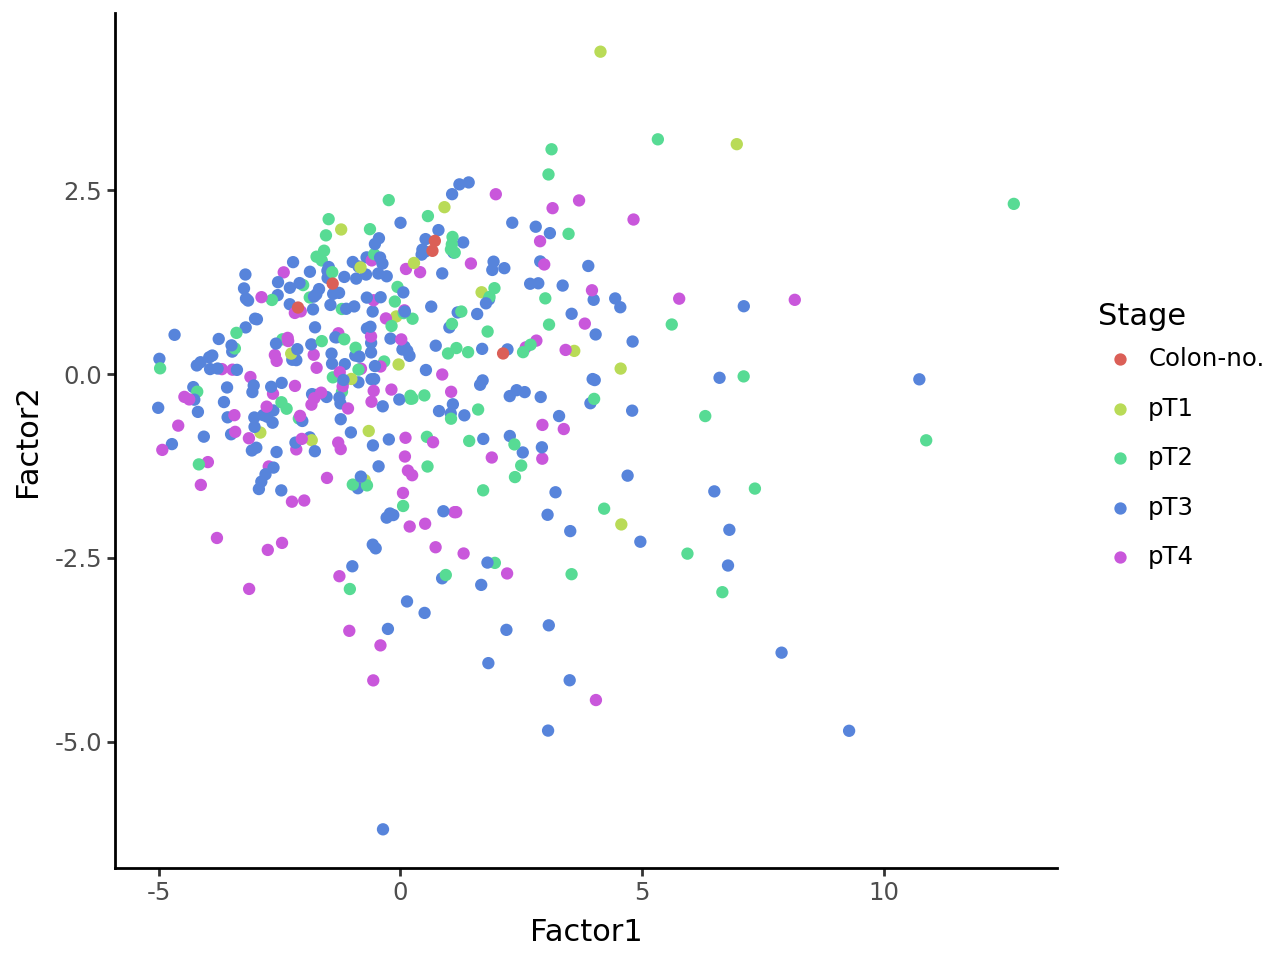

In [10]:
ggplot(factor_scores, aes(x='Factor1', y='Factor2', color='Stage')) + geom_point() + theme_classic()

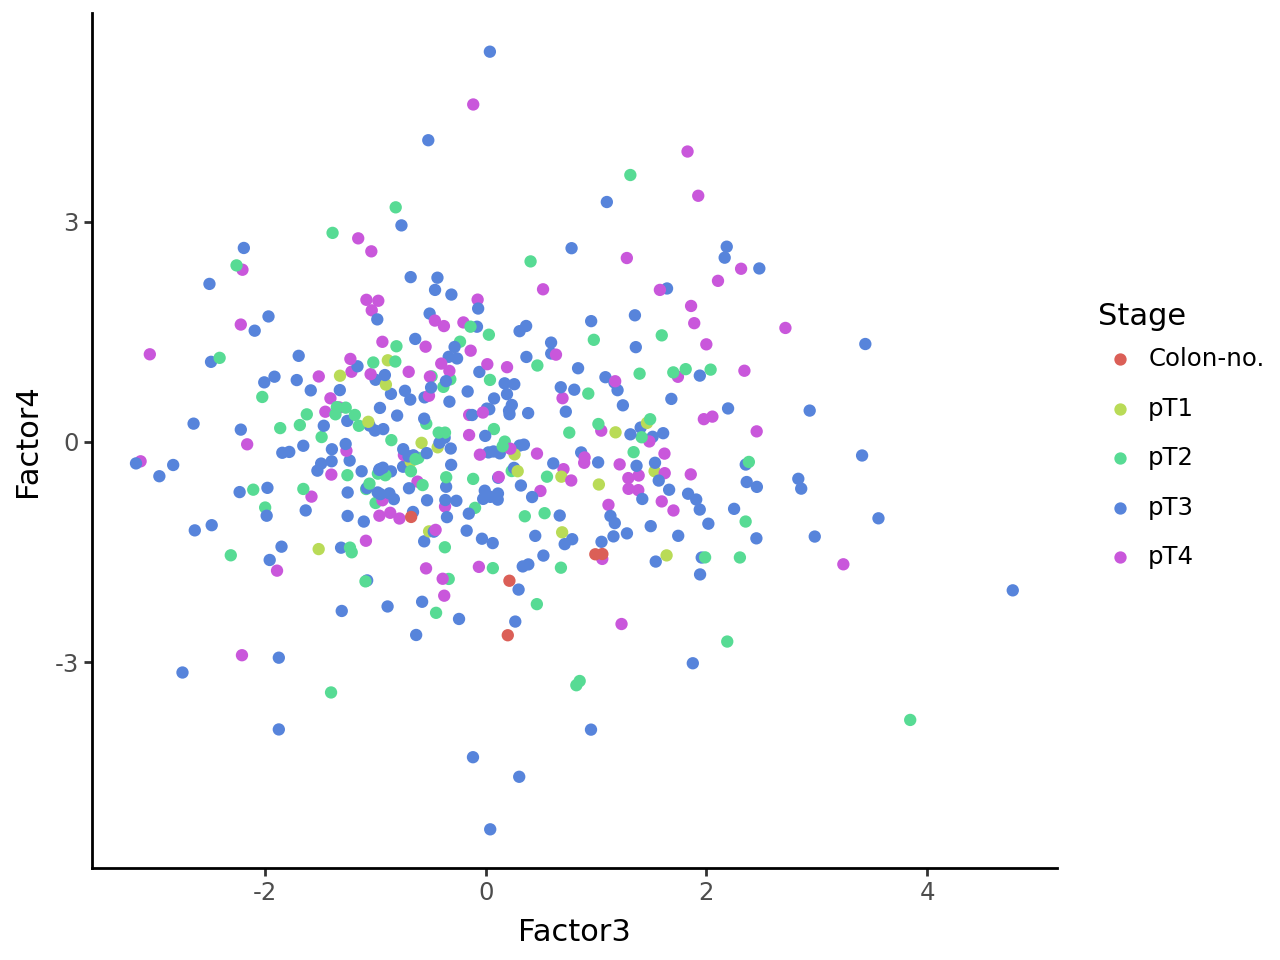

In [11]:
ggplot(factor_scores, aes(x='Factor3', y='Factor4', color='Stage')) + geom_point() + theme_classic()

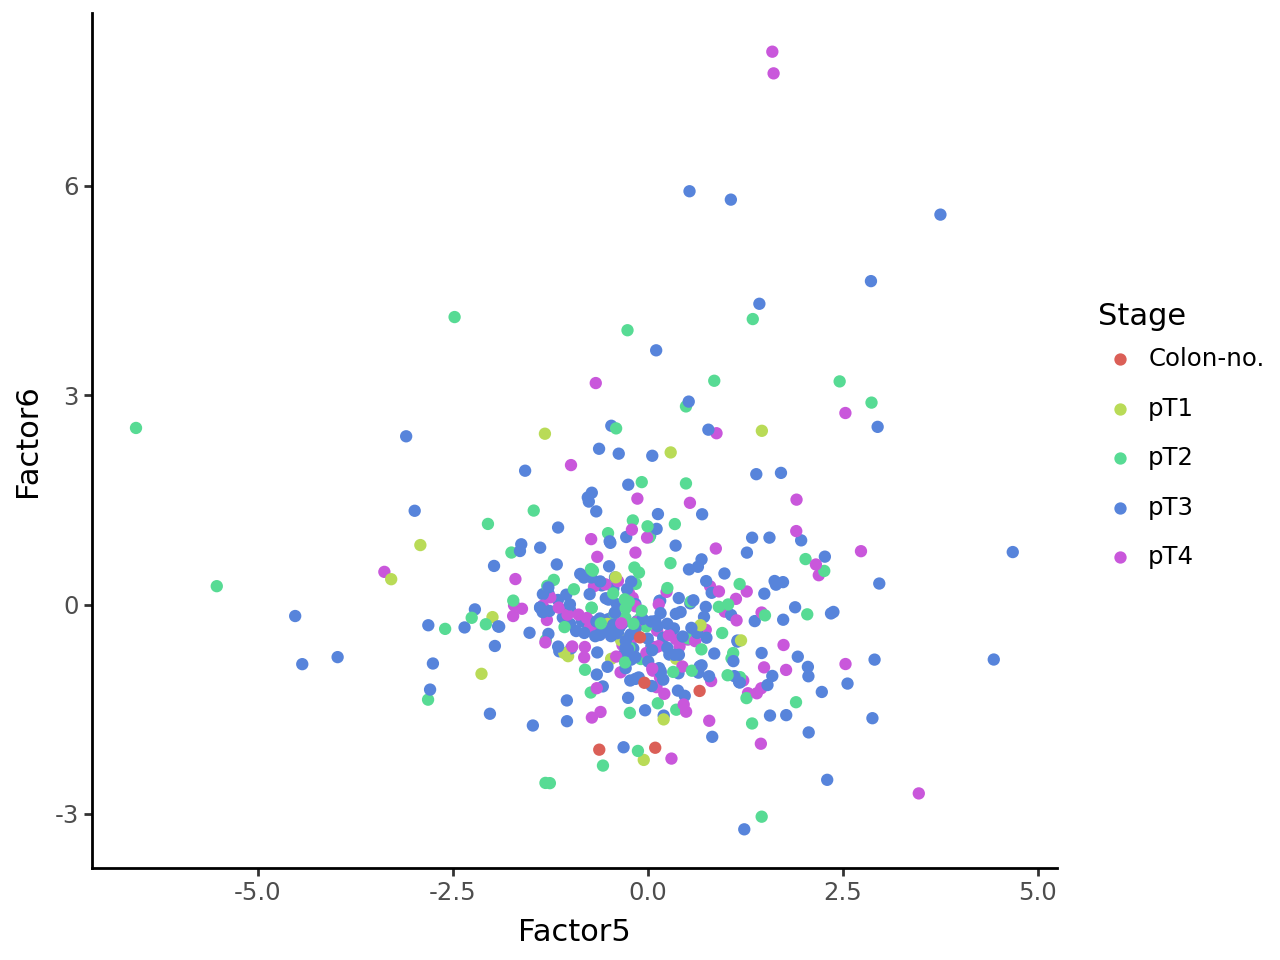

In [12]:
ggplot(factor_scores, aes(x='Factor5', y='Factor6', color='Stage')) + geom_point() + theme_classic()

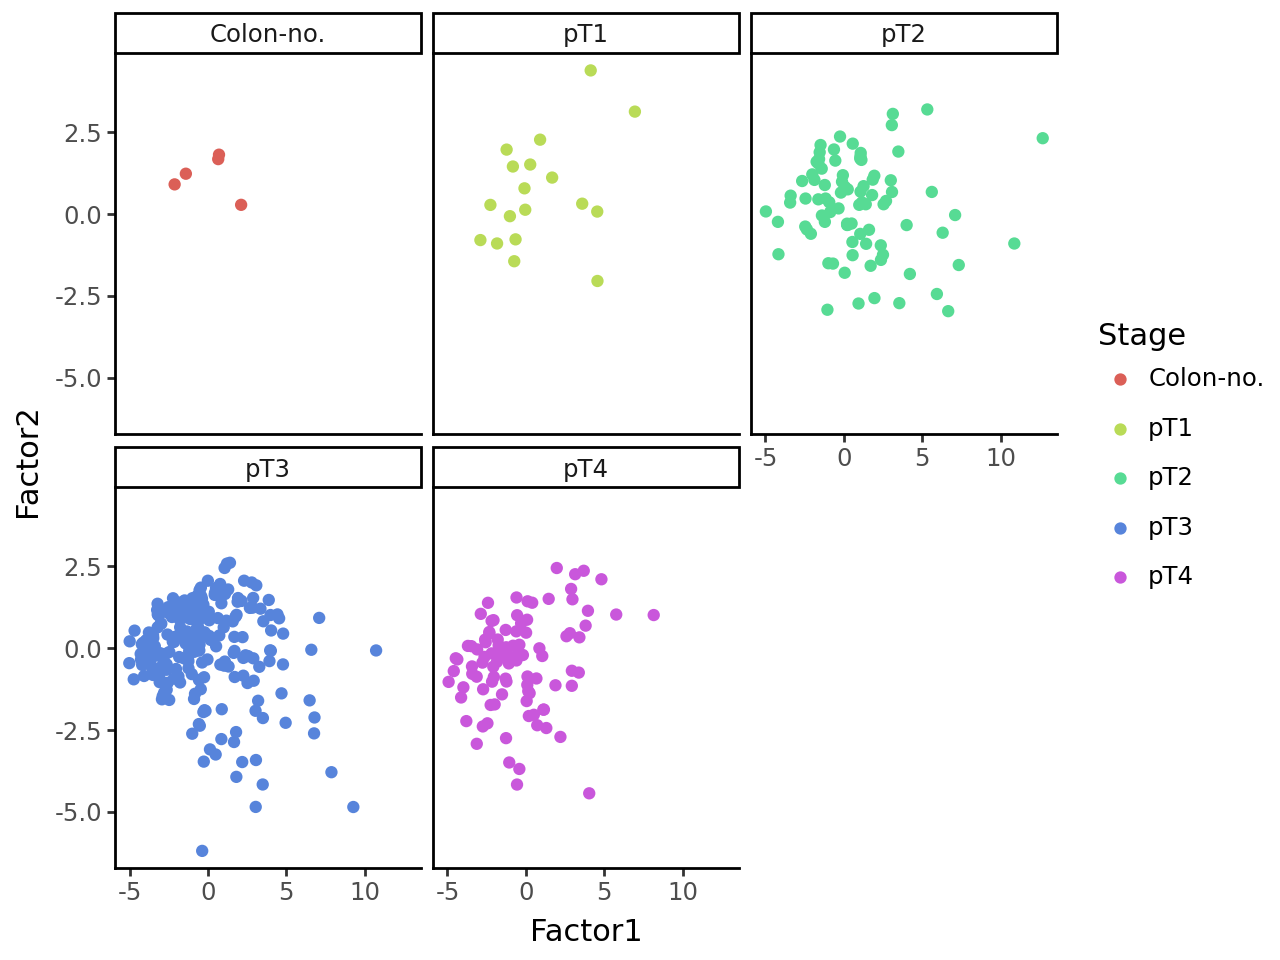

In [13]:
ggplot(factor_scores, aes(x='Factor1', y='Factor2', color='Stage')) + geom_point() + facet_wrap('~Stage') + theme_classic()

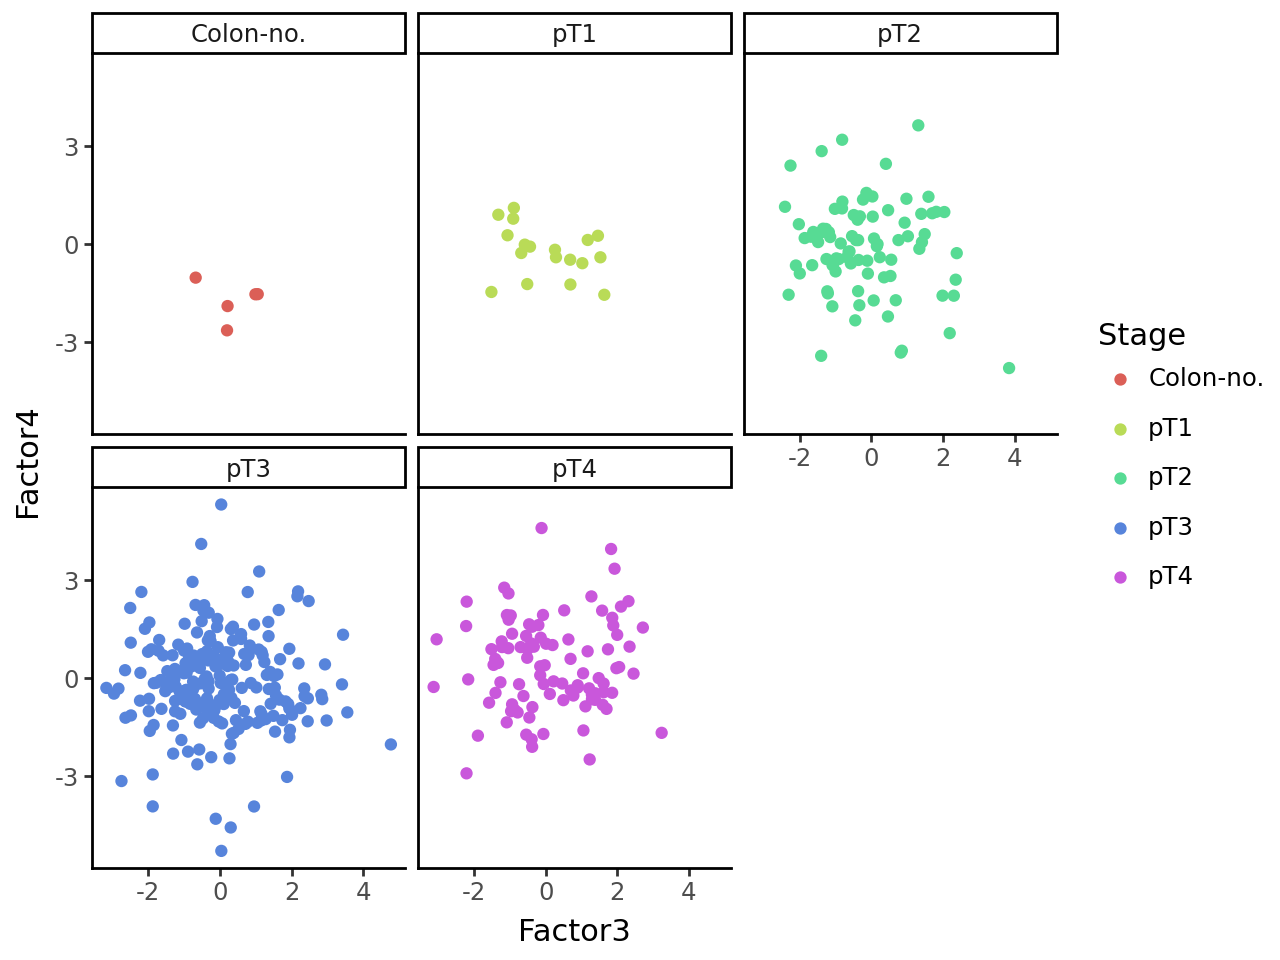

In [14]:
ggplot(factor_scores, aes(x='Factor3', y='Factor4', color='Stage')) + geom_point() + facet_wrap('~Stage') + theme_classic()

In [15]:
variable_loadings = li.ut.get_variable_loadings(features, varm_key='LFs') # get loadings

In [16]:
# Add cell type (view) to the variable loadings
variable_loadings['view'] = ''
for view in features.mod.keys():
    variable_loadings.loc[np.arange(len(features.varm[view]))[features.varm[view]],"view"] = view
    
# order features by absolute value for Factor 1
variable_loadings = variable_loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False) # Default
variable_loadings.head()

index   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
129    CS  0.306889  0.065135 -0.001363  0.016689  0.128123 -0.087452   
287    CS  0.303885  0.164579 -0.016021  0.004740  0.133452 -0.143784   
50     CS  0.296595  0.065305  0.015244  0.067266  0.013732 -0.135295   
211    CS  0.286593  0.188798  0.000287  0.121951  0.180162  0.011765   
249    CS  0.285392  0.253715  0.000316  0.067090  0.094616 -0.106014   

          Factor7       Factor8       Factor9      Factor10  \
129  4.351959e-24 -8.063952e-24  8.976139e-24 -2.566851e-22   
287  4.434751e-25 -8.594797e-25  9.624855e-25 -2.753236e-23   
50   4.233315e-24 -7.955084e-24  8.684253e-24 -2.565841e-22   
211  3.787159e-24 -7.015804e-24  7.755102e-24 -2.210487e-22   
249 -4.871183e-24  9.041351e-24 -1.007250e-23  2.867229e-22   

                     view  
129        CD4_lymphocyte  
287  Cytotoxic_lymphocyte  
50             Fibroblast  
211      Endothelial_cell  
249              Monocyte

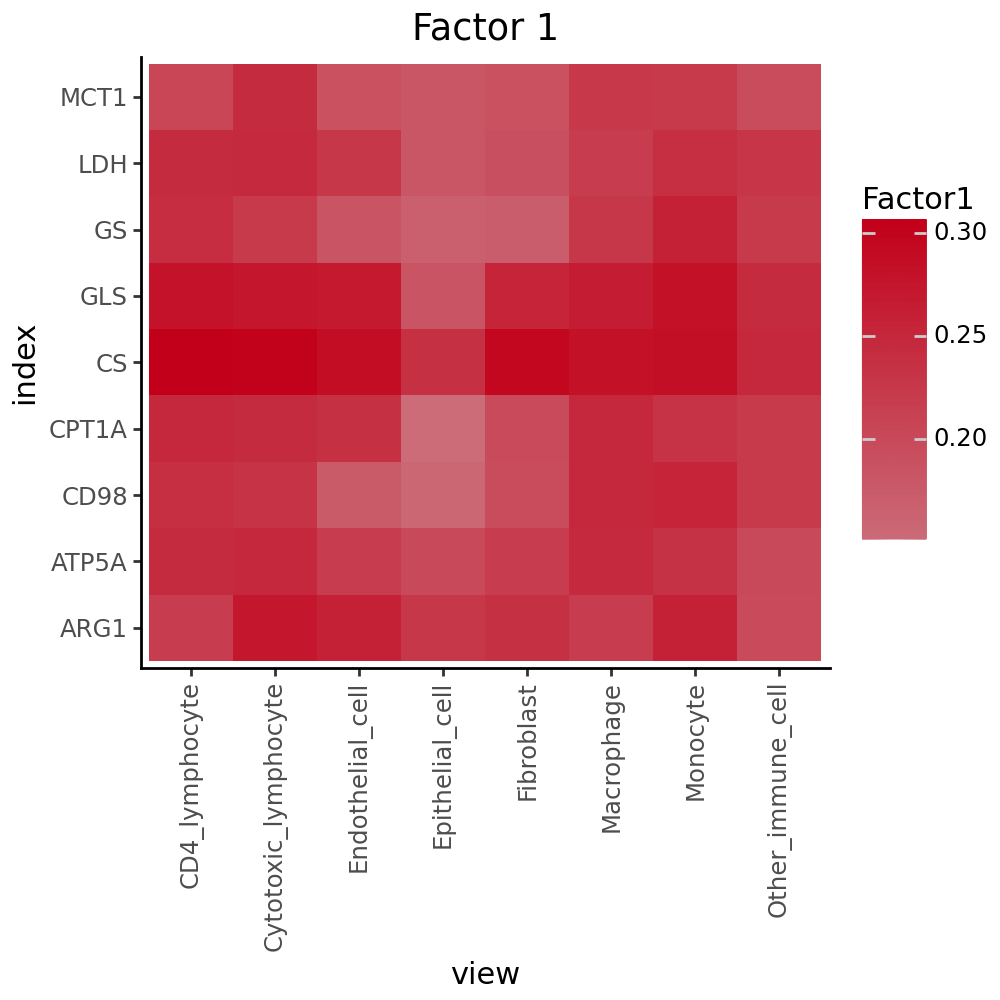

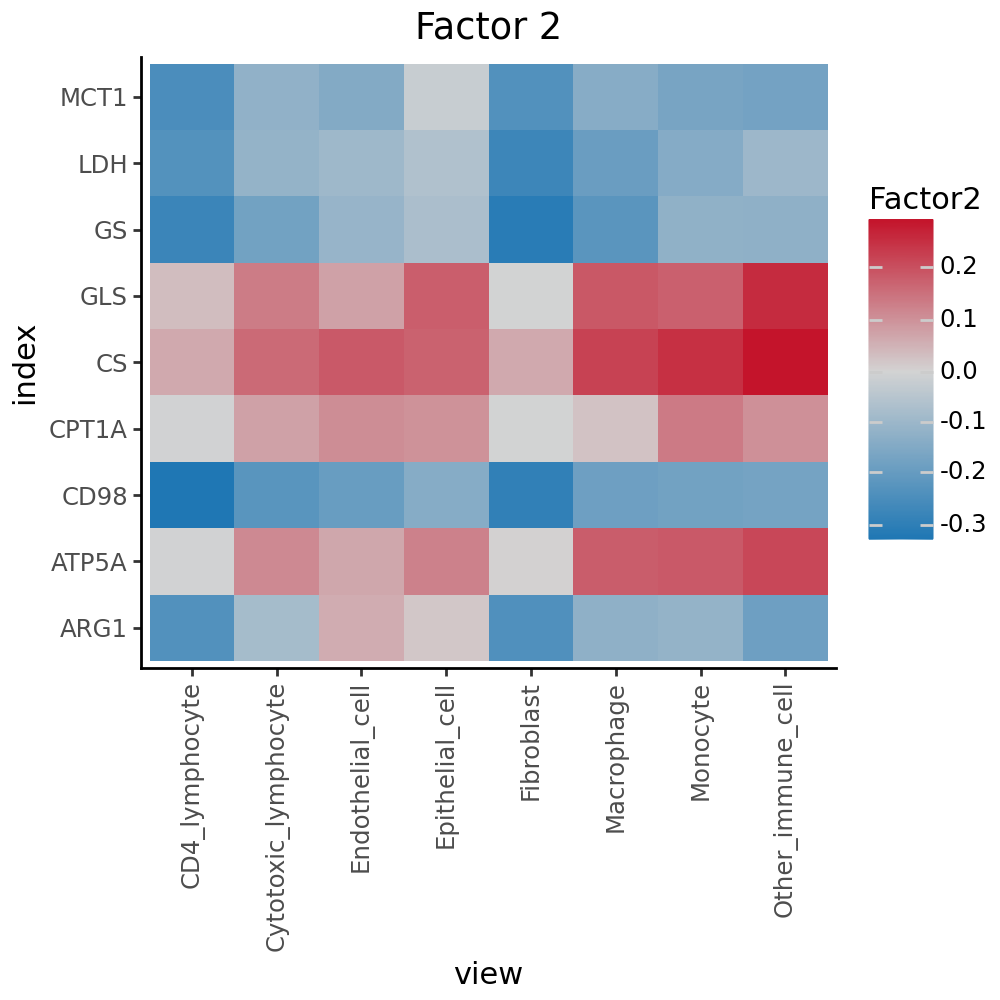

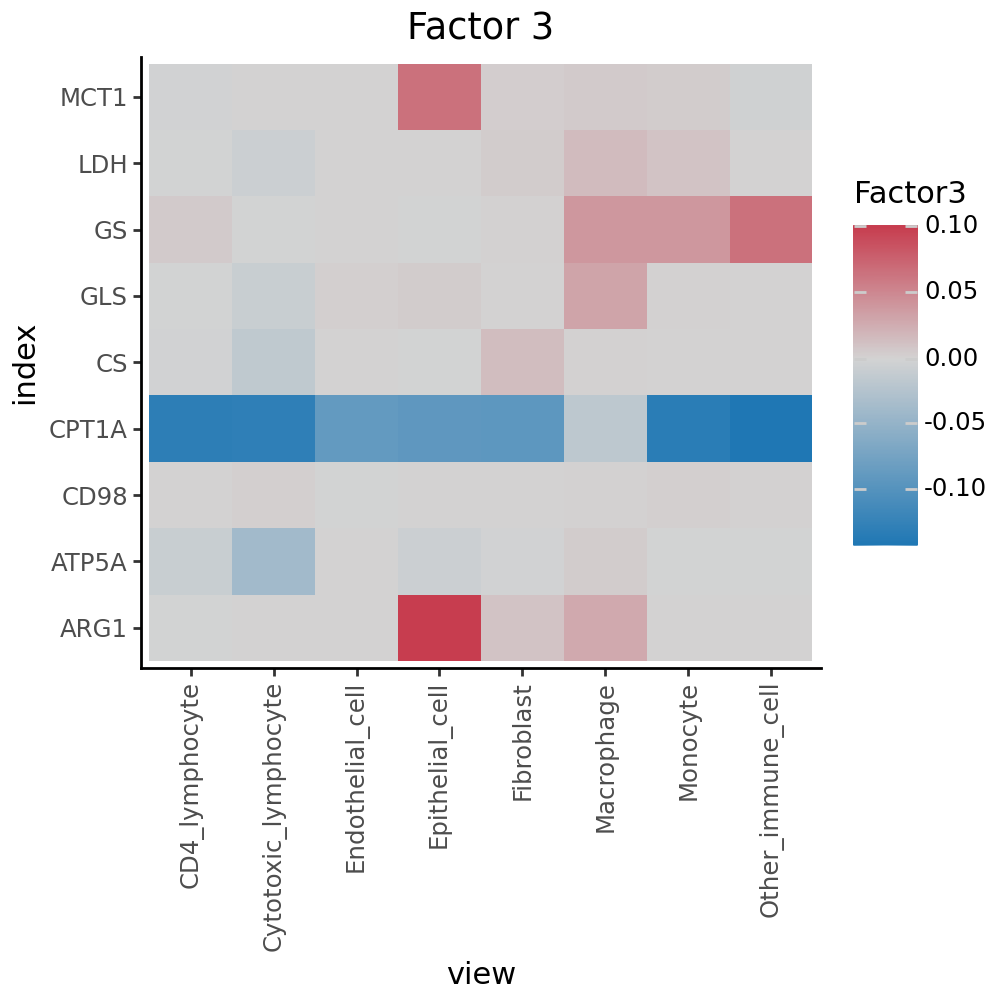

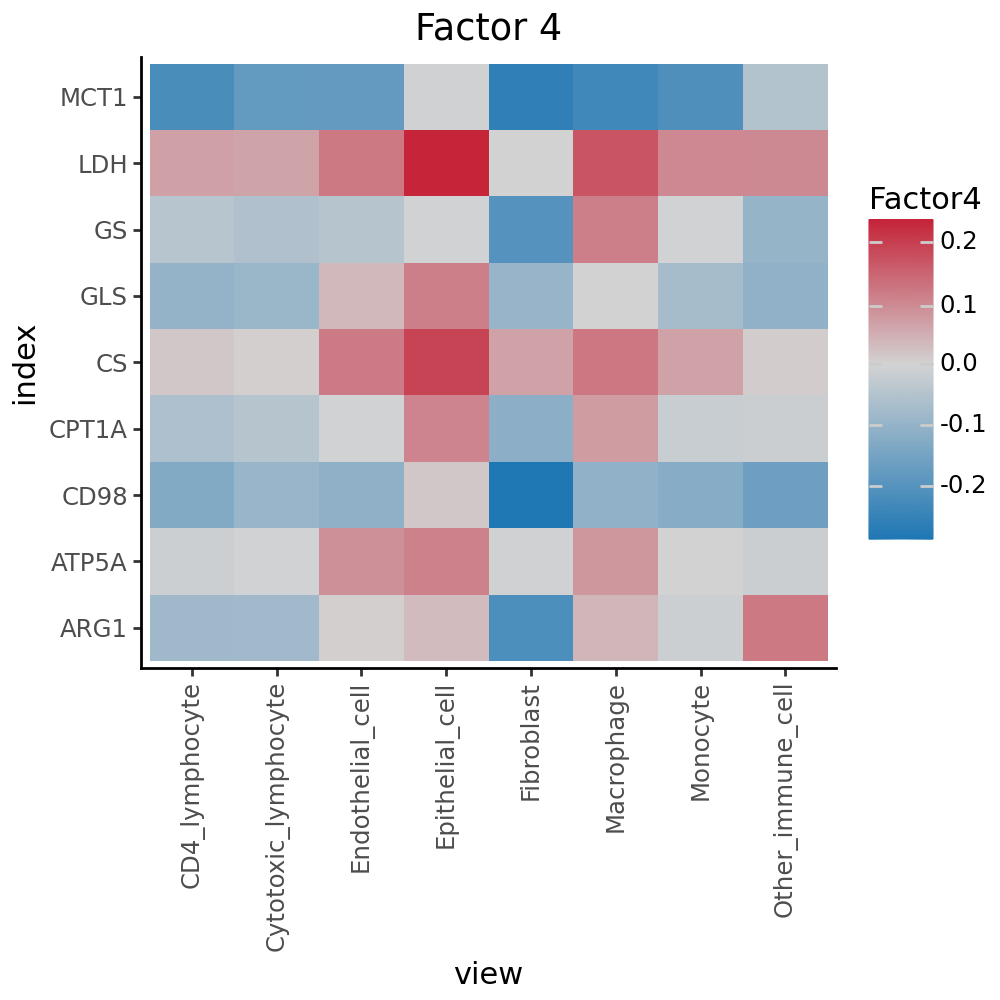

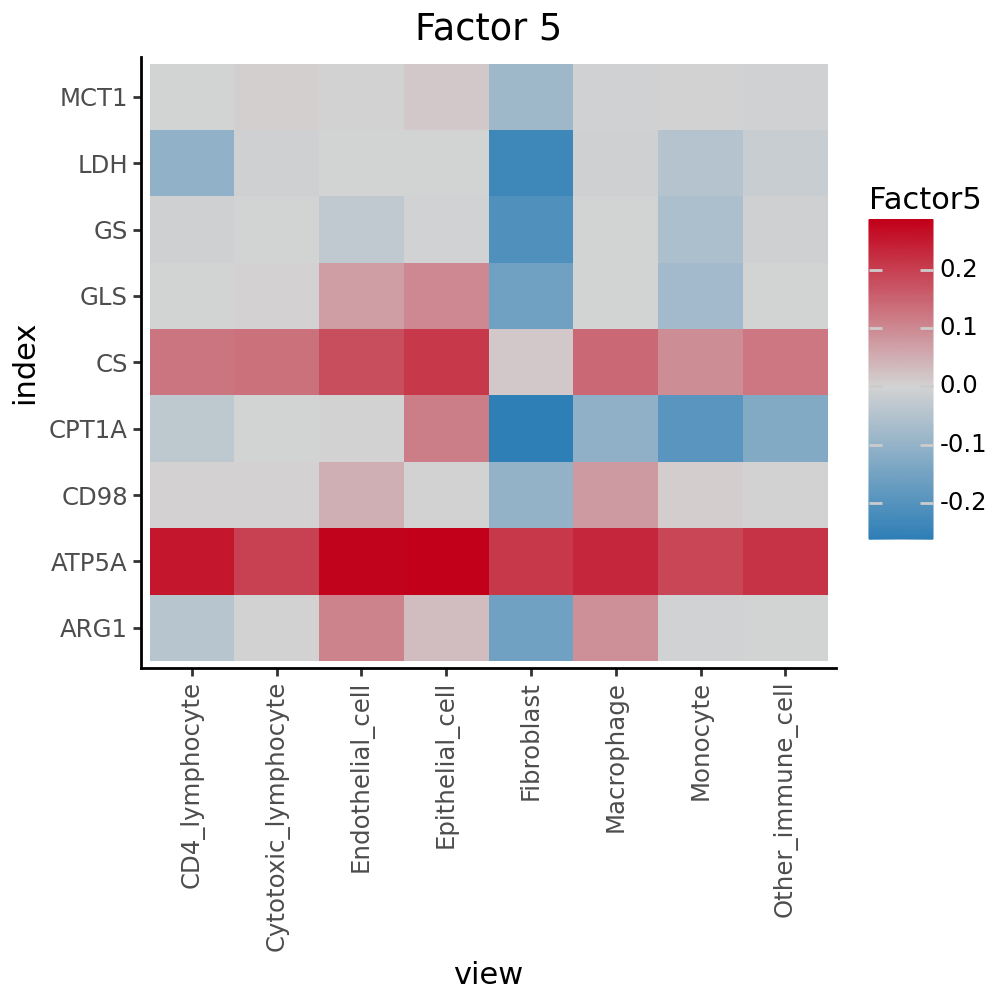

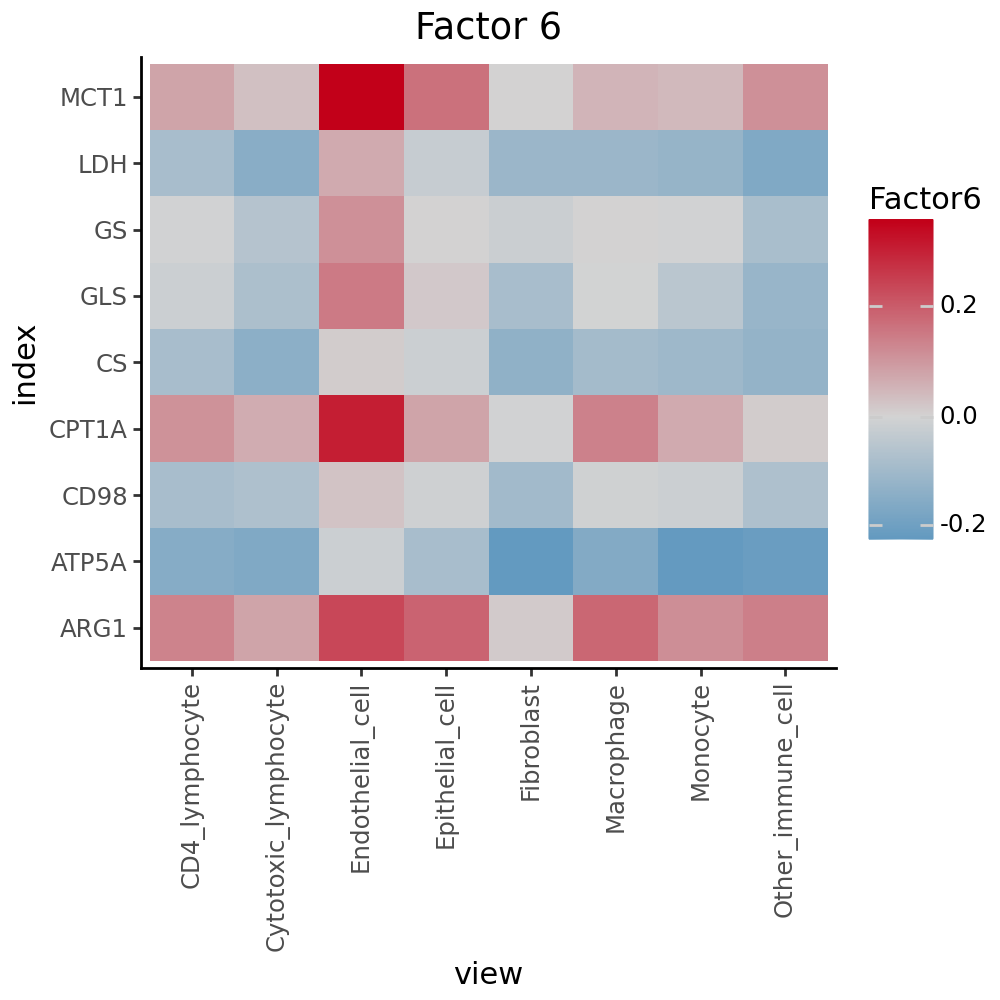

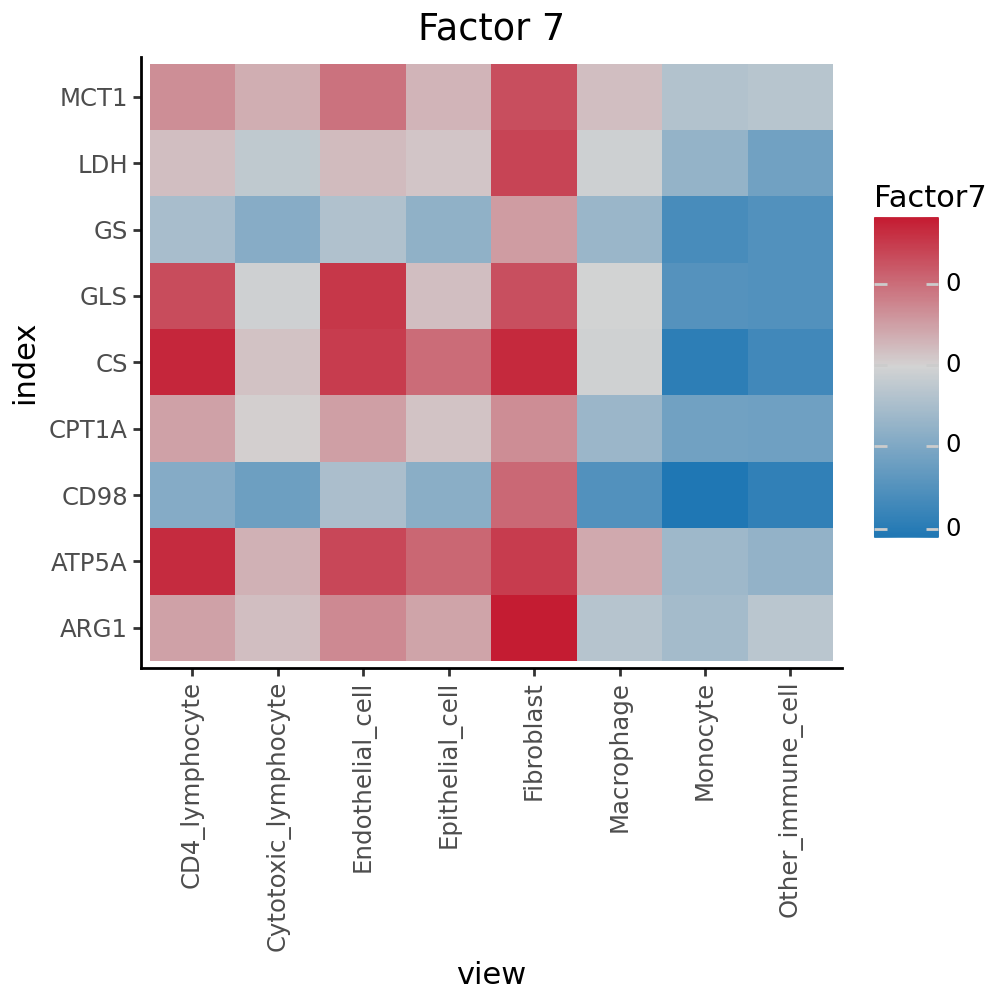

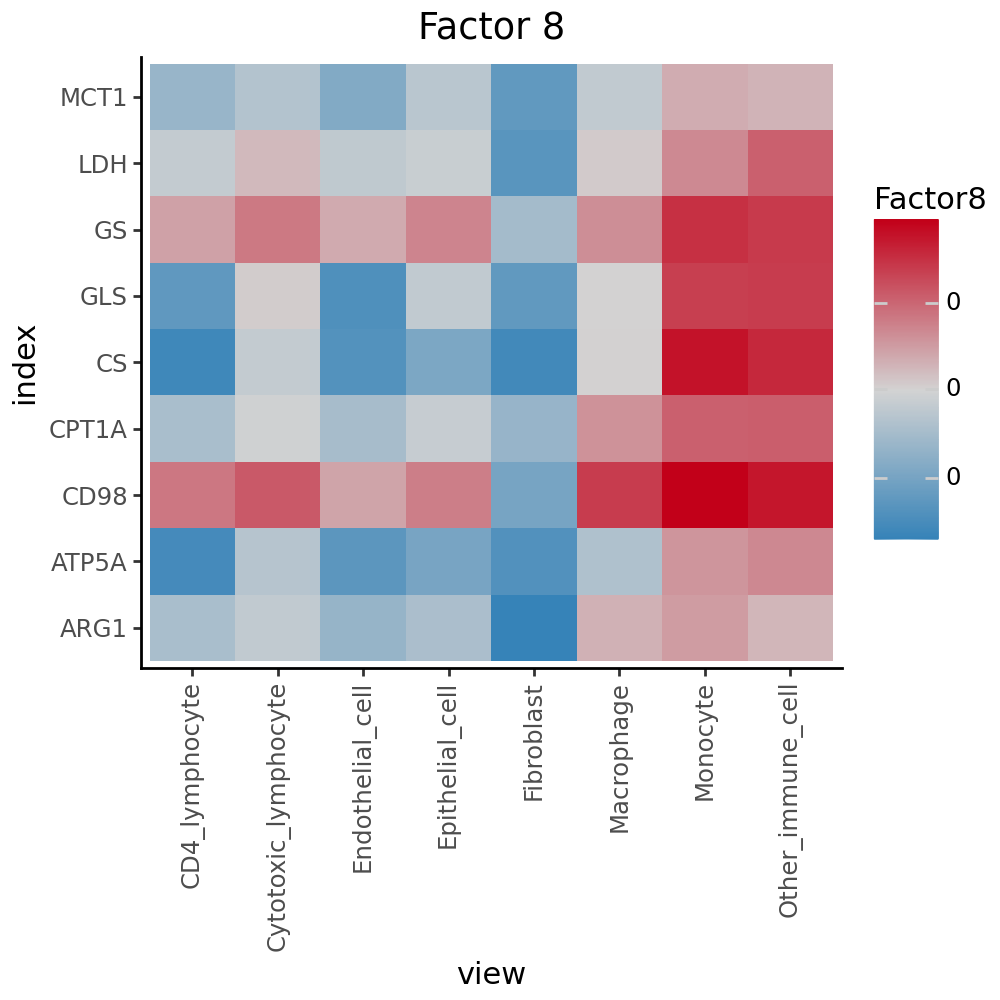

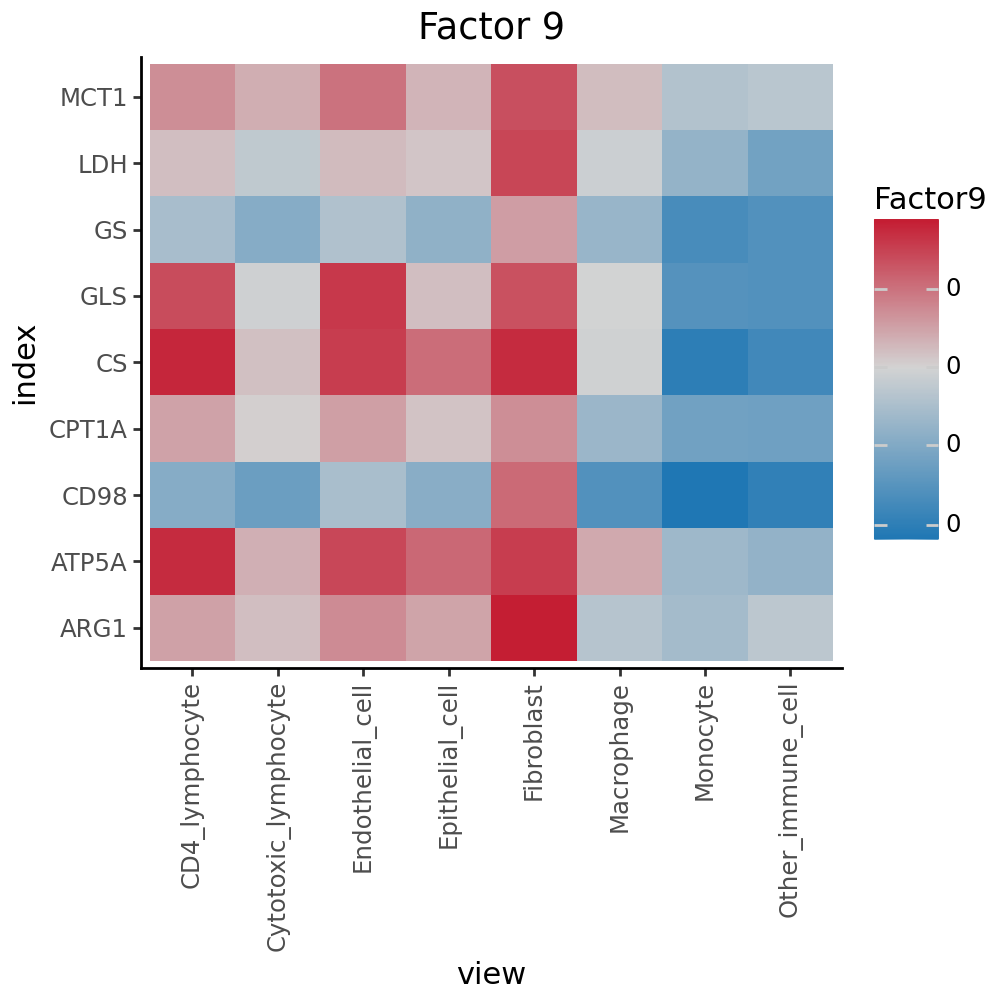

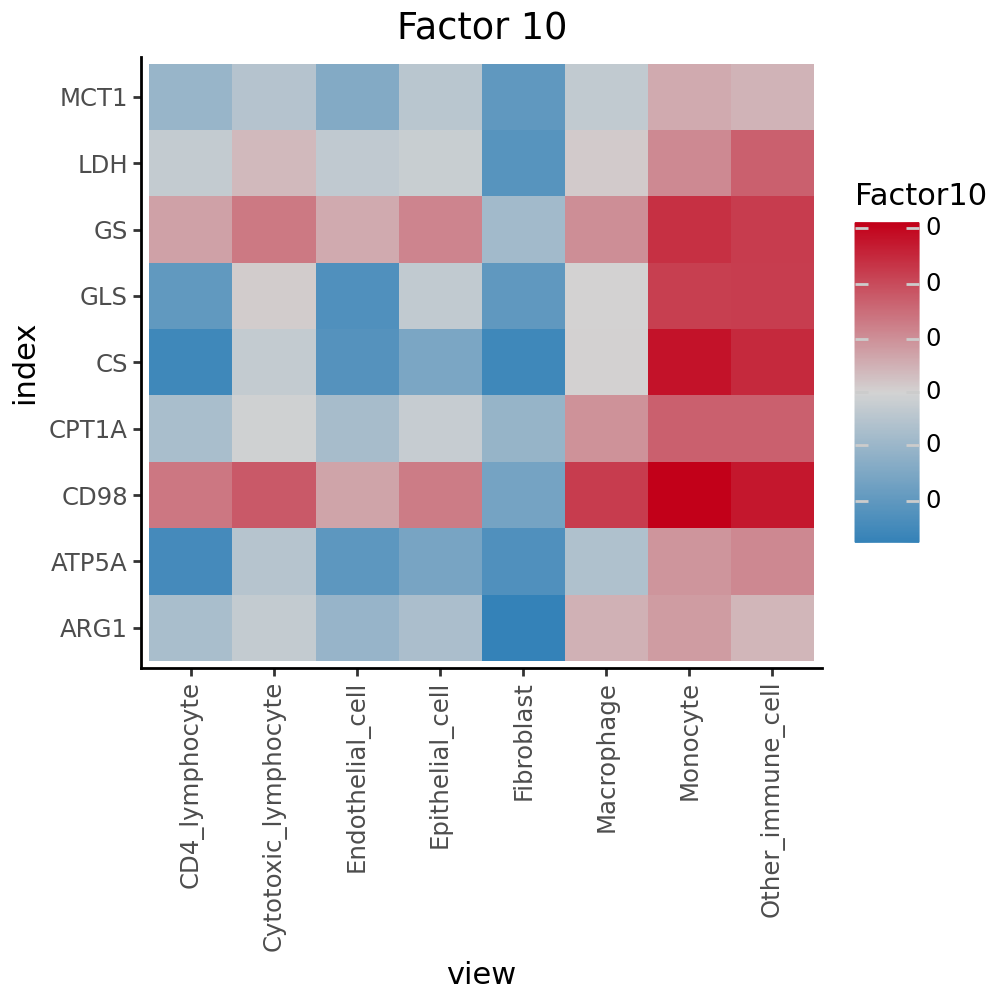

In [17]:
# get top genes with highest absolute loadings across all views
top_genes = variable_loadings['index'].head(30)
top_loadings = variable_loadings[variable_loadings['index'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

for fnum in range(1, top_loadings.shape[1] - 1):
    # plot them
    # dotplot of variable, view, loadings
    gp = (ggplot(top_loadings) +
        ggtitle(f"Factor {fnum}") +
        aes(x='view', y='index', fill=f'Factor{fnum}') +
        geom_tile() +
        scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') +
        theme_classic() +
        theme(axis_text_x=element_text(angle=90, hjust=0.5), figure_size=(5, 5))
    )
    gp.show()

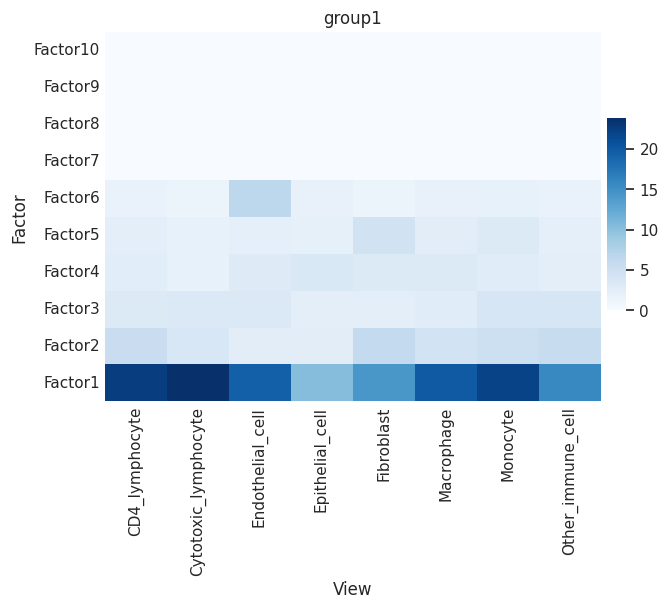

In [18]:
model = mofa.mofa_model('../../data/mofacell_sim.h5ad')
mofa.plot_r2(model, x='View')

In [19]:
m = model
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

Cells: 423
Features: 308
Groups of cells: group1
Views: Other_immune_cell, Fibroblast, Macrophage, CD4_lymphocyte, Epithelial_cell, Endothelial_cell, Monocyte, Cytotoxic_lymphocyte



In [20]:
m.get_weights(df=True)

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
proportion -0.010499 -0.259464 -0.012326  0.130027 -0.089468  0.066725   
CA9         0.162537 -0.043888 -0.082619  0.142868  0.043874  0.386059   
CD98        0.222262 -0.170413  0.001335 -0.162202  0.000673 -0.074564   
CytC        0.202298 -0.007917 -0.076961 -0.243825  0.277428 -0.014063   
MCT1        0.195267 -0.173325 -0.003185 -0.051173 -0.005965  0.113291   
...              ...       ...       ...       ...       ...       ...   
area_std    0.060915 -0.017212  0.291507 -0.002415  0.042321  0.006552   
PD1         0.179527  0.077963 -0.005394 -0.054630 -0.140327 -0.061145   
STING1      0.181623  0.161704 -0.011592  0.098136  0.005778 -0.010794   
MSH2        0.222447  0.174028 -0.079685 -0.001339 -0.183284  0.002209   
MSH6        0.199084  0.164661 -0.005095 -0.002114 -0.272890 -0.023059   

                 Factor7       Factor8       Factor9      Factor10  
proportion -3.069564e-25  5.835580e-25 -6.438013e-25  1.890027e-23  
CA9        -1.000113e-24  1.843735e-24 -2.044306e-24  5.771450e-23  
CD98       -4.729600e-24  8.833587e-24 -9.785413e-24  2.805549e-22  
CytC       -2.228020e-24  4.139569e-24 -4.584145e-24  1.307978e-22  
MCT1       -7.892251e-25  1.478722e-24 -1.605808e-24  4.747712e-23  
...                  ...           ...           ...           ...  
area_std    4.228227e-25 -8.116725e-25  8.959156e-25 -2.608563e-23  
PD1        -6.583589e-25  1.251225e-24 -1.375248e-24  4.002856e-23  
STING1      7.184295e-25 -1.354999e-24  1.516080e-24 -4.255461e-23  
MSH2        1.628878e-24 -3.091127e-24  3.464602e-24 -9.775580e-23  
MSH6        1.992232e-24 -3.767141e-24  4.228275e-24 -1.186164e-22  

[308 rows x 10 columns]

In [21]:
model = mofa.mofa_model('../../data/mofacell_sim.h5ad')
model_r2 = model.get_r2(per_factor = False).sort_values("R2", ascending=False) 
model.close()
model_r2

Factor                  View   Group         R2
7   Factor1  Cytotoxic_lymphocyte  group1  23.815515
3   Factor1        CD4_lymphocyte  group1  22.529247
6   Factor1              Monocyte  group1  22.101203
2   Factor1            Macrophage  group1  19.988016
5   Factor1      Endothelial_cell  group1  19.385399
..      ...                   ...     ...        ...
67  Factor9        CD4_lymphocyte  group1   0.000000
68  Factor9       Epithelial_cell  group1   0.000000
69  Factor9      Endothelial_cell  group1   0.000000
70  Factor9              Monocyte  group1   0.000000
71  Factor9  Cytotoxic_lymphocyte  group1   0.000000

[80 rows x 4 columns]

In [22]:
m.get_r2().sort_values("R2", ascending=False)

Factor                  View   Group         R2
7   Factor1  Cytotoxic_lymphocyte  group1  23.815515
3   Factor1        CD4_lymphocyte  group1  22.529247
6   Factor1              Monocyte  group1  22.101203
2   Factor1            Macrophage  group1  19.988016
5   Factor1      Endothelial_cell  group1  19.385399
..      ...                   ...     ...        ...
67  Factor9        CD4_lymphocyte  group1   0.000000
68  Factor9       Epithelial_cell  group1   0.000000
69  Factor9      Endothelial_cell  group1   0.000000
70  Factor9              Monocyte  group1   0.000000
71  Factor9  Cytotoxic_lymphocyte  group1   0.000000

[80 rows x 4 columns]

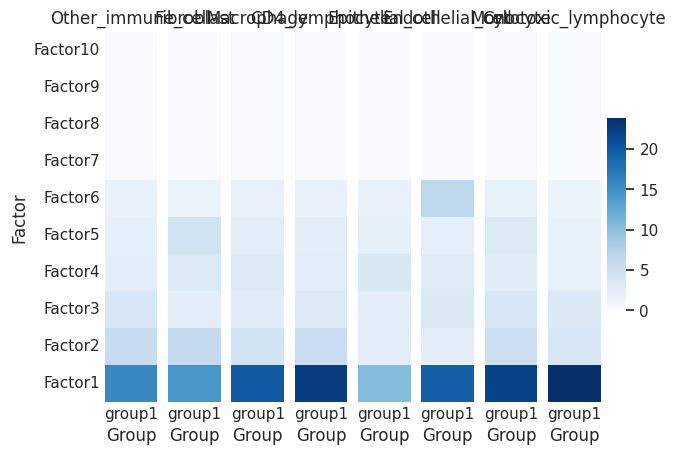

In [23]:
mofa.plot_r2(m, cmap="Blues")

In [24]:
# Final training ELBO value
m.training_stats["elbo"][-1]

-164066.98106643354

In [25]:
model.close()

In [26]:
# Kruksal Wallis test for factor 1 and stage
from scipy.stats import kruskal
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor{fnum}']
    stage = factor_scores['Stage']
    print(kruskal(factor1[stage == 'pT1'], factor1[stage == 'pT2'], factor1[stage == 'pT3'], factor1[stage == 'pT4'], factor1[stage == 'Colon-no.']))
    # Note: multiply by 10 for Bonferroni correction

KruskalResult(statistic=13.643182243733008, pvalue=0.008525418895337419)
KruskalResult(statistic=18.19983200540537, pvalue=0.0011279100235387365)
KruskalResult(statistic=3.20875261522815, pvalue=0.52351840990037)
KruskalResult(statistic=18.865183819772028, pvalue=0.0008353521658792063)
KruskalResult(statistic=5.414853601028653, pvalue=0.24731591554109988)
KruskalResult(statistic=10.489180257619864, pvalue=0.03294635589038505)
KruskalResult(statistic=5.391843987654283, pvalue=0.2494013217984434)
KruskalResult(statistic=5.386591565361869, pvalue=0.24987948003300137)
KruskalResult(statistic=5.386858015148164, pvalue=0.24985520455742274)
KruskalResult(statistic=5.341446614488177, pvalue=0.25402195513644243)


In [27]:
# order features by absolute value for Factor 4 (associated with disease stage)
variable_loadings = variable_loadings.sort_values(by='Factor4', key=lambda x: abs(x), ascending=False) # Default
variable_loadings.head(15)

index   Factor1   Factor2  \
91                                          PKM2  0.147434 -0.269791   
250                                         PKM2  0.169250 -0.219659   
212                                         PKM2  0.161263 -0.195411   
11                                          PKM2  0.152149 -0.211517   
163                                         PKM2  0.110566 -0.211877   
130                                         PKM2  0.158864 -0.310638   
288                                         PKM2  0.140907 -0.232022   
51                                          PKM2  0.143894 -0.352134   
42                                          CD98  0.196800 -0.295341   
45                                         ASCT2  0.213365 -0.251986   
44                                          MCT1  0.188555 -0.234719   
219  juxtaview.40_l.Endothelial_cell_Cancer_cell  0.094243 -0.026875   
3                                           CytC  0.202298 -0.007917   
158                                          LDH  0.182386 -0.062427   
180       paraview.120_p.Cancer_cell_Cancer_cell -0.023605  0.108637   

      Factor3   Factor4   Factor5   Factor6       Factor7       Factor8  \
91   0.000263  0.475799  0.001983 -0.001542 -1.425858e-25  2.279263e-25   
250  0.000067  0.470450 -0.000435 -0.000756 -3.174832e-24  5.871550e-24   
212 -0.012207  0.467607  0.001031  0.001107  1.295810e-24 -2.436760e-24   
11  -0.000823  0.444375 -0.000750 -0.002522 -2.948240e-24  5.478788e-24   
163 -0.004358  0.422017 -0.002645 -0.011403  5.281824e-25 -9.798243e-25   
130 -0.011029  0.421806 -0.000652 -0.004319  1.120509e-24 -2.097886e-24   
288 -0.001708  0.411493  0.004091 -0.064747 -7.243241e-25  1.359546e-24   
51   0.002264  0.358887 -0.118446 -0.007769  1.893023e-24 -3.593005e-24   
42   0.000552 -0.289998 -0.101544 -0.096909  2.662234e-24 -5.035790e-24   
45   0.000780 -0.271573 -0.090292 -0.079293  2.146770e-24 -4.057000e-24   
44   0.003560 -0.263622 -0.084162  0.000310  3.325968e-24 -6.253428e-24   
219 -0.024257 -0.249934  0.002498 -0.063139  1.198187e-25 -2.369871e-25   
3   -0.076961 -0.243825  0.277428 -0.014063 -2.228020e-24  4.139569e-24   
158  0.000408  0.240271 -0.001094 -0.025465  3.407117e-25 -6.050018e-25   
180  0.003067  0.240269  0.002785  0.040389 -9.119193e-25  1.699535e-24   

          Factor9      Factor10                  view  
91  -2.691636e-25  5.963828e-24            Macrophage  
250 -6.530893e-24  1.857319e-22              Monocyte  
212  2.669267e-24 -7.813627e-23      Endothelial_cell  
11  -6.058456e-24  1.734171e-22     Other_immune_cell  
163  1.096903e-24 -3.139470e-23       Epithelial_cell  
130  2.334289e-24 -6.777746e-23        CD4_lymphocyte  
288 -1.507005e-24  4.277154e-23  Cytotoxic_lymphocyte  
51   3.899646e-24 -1.172780e-22            Fibroblast  
42   5.465928e-24 -1.638929e-22            Fibroblast  
45   4.419080e-24 -1.315911e-22            Fibroblast  
44   6.849394e-24 -2.015450e-22            Fibroblast  
219  2.484657e-25 -8.049649e-24      Endothelial_cell  
3   -4.584145e-24  1.307978e-22     Other_immune_cell  
158  7.066960e-25 -1.799759e-23       Epithelial_cell  
180 -1.896212e-24  5.436147e-23       Epithelial_cell

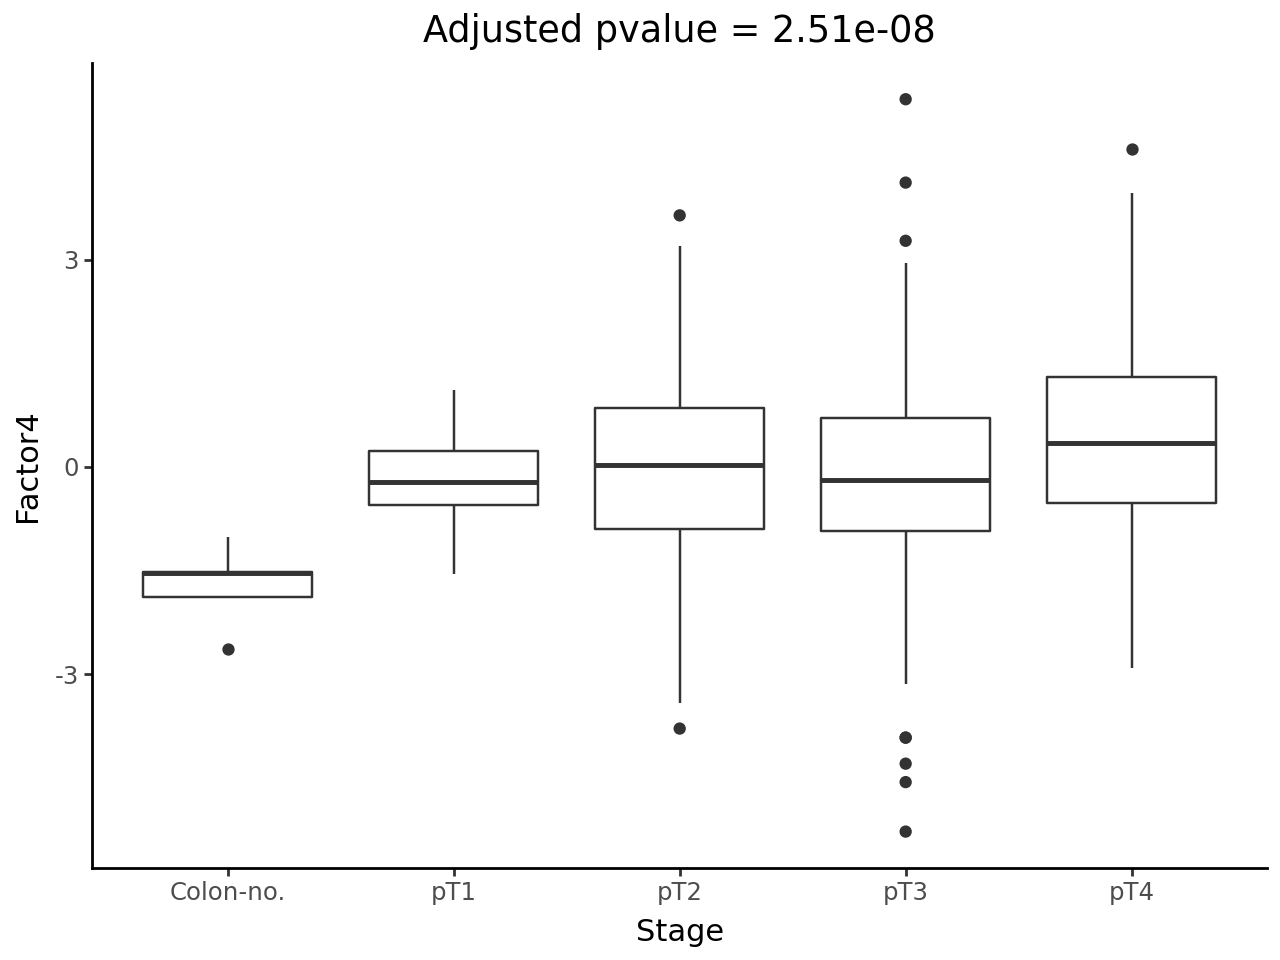

In [28]:
ggplot(factor_scores, aes(y='Factor4', x='Stage')) + geom_boxplot() + theme_classic() + ggtitle("Adjusted pvalue = 2.51e-08")

### Test "MUVIcell"

In [29]:
model = muvi.tl.from_mdata(
    features,
    n_factors=10,
    nmf=True,
    device=device,
)
model

2025-07-01 15:15:45,829 - muvi.core.models - WARNING - No view names provided!
2025-07-01 15:15:45,829 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2025-07-01 15:15:45,831 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,831 - muvi.core.models - INFO - Storing the index of the view `CD4_lymphocyte` as sample names.
2025-07-01 15:15:45,831 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,831 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,831 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,832 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,832 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,832 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,832 - muvi.core.models - INFO - pd.DataFrame detected.
2025-07-01 15:15:45,832 - muvi.core.models - INFO - pd.DataFrame detected.
2

|=================================================================================================================================================================================================================|
|                                                                                               MuVI version 0.2.0                                                                                                |
|=================================================================================================================================================================================================================|
| Parameter        | Value                                                                                                                                                                                        |
|------------------|------------------------------------------------------------------------------------------------------------------------------------

In [30]:
model.fit(seed=0)

2025-07-01 15:15:46,252 - muvi.core.models - INFO - Using 2 particles in parallel.
2025-07-01 15:15:46,253 - muvi.core.models - INFO - Preparing model and guide...
2025-07-01 15:15:46,253 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2025-07-01 15:15:46,271 - muvi.core.models - INFO - Preparing optimizer...
2025-07-01 15:15:46,271 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2025-07-01 15:15:46,272 - muvi.core.models - INFO - Preparing SVI...
2025-07-01 15:15:46,272 - muvi.core.models - INFO - Preparing training data...
2025-07-01 15:15:46,278 - muvi.core.models - INFO - Using complete dataset.
2025-07-01 15:15:46,280 - muvi.core.models - INFO - Setting training seed to `0`.
2025-07-01 15:15:46,281 - muvi.core.models - INFO - Cleaning parameter store.
2025-07-01 15:15:46,281 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2025-07-01 15:15:47,066 - root - INFO - Guessed max_plate_nesting = 3


 10%|█         | 1023/10000 [00:40<05:52, 25.47it/s, ELBO=254]

Relative improvement of -0.001708 < 1e-05 for 10 step(s) in a row, stopping early.
2025-07-01 15:16:26,444 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [31]:
# Macro R2
np.mean(list(muvi.tl.variance_explained(model)[0].values()))

2025-07-01 15:16:26,448 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


0.8555740108713508

How to compute the reconstruction?  
Computed as `model._mode(z @ ws[vn], model.likelihoods[vn])`  
What are model, z, ws, and vn?  
`model = model`  
z is the factor scores per sample   
`z = model.get_factor_scores()`  
ws is the factor loadings per feature per view  
`ws = model.get_factor_loadings()`  
vn is the view name

Note: the data modeled is shifted to be non-negative, then scaled. The shift increases the standard deviation per view so the scaling is also not ignored. To go back from the reconstruction to the original values we need to apply an inverse transformation.

In [32]:
r2_pool = []
for vn in model.get_factor_loadings().keys():
    rec = model._mode(model.get_factor_scores() @ model.get_factor_loadings()[vn], model.likelihoods[vn])
    # Apply inverse transformation
    shift_factor = np.nanmin(features[vn].X, axis=0)
    # print(f"shift_factor: {shift_factor}")
    scale_factor = np.nanstd(features[vn].X - shift_factor)
    # print(f"scale_factor: {scale_factor}")
    rec = rec * scale_factor + shift_factor
    print(f"Reconstructed features for {vn}: {rec[:2,:2]}")
    r2 = pd.DataFrame({'x': features[vn].X.flatten(), 
                       'y': rec.flatten()}).corr()
    print(f"R2: {r2.iloc[0,1]}")
    r2_pool.append(r2.iloc[0,1])
print(f"Macro R2: {np.mean(r2_pool)}")

Reconstructed features for CD4_lymphocyte: [[-0.33729113 -0.90175458]
 [-0.04048933 -0.23331929]]
R2: 0.6448019948593963
Reconstructed features for Cytotoxic_lymphocyte: [[-0.22091217 -1.051925  ]
 [ 0.07257126 -0.4770714 ]]
R2: 0.6240529148407626
Reconstructed features for Endothelial_cell: [[-0.34056577 -0.75884924]
 [-0.25328276 -0.33238901]]
R2: 0.6117976933667976
Reconstructed features for Epithelial_cell: [[-0.60413001 -0.98634232]
 [-0.36410187 -0.36896709]]
R2: 0.49472282608478996
Reconstructed features for Fibroblast: [[ 0.18386811 -1.03522652]
 [-0.25441397 -0.34186953]]
R2: 0.5623619332004028
Reconstructed features for Macrophage: [[-0.20992548 -0.92509638]
 [-0.01104844 -0.46724491]]
R2: 0.5919683264838966
Reconstructed features for Monocyte: [[-0.07350099 -1.0387453 ]
 [ 0.30585718 -0.45446483]]
R2: 0.6313573623695579
Reconstructed features for Other_immune_cell: [[ 0.13281217 -0.88361395]
 [ 0.30620089 -0.07116613]]
R2: 0.5620724174360676
Macro R2: 0.5903919335802089


In [33]:
muvi.tl.variance_explained(model)[1].sum(axis = "columns")

factor_3    2.226128
factor_1    1.652059
factor_9    1.328850
factor_8    1.201588
factor_0    1.172990
factor_5    0.953800
factor_6    0.905453
factor_4    0.737242
factor_2    0.673382
factor_7    0.509111
dtype: float64

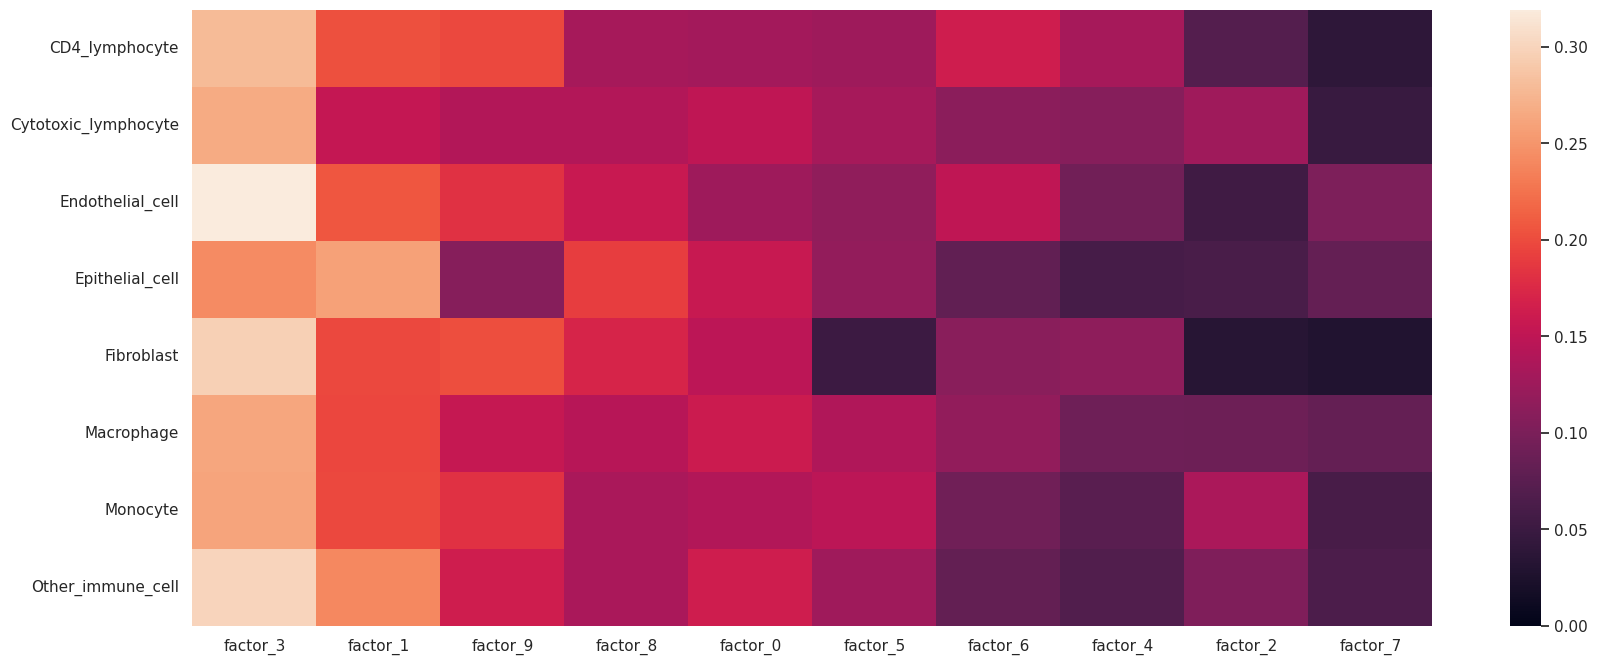

<Axes: >

In [34]:
muvi.pl.variance_explained(model)

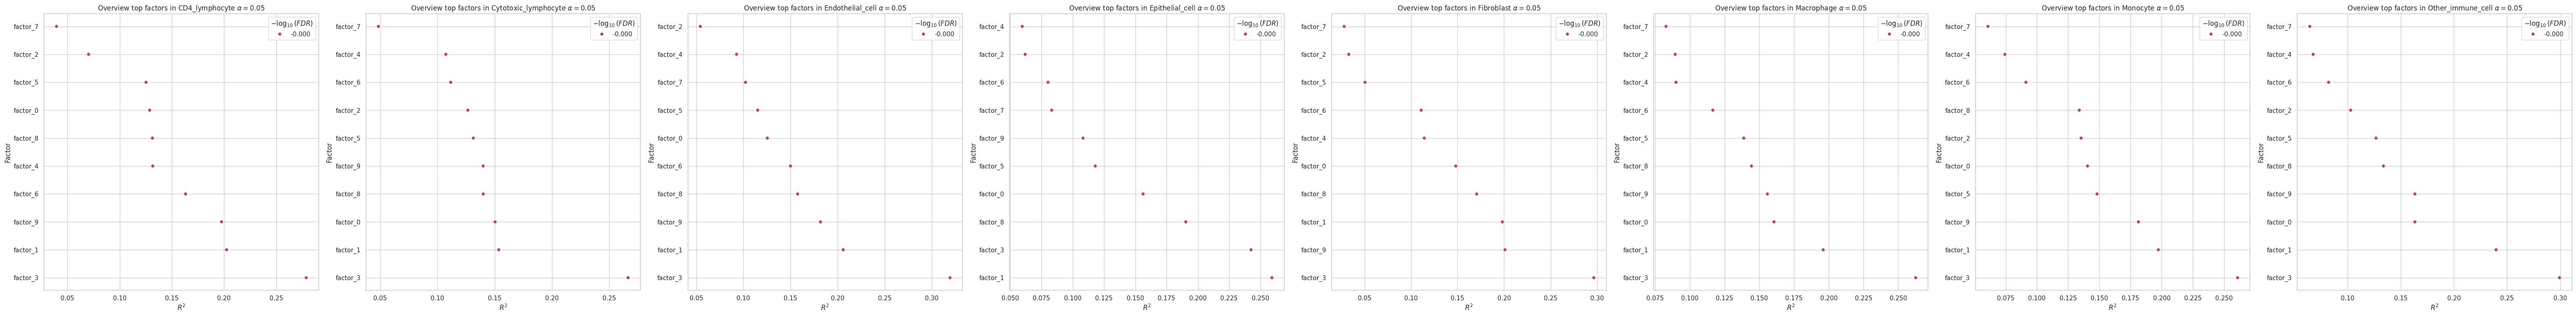

(<Figure size 6400x800 with 8 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in CD4_lymphocyte $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Cytotoxic_lymphocyte $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Endothelial_cell $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Epithelial_cell $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Fibroblast $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Macrophage $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Monocyte $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in Other_immune_cell $\\

In [35]:
muvi.pl.factors_overview(model)

In [36]:
# Get factor loading per modality and feature
all_loadings = model.get_factor_loadings(model.view_names, model.factor_names, as_df=True)

# We can get the mudata order by iterating over the modality names
assert np.all(np.hstack([features.mod[m].var_names.to_list() for m in features.mod]) == features.var_names.to_numpy())

# Format factor loadings for all features, ensure that the order is the same as in the mudata
all_loadings_sorted = [np.transpose(all_loadings[m]).loc[:,[f"factor_{i}" for i in range(all_loadings["CD4_lymphocyte"].shape[0])]]
                       for m in features.mod]
assert np.all(np.hstack([x.index for x in all_loadings_sorted]) == features.var_names.to_numpy())

# Store with mudata
features.varm["MuVI"] = np.vstack(all_loadings_sorted)
# Beware that the order of the factors is not the same as in the figures above

In [37]:
variable_loadings = li.ut.get_variable_loadings(features, varm_key='MuVI') # get loadings

# Add cell type (view) to the variable loadings
variable_loadings['view'] = ''
for view in features.mod.keys():
    variable_loadings.loc[np.arange(len(features.varm[view]))[features.varm[view]],"view"] = view
    
# order features by absolute value for Factor 1
variable_loadings = variable_loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False) # Default
variable_loadings.head()

index   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
288          PKM2  1.016971  0.399585  0.000000  0.000000  0.050005  0.286406   
250          PKM2  0.911284  0.405175  0.072301  0.000000  0.000000  0.312154   
30   eccentricity  0.907368  1.721121  0.483645  1.670093  0.630548  0.511145   
51           PKM2  0.851340  0.270266  0.000000  0.000000  0.266792  0.000000   
91           PKM2  0.823137  0.475106  0.000000  0.000000  0.098920  0.229273   

      Factor7   Factor8   Factor9  Factor10                  view  
288  0.532921  0.286015  0.107701  0.000000  Cytotoxic_lymphocyte  
250  0.507831  0.446630  0.086544  0.000000              Monocyte  
30   0.574562  0.417930  1.024048  1.221418     Other_immune_cell  
51   0.332207  0.273902  0.000000  0.000000            Fibroblast  
91   0.573153  0.320313  0.039372  0.000000            Macrophage

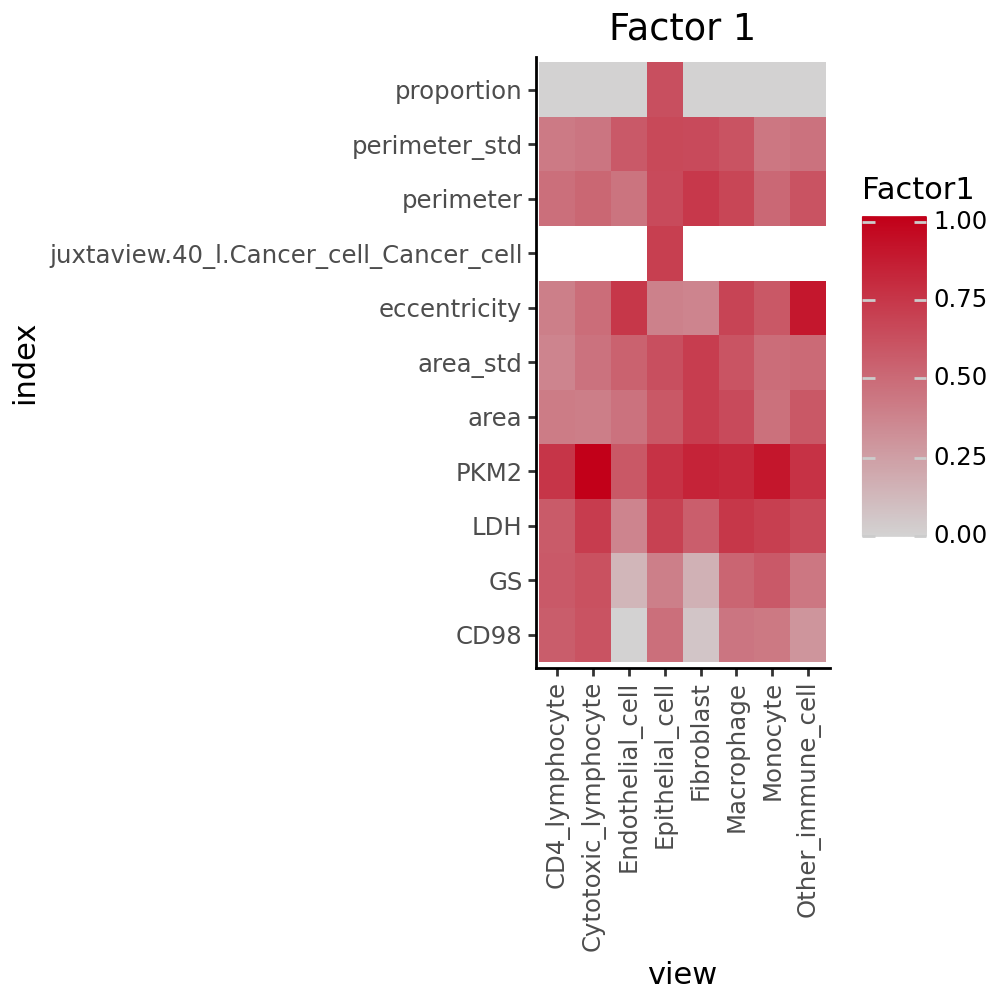

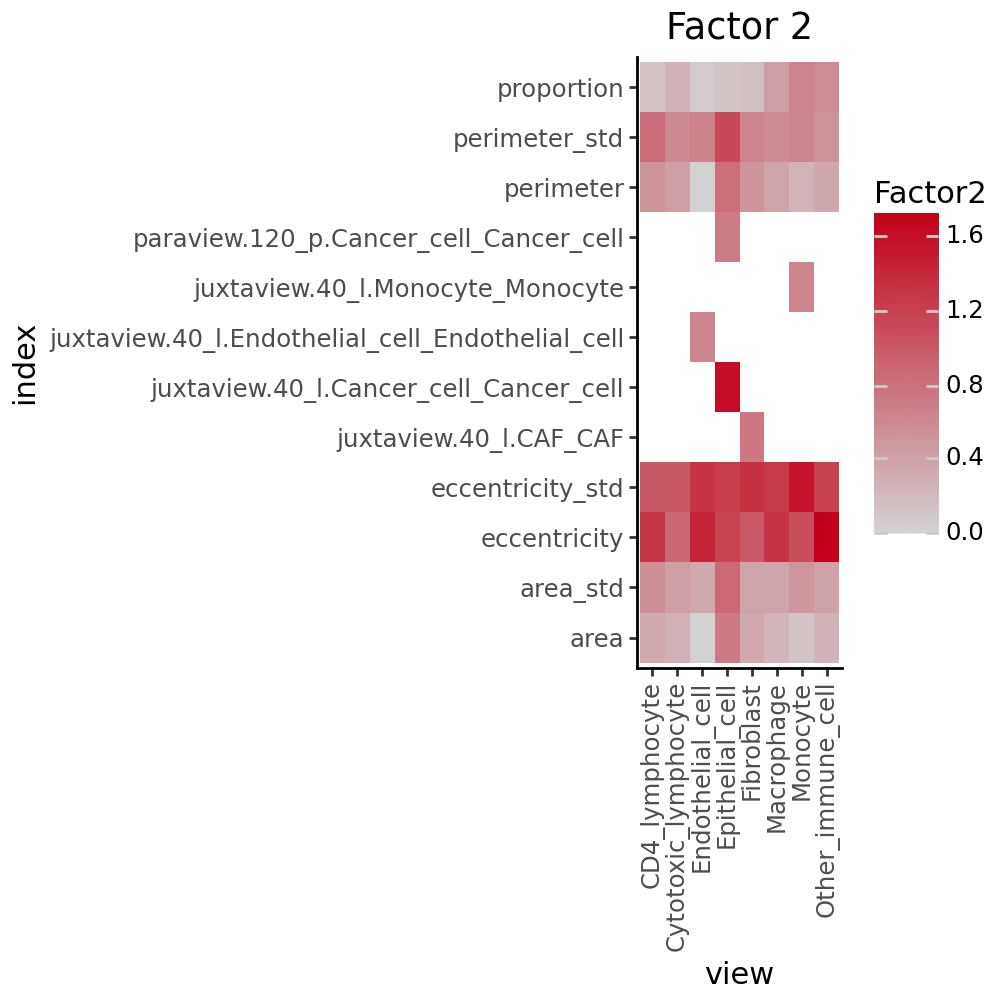

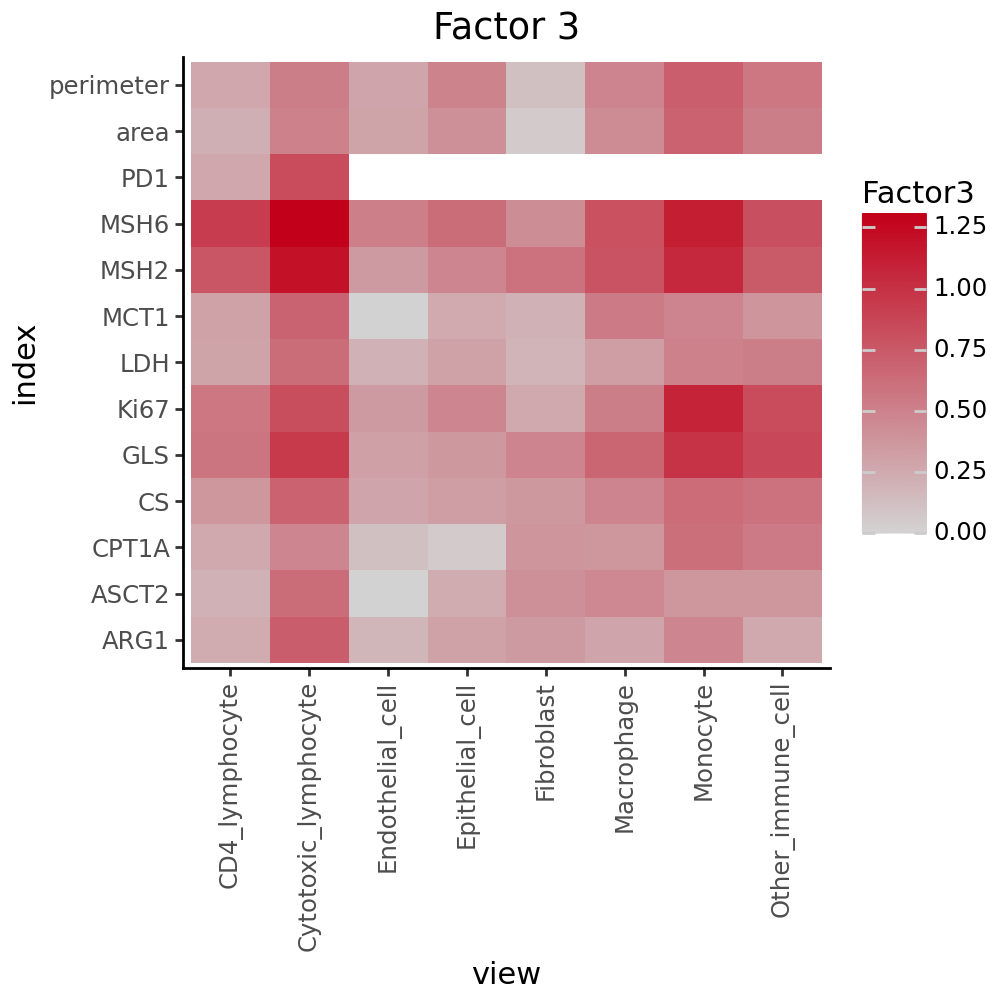

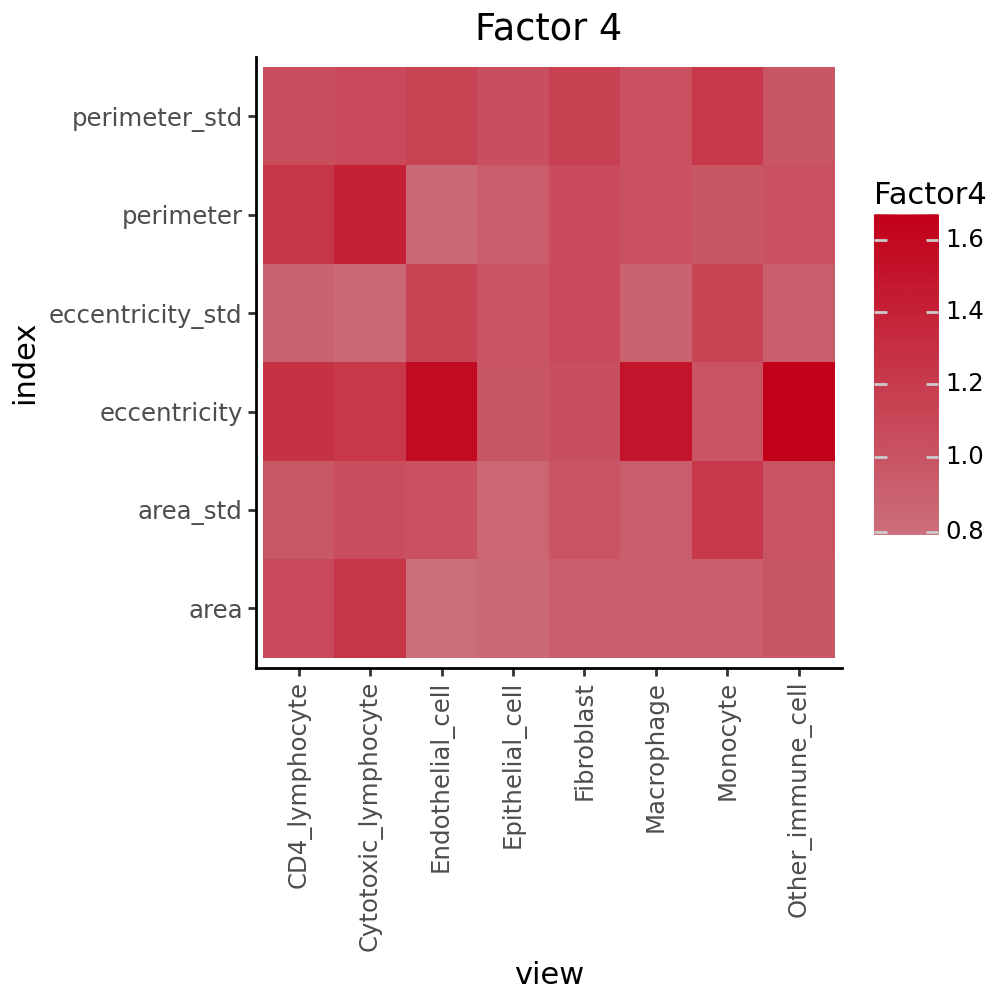

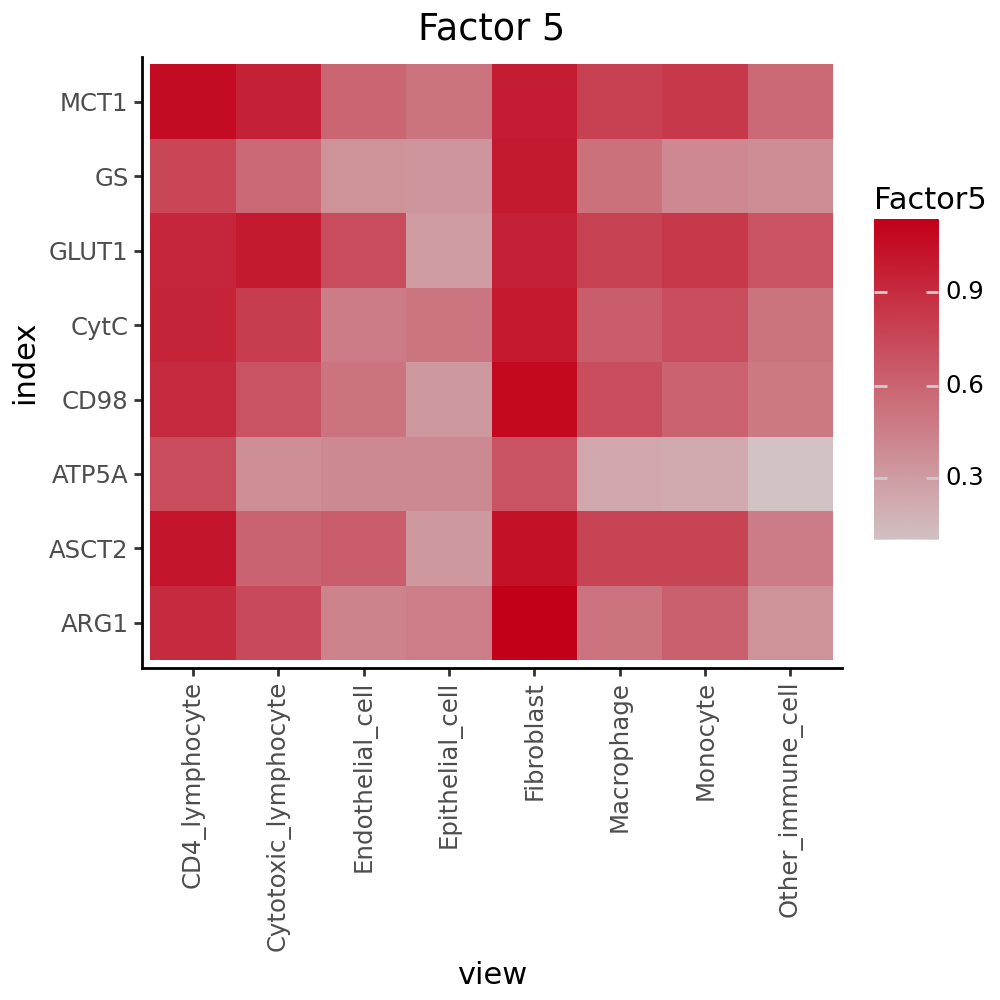

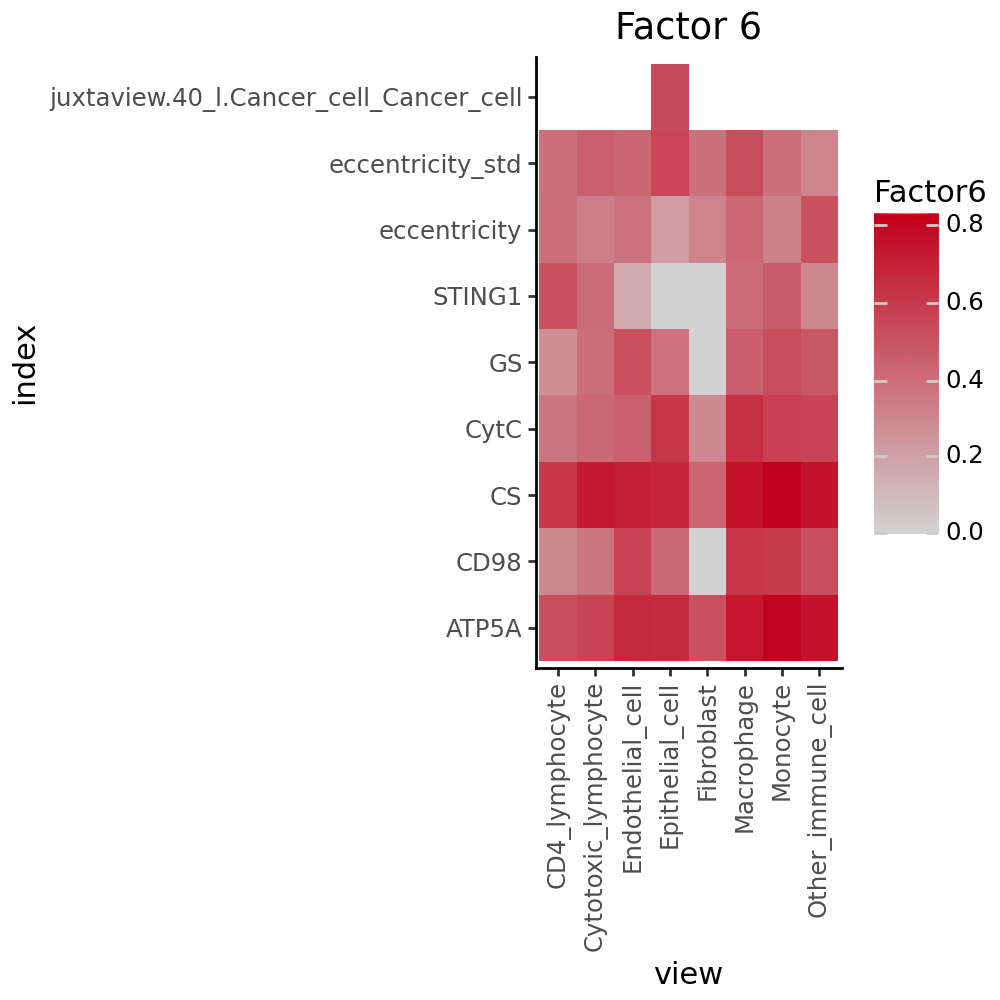

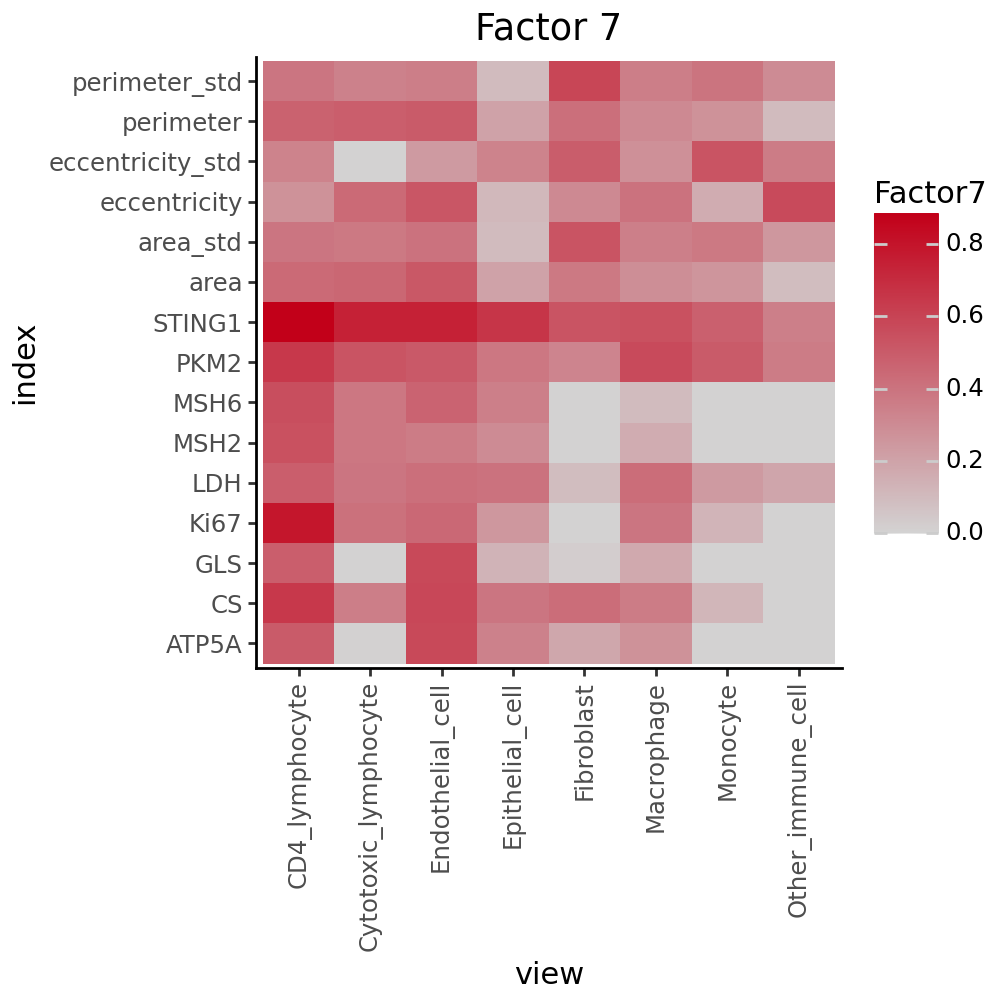

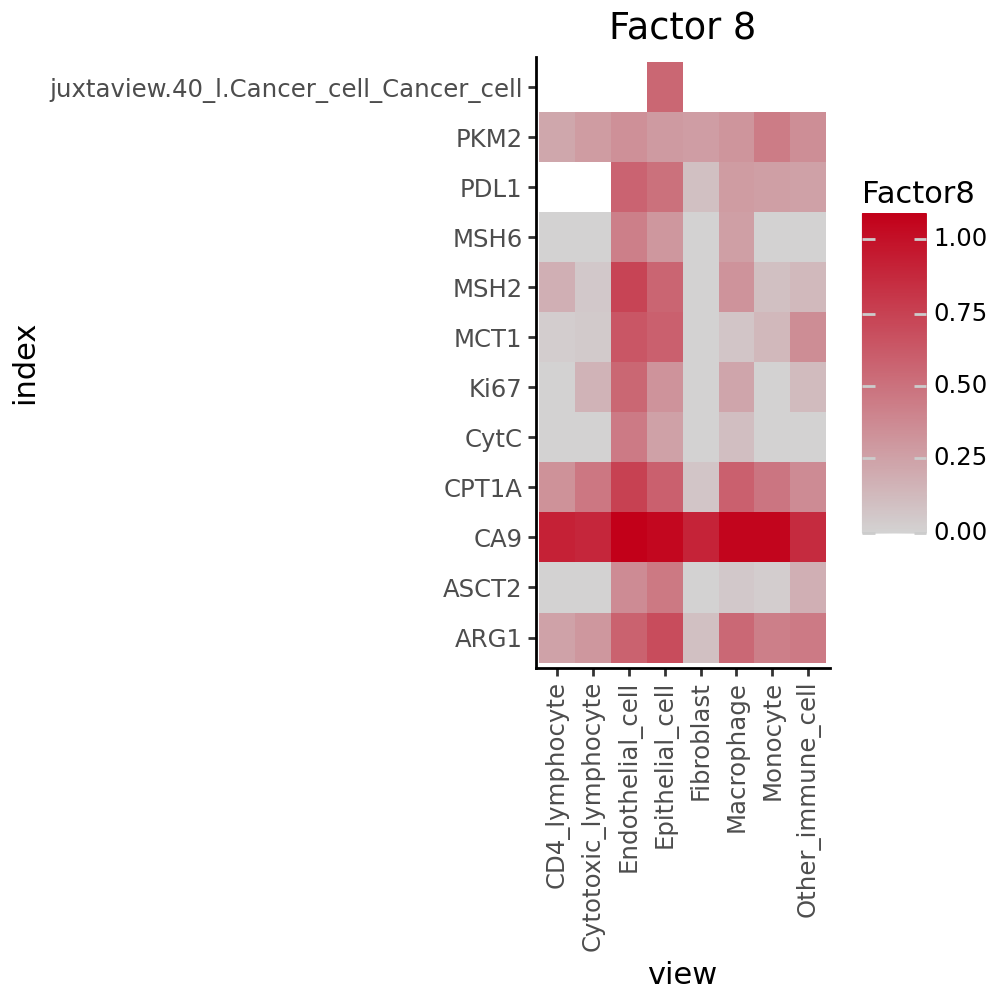

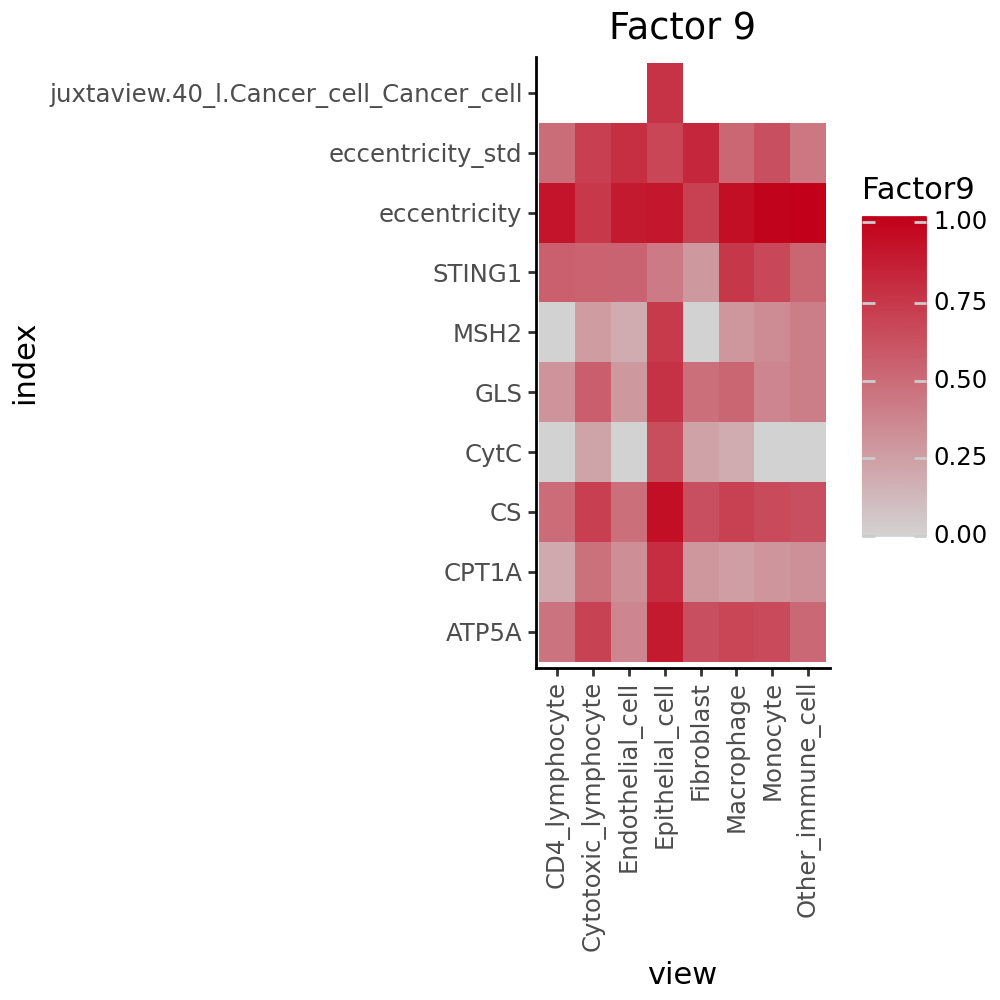

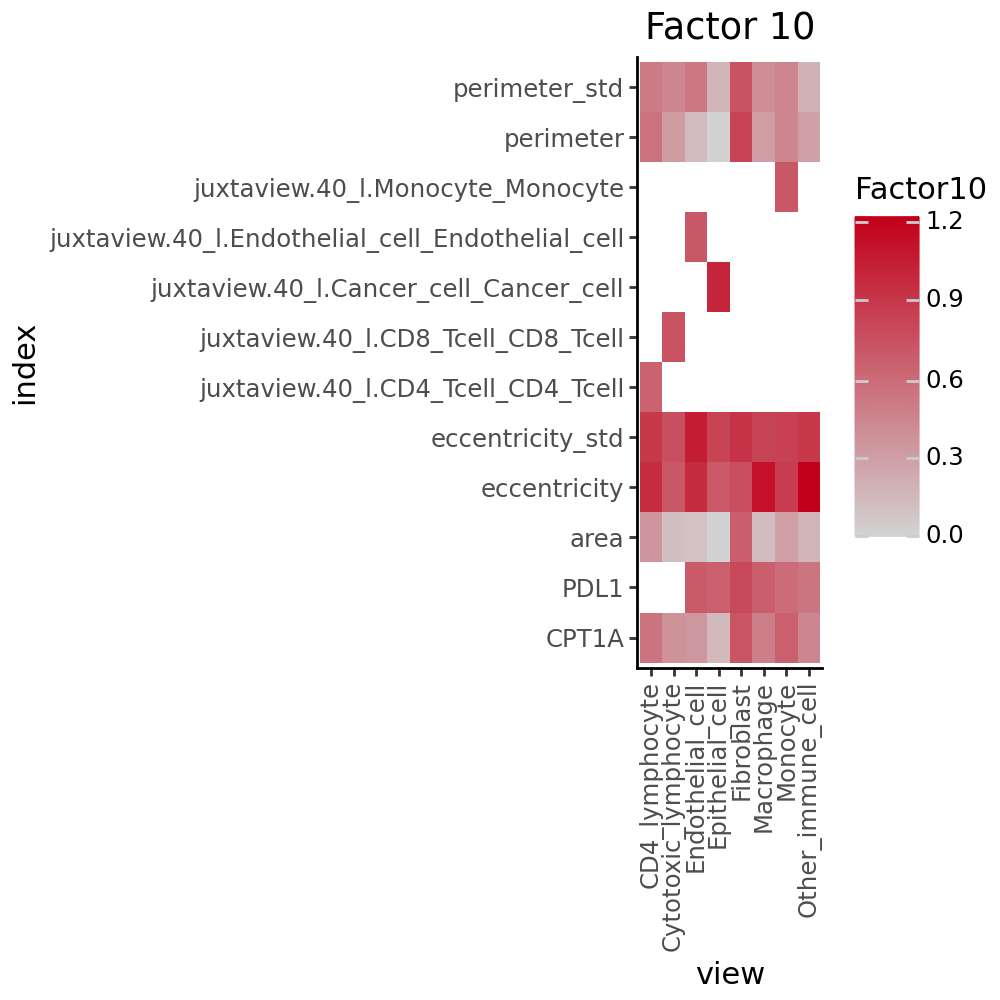

In [38]:
# get top genes with highest absolute loadings across all views
top_genes = variable_loadings['index'].head(30)
top_loadings = variable_loadings[variable_loadings['index'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

for fnum in range(1, top_loadings.shape[1] - 1):
    variable_loadings = variable_loadings.sort_values(by=f'Factor{fnum}', key=lambda x: abs(x), ascending=False) # Default
    top_genes = variable_loadings['index'].head(30)
    top_loadings = variable_loadings[variable_loadings['index'].isin(top_genes)]

    # plot them
    # dotplot of variable, view, loadings
    gp = (ggplot(top_loadings) +
        ggtitle(f"Factor {fnum}") +
        aes(x='view', y='index', fill=f'Factor{fnum}') +
        geom_tile() +
        scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') +
        theme_classic() +
        theme(axis_text_x=element_text(angle=90, hjust=0.5), figure_size=(5, 5))
    )
    gp.show()

In [39]:
features.obsm["X_muvi"] = model.get_factor_scores()

In [40]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(features, obsm_key='X_muvi', obs_keys=['Stage'])
factor_scores.head()

index   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
0   A1a  1.021350  0.870792  0.264196  0.000000  0.220519  0.000000  0.000000   
1   A1c  0.326127  1.001496  0.545405  0.223753  0.823932  0.000000  0.483184   
2   A1d  0.826889  0.810808  0.497021  0.000000  0.955382  0.000000  0.000000   
3   A1e  0.648829  0.465366  0.870853  0.027419  0.509341  0.576239  0.000000   
4   A1f  0.619995  0.776029  0.839639  0.000000  0.725460  0.000000  0.000000   

    Factor8  Factor9  Factor10 Stage  
0  0.000000      0.0  0.000000   pT3  
1  0.000000      0.0  0.290051   pT4  
2  0.000000      0.0  0.230533   pT3  
3  0.137268      0.0  0.170332   pT4  
4  0.000000      0.0  0.202874   pT1

In [41]:
# Kruksal Wallis test for factor 1 and stage
from scipy.stats import kruskal
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor{fnum}']
    stage = factor_scores['Stage']
    print(kruskal(factor1[stage == 'pT1'], factor1[stage == 'pT2'], factor1[stage == 'pT3'], factor1[stage == 'pT4'], factor1[stage == 'Colon-no.']))
    # Note: multiply by 10 for Bonferroni correction

KruskalResult(statistic=6.100184500946611, pvalue=0.19179031910349106)
KruskalResult(statistic=24.97603829993198, pvalue=5.087101080712289e-05)
KruskalResult(statistic=35.607614360565165, pvalue=3.484581077252267e-07)
KruskalResult(statistic=6.695302644758047, pvalue=0.15289321400003564)
KruskalResult(statistic=11.040463248050534, pvalue=0.02611300733265282)
KruskalResult(statistic=6.668125742727332, pvalue=0.1545005748699339)
KruskalResult(statistic=7.036020536782818, pvalue=0.13399690483094595)
KruskalResult(statistic=1.785994288414707, pvalue=0.7750437647422059)
KruskalResult(statistic=27.015213995679137, pvalue=1.9738611508045575e-05)
KruskalResult(statistic=10.315013871294504, pvalue=0.03544280678136664)


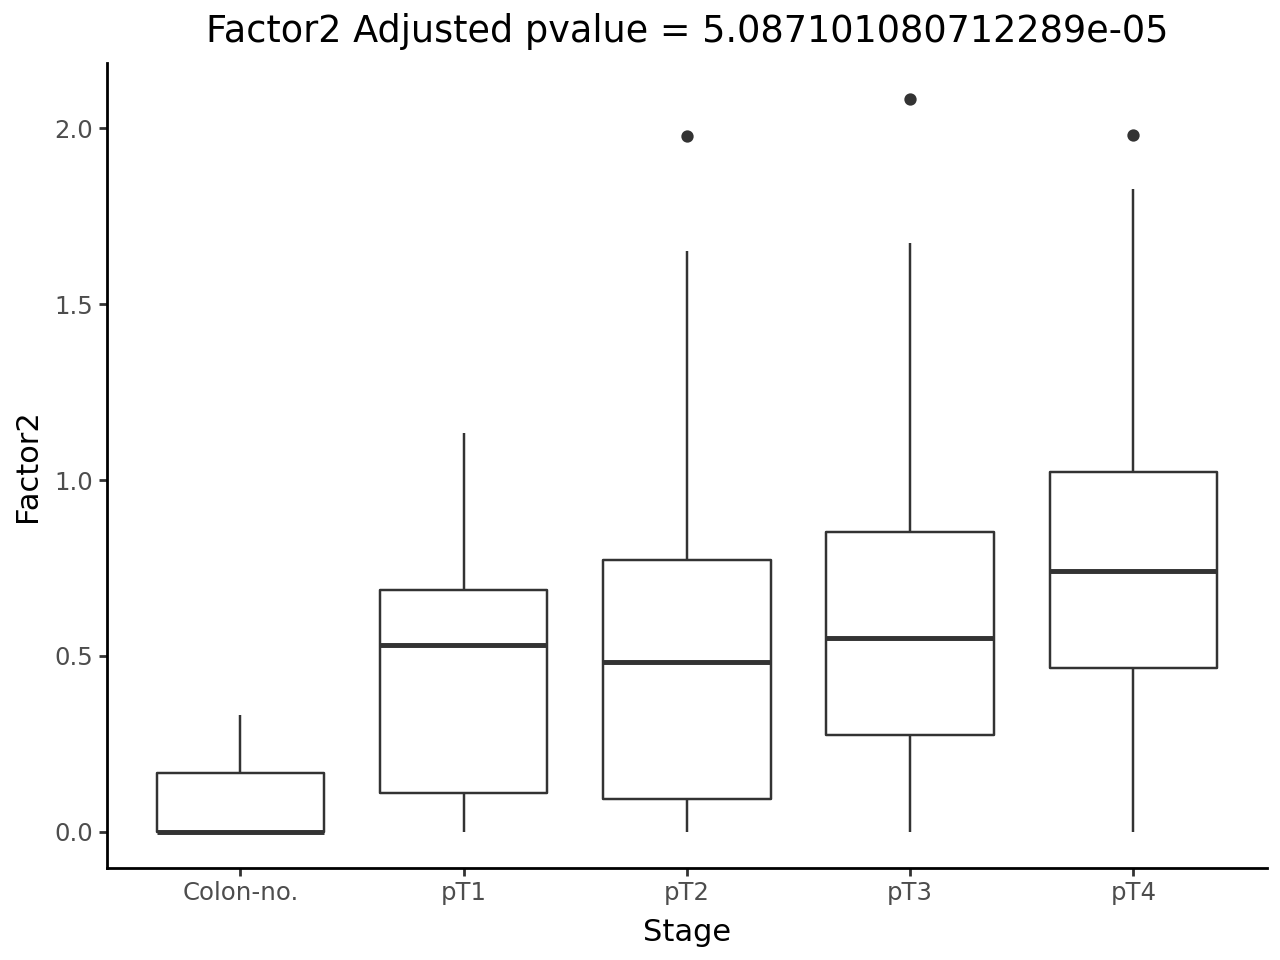

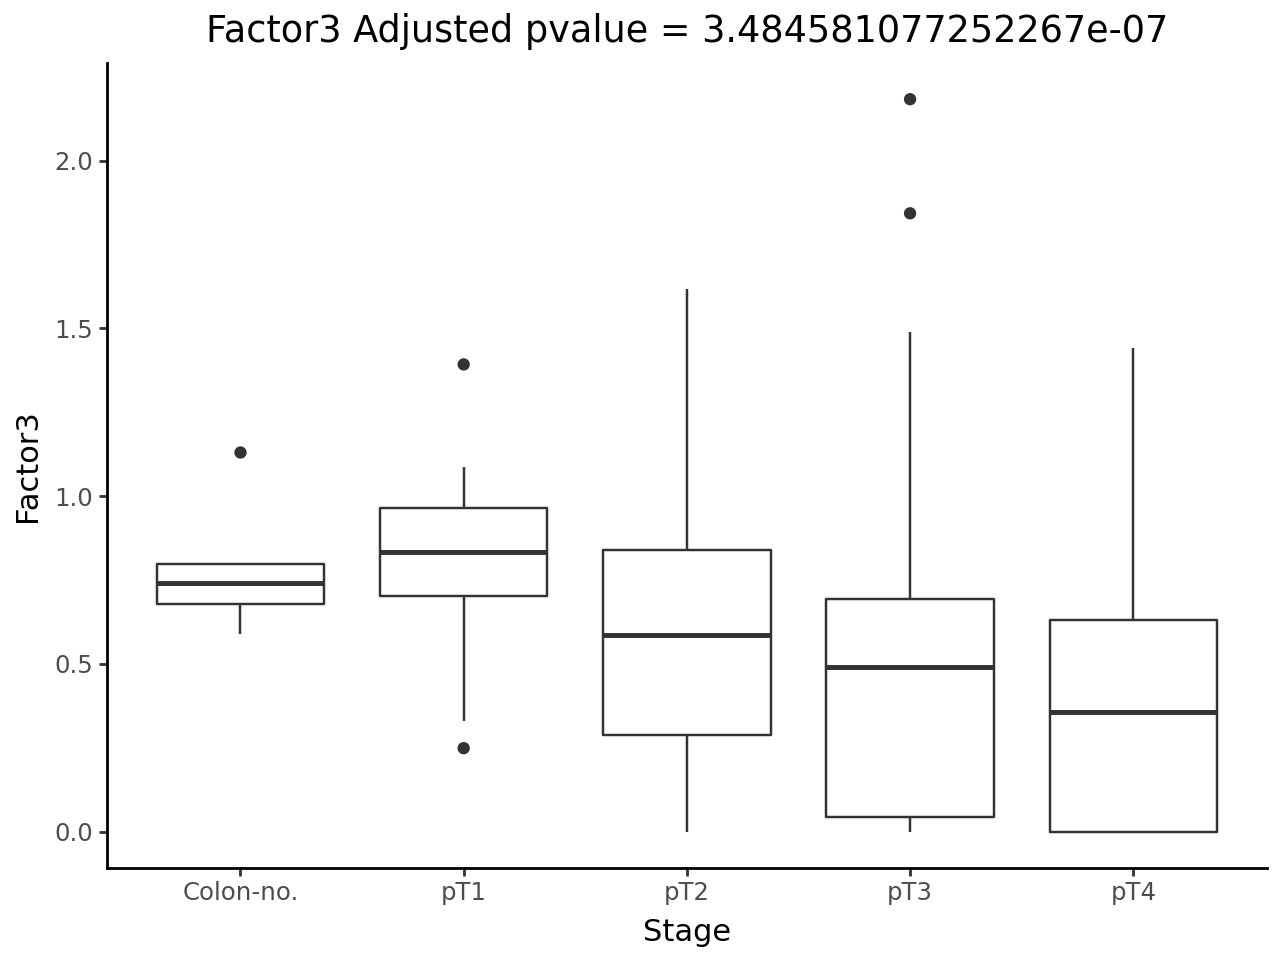

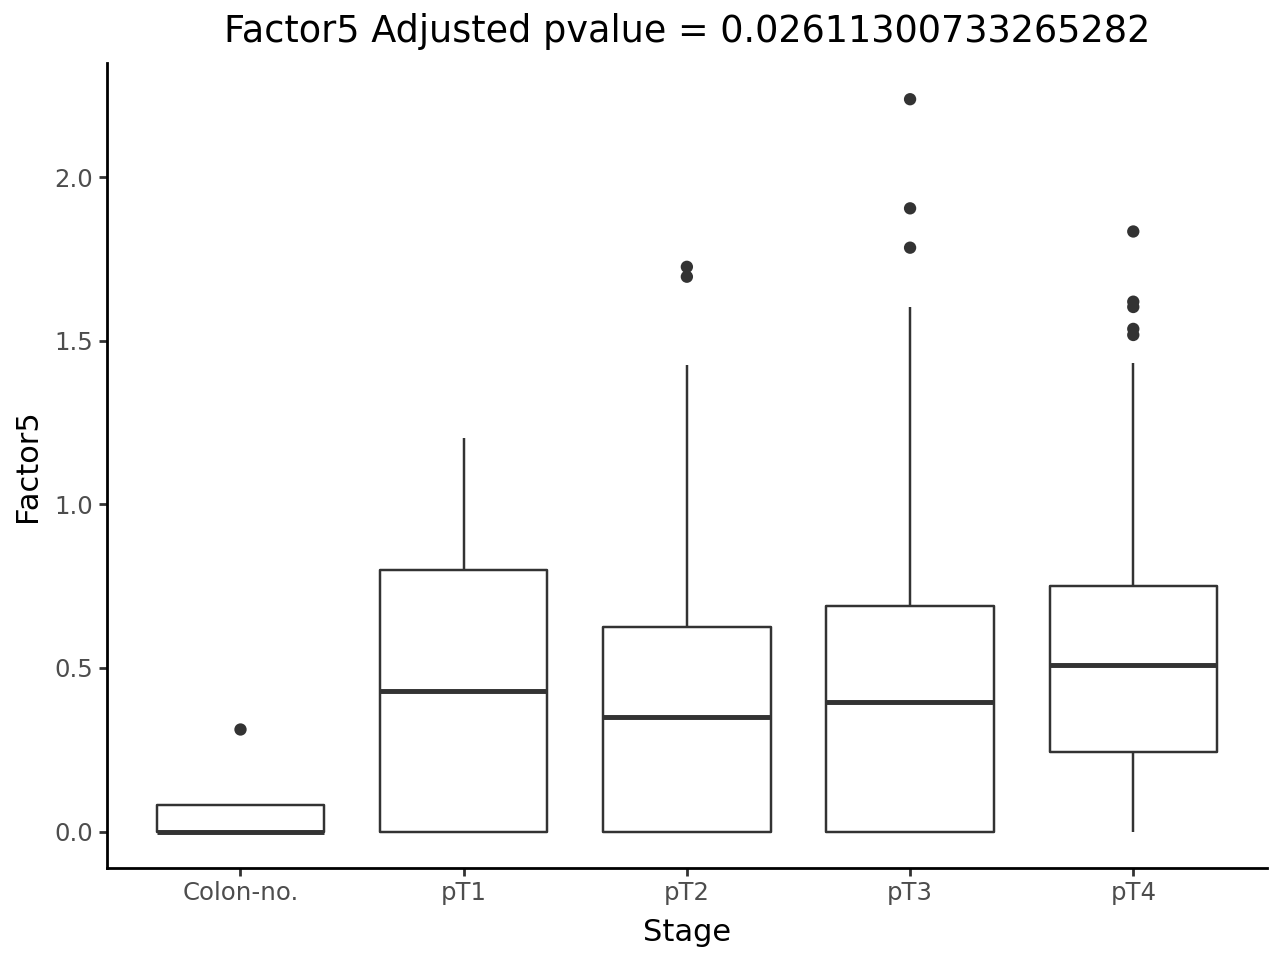

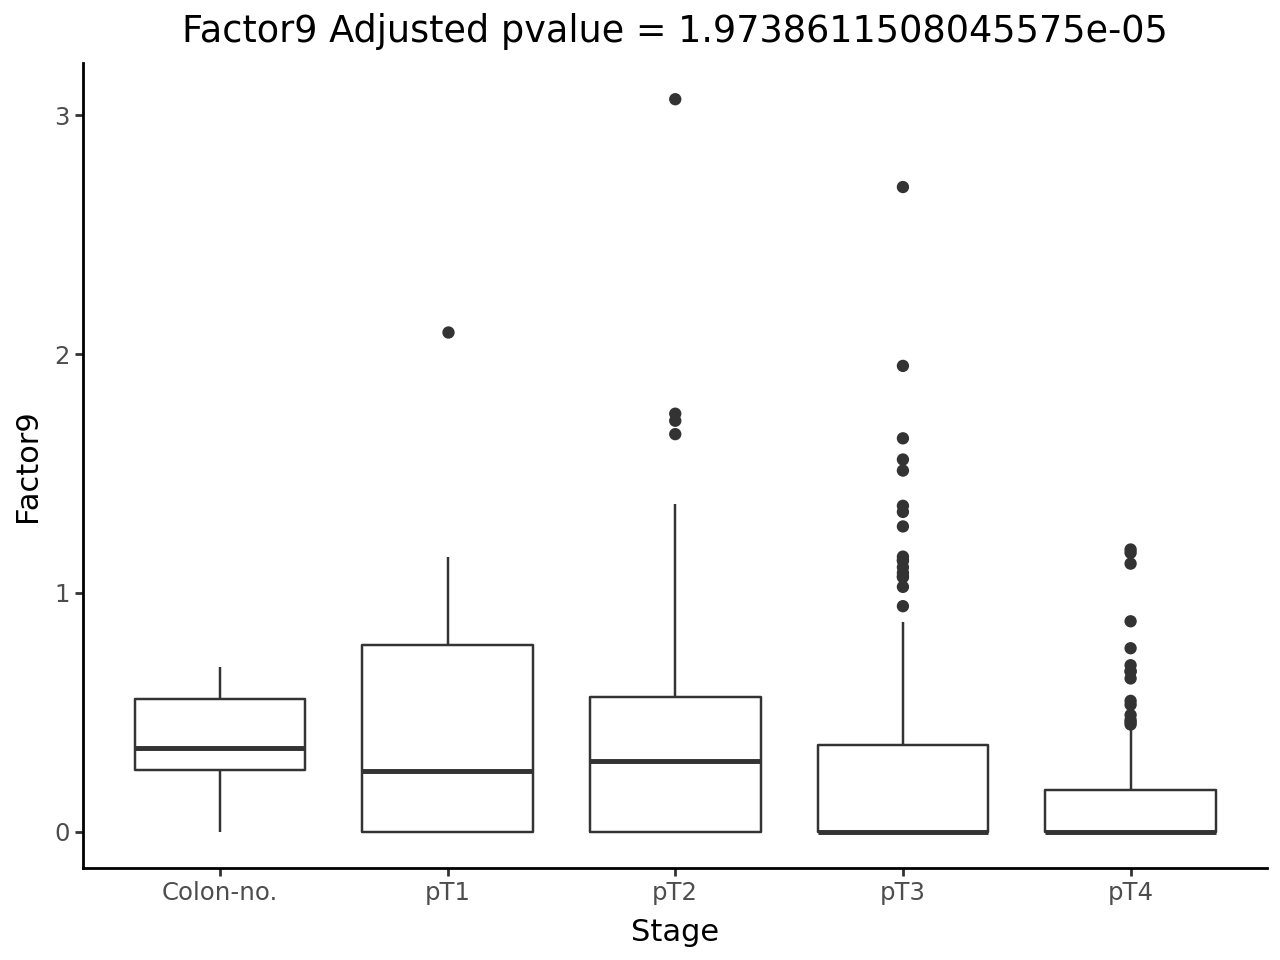

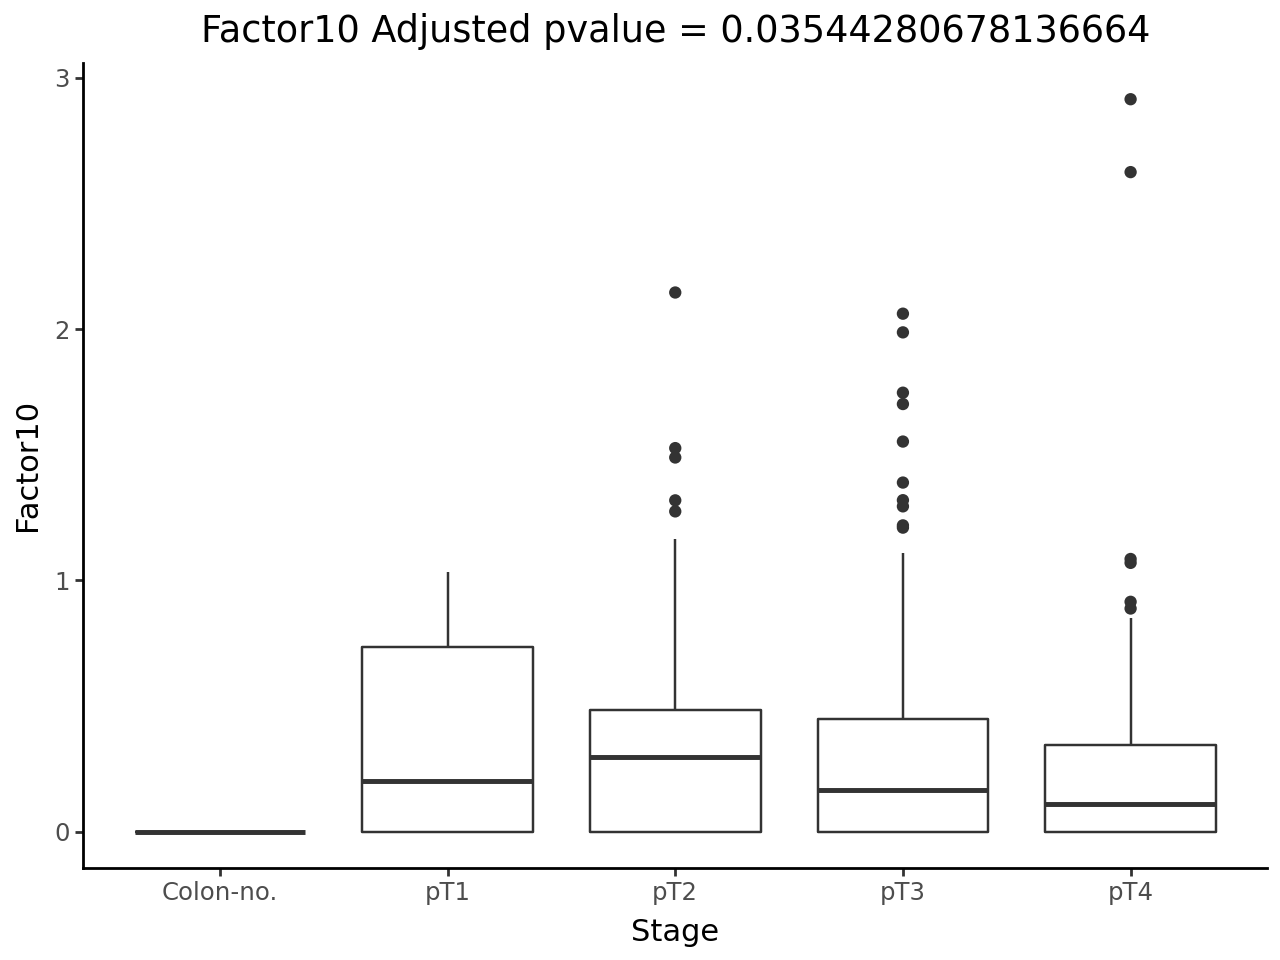

In [42]:
# Factors are associated with disease stage
for f in ["Factor2", "Factor3", "Factor5", "Factor9", "Factor10"]:
    gp = ggplot(factor_scores, aes(y=f, x='Stage')) + \
            geom_boxplot() + theme_classic() + \
            ggtitle(f + " Adjusted pvalue = " + str(kruskal(factor_scores[f][factor_scores['Stage'] == 'pT1'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT2'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT3'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT4'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'Colon-no.'])[1]))
    gp.show()

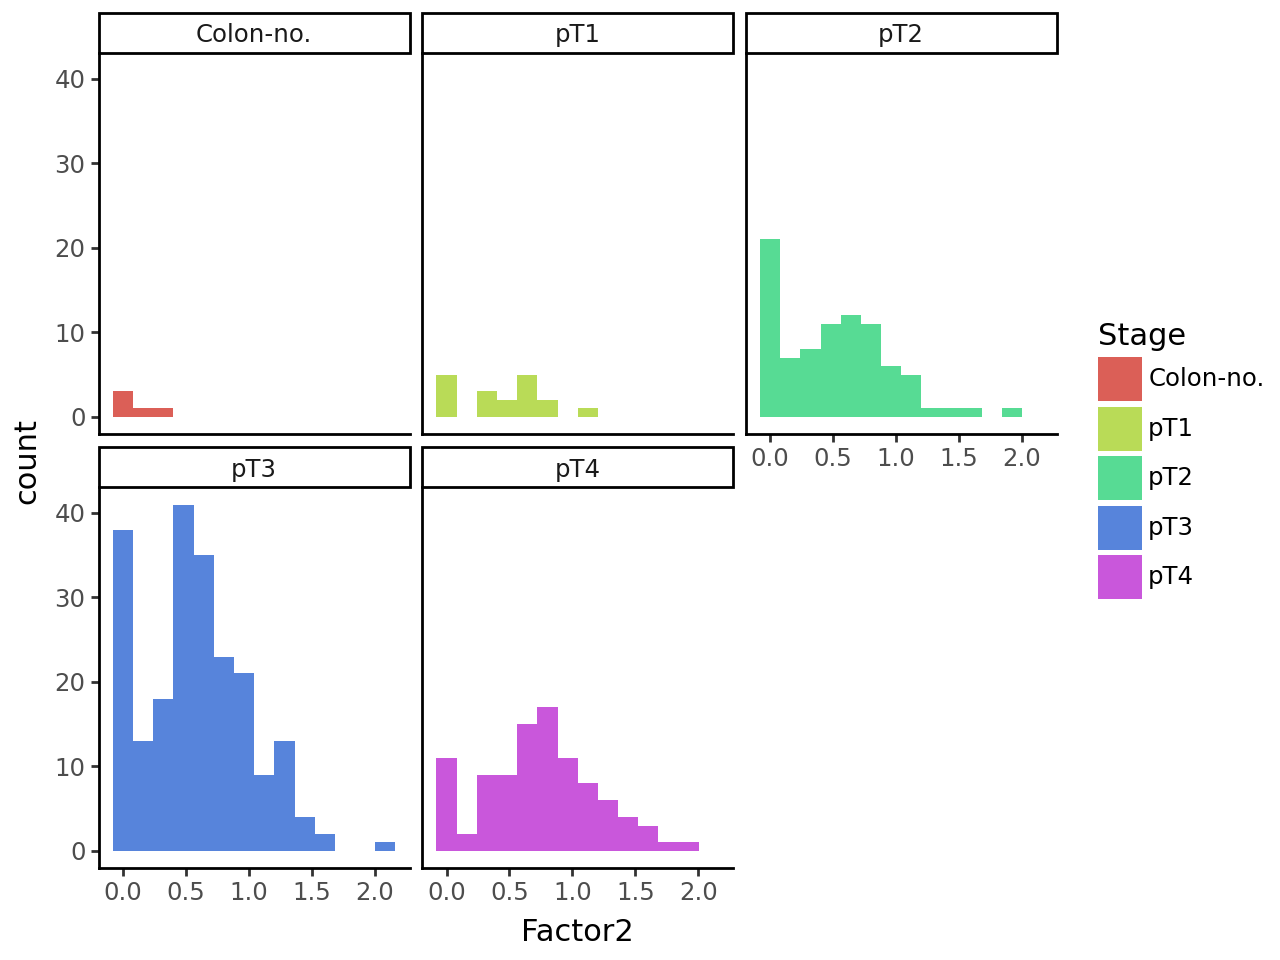

In [43]:
ggplot(factor_scores, aes(x='Factor2', fill='Stage')) + geom_histogram() + facet_wrap('~Stage') + theme_classic()

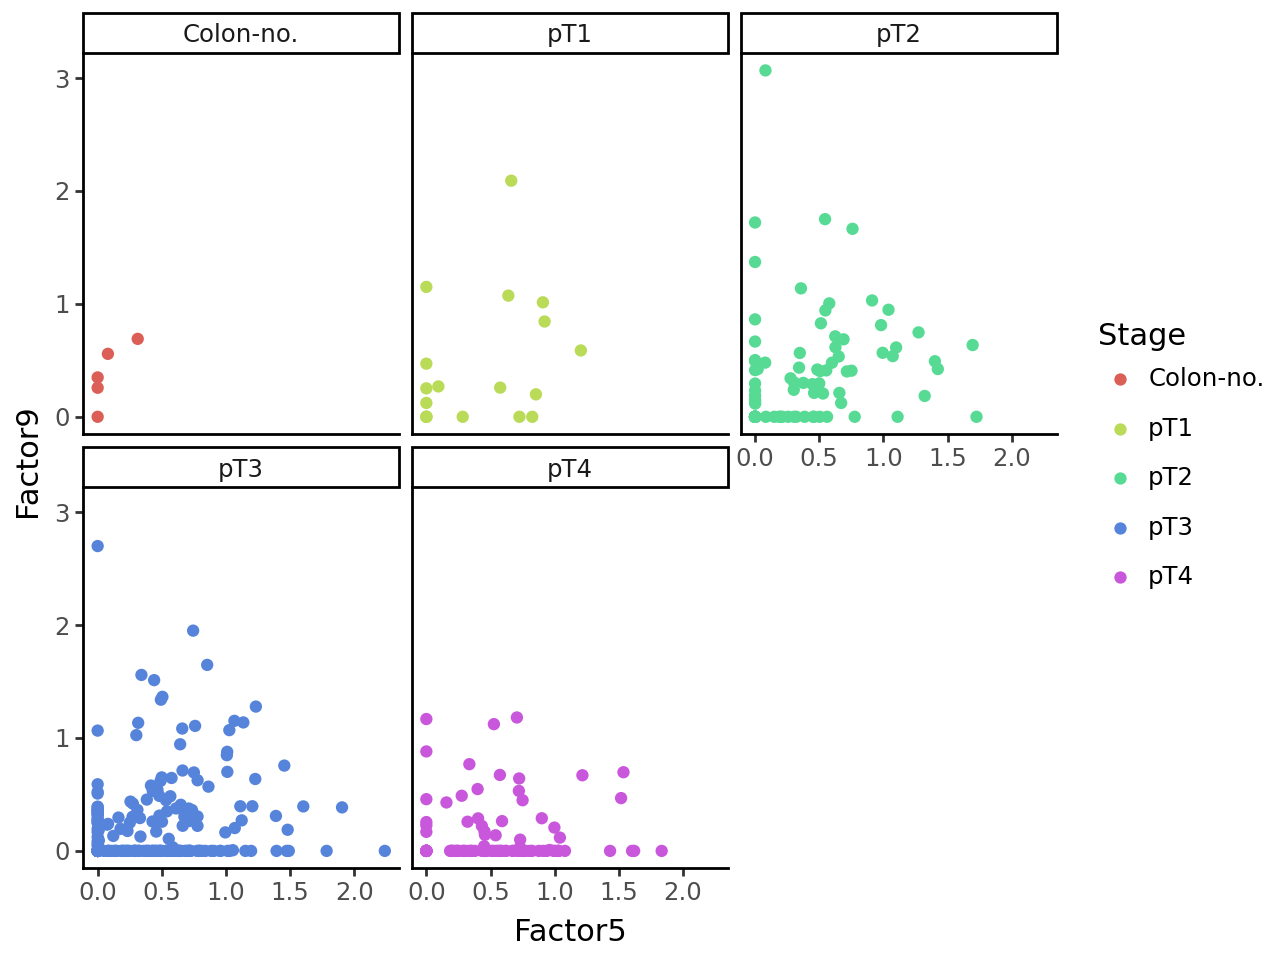

In [44]:
ggplot(factor_scores, aes(x='Factor5', y='Factor9', color='Stage')) + geom_point() + facet_wrap('~Stage') + theme_classic()

In [6]:
# Try again without enforcing non-negativity
model = muvi.tl.from_mdata(
    features,
    n_factors=10,
    nmf=False,
    device=device,
)
model

2025-08-13 14:02:23,924 - muvi.core.models - WARNING - No view names provided!
2025-08-13 14:02:23,924 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2025-08-13 14:02:23,926 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - Storing the index of the view `CD4_lymphocyte` as sample names.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,927 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,928 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,928 - muvi.core.models - INFO - pd.DataFrame detected.
2025-08-13 14:02:23,928 - muvi.core.models - INFO - pd.DataFrame detected.
2

|=================================================================================================================================================================================================================|
|                                                                                               MuVI version 0.2.0                                                                                                |
|=================================================================================================================================================================================================================|
| Parameter        | Value                                                                                                                                                                                        |
|------------------|------------------------------------------------------------------------------------------------------------------------------------

In [7]:
model.fit(seed=0)

2025-08-13 14:02:25,020 - muvi.core.models - INFO - Using 2 particles in parallel.
2025-08-13 14:02:25,020 - muvi.core.models - INFO - Preparing model and guide...
2025-08-13 14:02:25,020 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2025-08-13 14:02:25,042 - muvi.core.models - INFO - Preparing optimizer...
2025-08-13 14:02:25,042 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2025-08-13 14:02:25,042 - muvi.core.models - INFO - Preparing SVI...
2025-08-13 14:02:25,042 - muvi.core.models - INFO - Preparing training data...
2025-08-13 14:02:25,044 - muvi.core.models - INFO - Using complete dataset.
2025-08-13 14:02:25,044 - muvi.core.models - INFO - Setting training seed to `0`.
2025-08-13 14:02:25,044 - muvi.core.models - INFO - Cleaning parameter store.
2025-08-13 14:02:25,045 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2025-08-13 14:02:25,369 - root - INFO - Guessed max_plate_nesting = 3


 10%|█         | 1022/10000 [00:39<05:47, 25.85it/s, ELBO=376]

Relative improvement of -0.0007555 < 1e-05 for 10 step(s) in a row, stopping early.
2025-08-13 14:03:04,588 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [8]:
# Macro R2
np.mean(list(muvi.tl.variance_explained(model)[0].values()))

2025-08-13 14:03:04,592 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


0.39984408766031265

from time import ctime
def r2_for_k(k):
    print(ctime(), k)
    model = muvi.tl.from_mdata(
        features,
        n_factors=k,
        nmf=False,
        device=device,
    )
    model.fit(seed=0)
    return np.mean(list(muvi.tl.variance_explained(model)[0].values()))

df_r2 = pd.DataFrame({
    "k": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25,28,32,36,40,45,50,55,60,70,80,90,100],
    "r2": [r2_for_k(k) for k in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25,28,32,36,40,45,50,55,60,70,80,90,100]]
})

gp = ggplot(df_r2, aes(x='k', y='r2')) + geom_point() + geom_line() + theme_classic()
ggsave(gp, "r2_vs_k.png")
df_r2.to_csv("r2_vs_k.csv")
gp

df_r2_large = pd.DataFrame({
    "k": [120,140,170,200,240,280,330,380,430,490,540,600],
    "r2": [r2_for_k(k) for k in [120,140,170,200,240,280,330,380,430,490,540,600]]
})

gp = ggplot(pd.concat([df_r2, df_r2_large]), aes(x='k', y='r2')) + geom_point() + geom_line() + theme_classic()
ggsave(gp, "r2_vs_k.png")
pd.concat([df_r2, df_r2_large]).to_csv("r2_vs_k.csv")
gp

df_r2_peak = pd.DataFrame({
    "k": [106,107,108,109,110,111,112,113,114],
    "r2": [r2_for_k(k) for k in [106,107,108,109,110,111,112,113,114]]
})

gp = ggplot(df_r2_peak, aes(x='k', y='r2')) + geom_point() + geom_line() + theme_classic()
gp

In [9]:
import pandas as pd
r2_pool = []
for vn in model.get_factor_loadings().keys():
    # rec = model._mode(model.get_factor_scores() @ model.get_factor_loadings()[vn], model.likelihoods[vn])
    rec = model.get_factor_scores() @ model.get_factor_loadings()[vn]
    print(f"Reconstructed features for {vn}: {rec[:2,:2]}")
    r2 = pd.DataFrame({'x': features[vn].X.flatten(), 
                       'y': rec.flatten()}).corr()
    print(f"R: {r2.iloc[0,1]}")
    print(f"R2: {np.square(r2.iloc[0,1])}")
    r2_pool.append(r2.iloc[0,1])
print(f"Macro R: {np.mean(r2_pool)}")
print(f"Macro R2: {np.mean(np.square(r2_pool))}")

Reconstructed features for CD4_lymphocyte: [[-0.29022096 -0.41089437]
 [-0.39834219 -0.06665512]]
R: 0.6630322579445934
R2: 0.43961177507510585
Reconstructed features for Cytotoxic_lymphocyte: [[-0.2492663  -0.74699196]
 [-0.06726572 -0.32876878]]
R: 0.6611224713386429
R2: 0.4370829221089147
Reconstructed features for Endothelial_cell: [[-0.20455882 -0.6786999 ]
 [-0.52848967 -0.58083898]]
R: 0.658671874739922
R2: 0.43384863857340344
Reconstructed features for Epithelial_cell: [[ 0.79692479 -0.81108607]
 [ 0.4030073  -0.29337117]]
R: 0.5448674210164963
R2: 0.29688050648516784
Reconstructed features for Fibroblast: [[-0.0886217  -0.74227411]
 [-0.31226788 -0.10553069]]
R: 0.6149409212137117
R2: 0.3781523365831684
Reconstructed features for Macrophage: [[-0.72414957 -0.66595336]
 [ 0.01765638 -0.34546253]]
R: 0.621121354139405
R2: 0.3857917365679681
Reconstructed features for Monocyte: [[-0.39024563 -0.80350103]
 [ 0.19523509 -0.28595259]]
R: 0.6662069552025741
R2: 0.4438317071602846
Rec

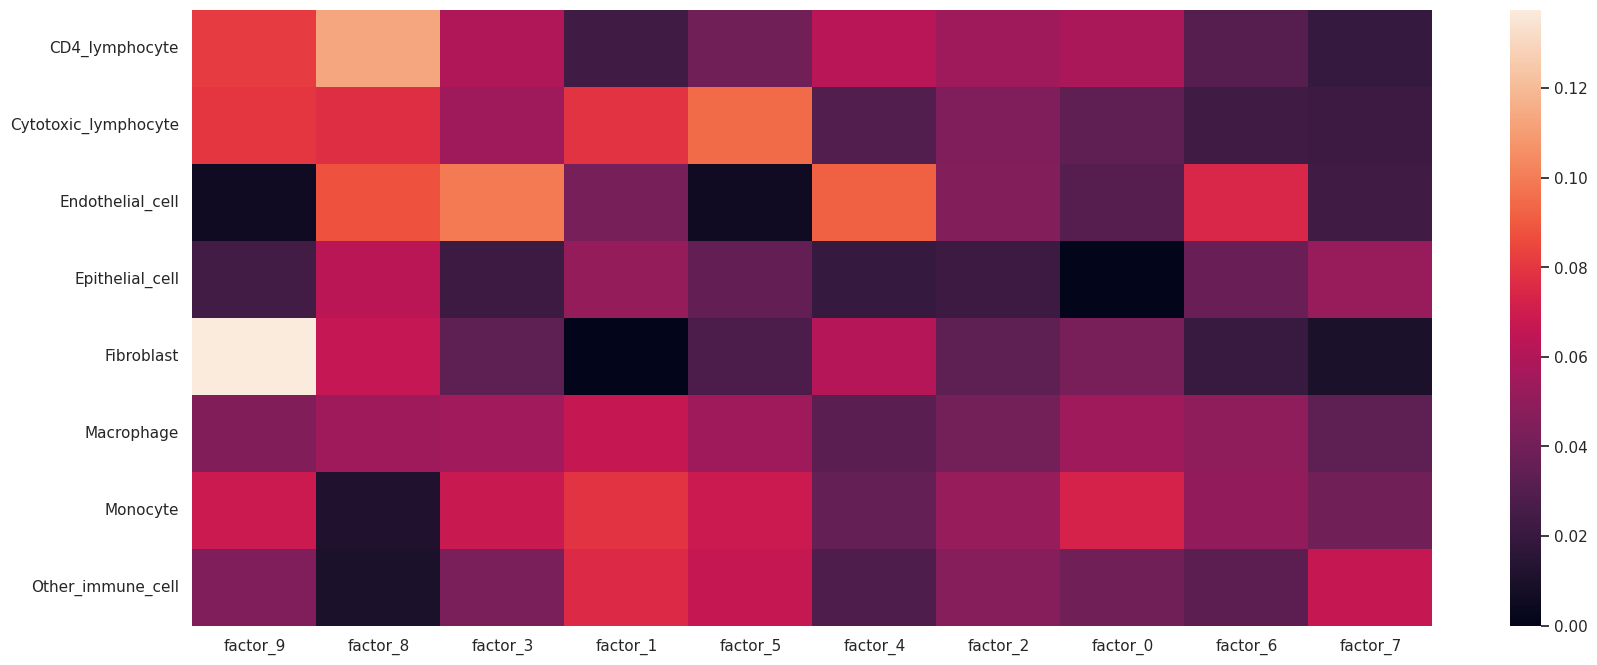

<Axes: >

In [10]:
# muvi.pl.variance_explained(model, show = False, save = "muvi_variance_explained.pdf")
muvi.pl.variance_explained(model)

In [11]:
mod_vars = muvi.tl.variance_explained(model)[1]
factor_order = mod_vars.index.to_list()
mod_vars = pd.melt(mod_vars, ignore_index = False).reset_index().rename(columns = {"variable": "Cell_type", "value": "Variance", "index": "Factor"})
mod_vars.Factor = [f"Factor {int(x.split('_')[1])+1}" for x in mod_vars.Factor]
factor_order = [f"Factor {int(x.split('_')[1])+1}" for x in factor_order]
mod_vars.Factor = pd.Categorical(mod_vars.Factor, categories=factor_order, ordered=True)
mod_vars.Cell_type = [x[3:] for x in mod_vars.Cell_type]

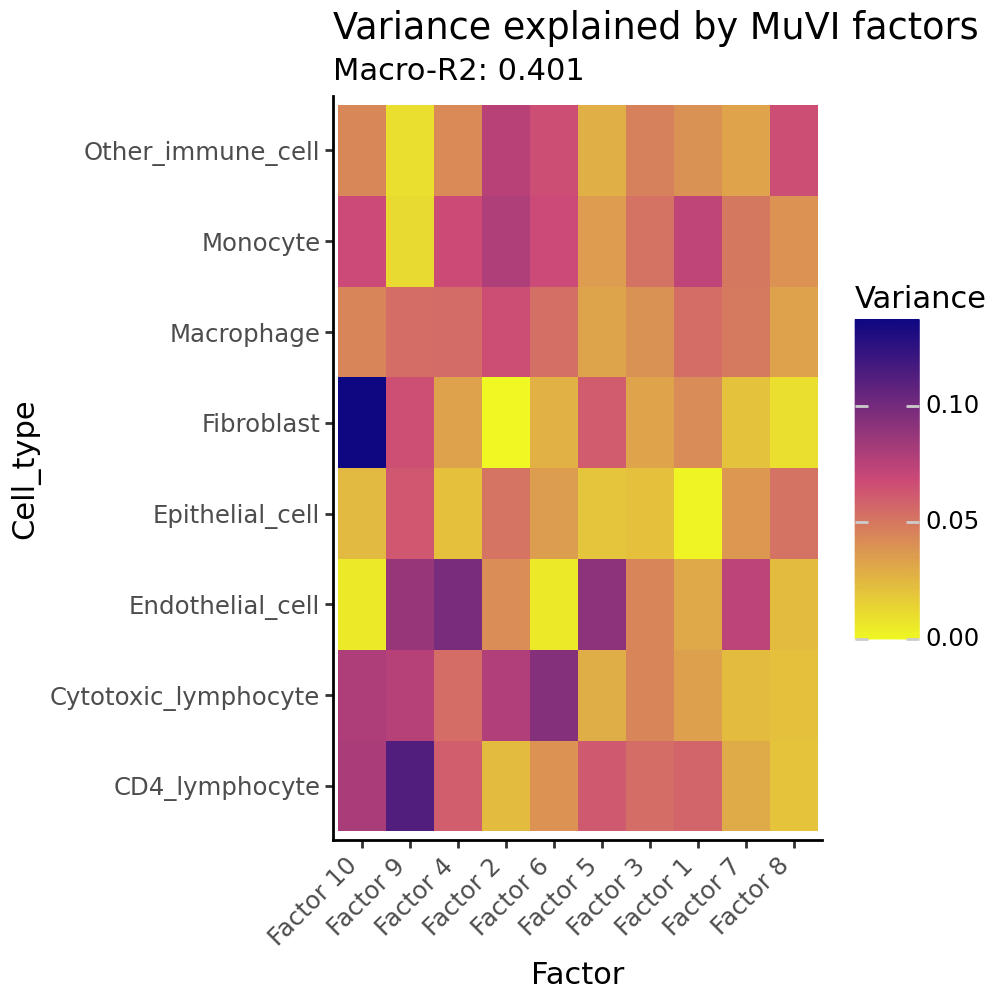

In [12]:
gp = (ggplot(mod_vars, aes(x = "Factor", y = "Cell_type"))
    + geom_tile(aes(fill = "Variance"))
    + theme_classic()
    # Use reverted plasma color palette
    + scale_fill_gradientn(colors = ["#EFF822", "#CC4977","#0F0782"])
    + theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(5, 5))
    + labs(title = "Variance explained by MuVI factors", subtitle=f"Macro-R2: {str(np.round(np.mean(np.square(r2_pool)),3))}")
)
gp.show()

# ggsave(gp, filename="../../figures/fig5/muvi_variance_explained.pdf", width=7, height=5, dpi=300)
# ggsave(gp, filename="../../figures/fig5/muvi_variance_explained.png", width=7, height=5, dpi=300)

/tmp/ipykernel_593914/646713025.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


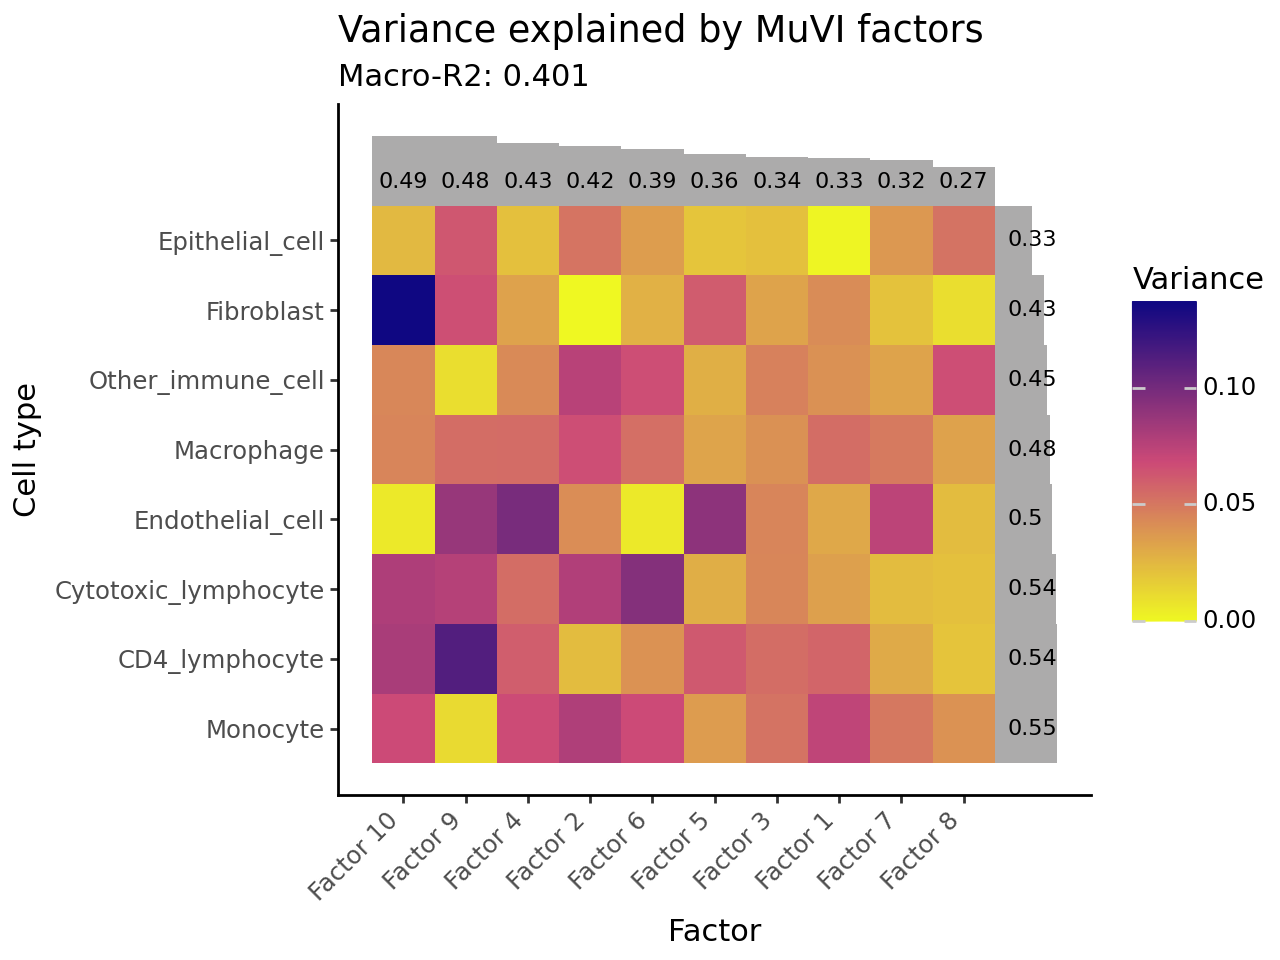

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/muvi_variance_explained.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/muvi_variance_explained.png


In [13]:
# --- Marginal bar heatmap with bars touching the heatmap ---

# Compute marginals
row_sums = mod_vars.groupby("Cell_type")["Variance"].sum().reset_index()
row_sums["Factor"] = "Sum"
col_sums = mod_vars.groupby("Factor")["Variance"].sum().reset_index()
col_sums["Cell_type"] = "Sum"

# Sort cell types by total variance explained (descending)
sorted_cell_types = row_sums.sort_values("Variance", ascending=False)["Cell_type"].tolist()

# Prepare for plotting
mod_vars_marg = pd.concat([mod_vars, row_sums, col_sums], ignore_index=True)

# Ensure Factor and Cell_type are categorical with "Sum" at the end
factor_levels = list(mod_vars["Factor"].cat.categories) + ["Sum"]
cell_type_levels = sorted_cell_types + ["Sum"]
mod_vars_marg["Factor"] = pd.Categorical(mod_vars_marg["Factor"], categories=factor_levels, ordered=True)
mod_vars_marg["Cell_type"] = pd.Categorical(mod_vars_marg["Cell_type"], categories=cell_type_levels, ordered=True)

# Split for plotting
main_matrix = mod_vars_marg[(mod_vars_marg["Factor"] != "Sum") & (mod_vars_marg["Cell_type"] != "Sum")].copy()
row_bars = mod_vars_marg[(mod_vars_marg["Factor"] == "Sum") & (mod_vars_marg["Cell_type"] != "Sum")].copy()
col_bars = mod_vars_marg[(mod_vars_marg["Cell_type"] == "Sum") & (mod_vars_marg["Factor"] != "Sum")].copy()

# Normalize bar lengths for visual scaling
row_bars['bar_length'] = row_bars['Variance'] / row_bars['Variance'].max()
col_bars['bar_length'] = col_bars['Variance'] / col_bars['Variance'].max()
row_bars['Variance_label'] = row_bars['Variance'].round(2).astype(str)
col_bars['Variance_label'] = col_bars['Variance'].round(2).astype(str)

# Map categories to integer positions for rect plotting
factor_levels_no_sum = factor_levels[:-1]
cell_type_levels_no_sum = cell_type_levels[:-1]
factor_pos = {k: i for i, k in enumerate(factor_levels_no_sum)}
cell_type_pos = {k: i for i, k in enumerate(cell_type_levels_no_sum)}

main_matrix['x'] = main_matrix['Factor'].map(factor_pos)
main_matrix['y'] = main_matrix['Cell_type'].map(cell_type_pos)
col_bars['x'] = col_bars['Factor'].map(factor_pos)
row_bars['y'] = row_bars['Cell_type'].map(cell_type_pos)

# Main heatmap tiles
main_matrix['xmin'] = main_matrix['x'] - 0.5
main_matrix['xmax'] = main_matrix['x'] + 0.5
main_matrix['ymin'] = main_matrix['y'] - 0.5
main_matrix['ymax'] = main_matrix['y'] + 0.5

# Top bars: above the heatmap, aligned with factors, grow upward from heatmap edge
col_bars['xmin'] = col_bars['x'] - 0.5
col_bars['xmax'] = col_bars['x'] + 0.5
col_bars['ymin'] = len(cell_type_levels_no_sum) - 0.5
col_bars['ymax'] = col_bars['ymin'] + col_bars['bar_length']

# Right bars: right of the heatmap, aligned with cell types, grow rightward from heatmap edge
row_bars['ymin'] = row_bars['y'] - 0.5
row_bars['ymax'] = row_bars['y'] + 0.5
row_bars['xmin'] = len(factor_levels_no_sum) - 0.5
row_bars['xmax'] = row_bars['xmin'] + row_bars['bar_length']

gp = (
    ggplot()
    + geom_rect(main_matrix, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='Variance'))
    + geom_rect(col_bars, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'), fill='#acabab')
    + geom_text(
        col_bars,
        aes(x='x', y=main_matrix.ymax.max() + 0.2, label='Variance_label'),
        va='bottom', size=8
    )
    + geom_rect(row_bars, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'), fill='#acabab')
    + geom_text(
        row_bars,
        aes(x=main_matrix.xmax.max() + 0.2, y='y', label='Variance_label'),
        ha='left', size=8
    )
    + scale_fill_gradientn(colors=["#EFF822", "#CC4977", "#0F0782"])
    + scale_x_continuous(
        breaks=list(range(len(factor_levels_no_sum))),
        labels=factor_levels_no_sum,
    )
    + scale_y_continuous(
        breaks=list(range(len(cell_type_levels_no_sum))),
        labels=cell_type_levels_no_sum,
    )
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
    )
    + labs(
        title="Variance explained by MuVI factors",
        subtitle=f"Macro-R2: {str(np.round(np.mean(np.square(r2_pool)),3))}",
        x="Factor",
        y="Cell type"
    )
)
gp.show()

ggsave(gp, filename="../../figures/fig5/muvi_variance_explained.pdf", width=7, height=5, dpi=300)
ggsave(gp, filename="../../figures/fig5/muvi_variance_explained.png", width=7, height=5, dpi=300)

group_wise_r2 = (
        metadata.groupby(metadata)
        .apply(
            lambda group_df: variance_explained(
                model,
                sample_idx=group_df.index,
                factor_idx=factor_idx,
                cache=False,
                sort=False,
                **kwargs,
            )[1].copy()
        )
        .reset_index()
    )

for v, f in {'Macrophage': ['juxtaview.40_l.CD163_Macrophage_CD163_Macrophage', 'paraview.120_p.CD163_Macrophage_CD68_Macrophage'], 
             'Monocyte': ['juxtaview.40_l.Monocyte_Monocyte', 'paraview.120_p.Monocyte_CD68_Macrophage'],
             'Fibroblast': ['juxtaview.40_l.CAF_CD4_Tcell', 'paraview.120_p.CAF_Cancer_cell']}.items():
    r2 = muvi.tl.variance_explained(
        model,
        view_idx=v,
        feature_idx=f
    )
    print(f'R2 for {view}:', r2)

model.get_observations(
        view_idx = 'Macrophage', feature_idx=['juxtaview.40_l.CD163_Macrophage_CD163_Macrophage', 'paraview.120_p.CD163_Macrophage_CD68_Macrophage', 'Not-here', 'juxtaview.40_l.CAF_CD4_Tcell']
    )

In [14]:
ft_types = {
    "Abundance": ["proportion"],
    "Metabolism": ["CA9", "CD98", "CytC", "MCT1", "ASCT2", "LDH", "GS", "GLS", "ATP5A", "CS", "PKM2", "GLUT1", "ARG1", "CPT1A"],
    "Function": ["Ki67", "PDL1", "STING1", "MSH2", "MSH6", "PD1"],
    "Spatial": [x for x in features.var_names.unique() if 'paraview' in x or 'juxtaview' in x],
    "Morphology": ["eccentricity", "perimeter", "area", "eccentricity_std", "perimeter_std", "area_std"]
}
assert np.sum([len(x) for x in ft_types.values()]) == len(features.var_names.unique())

In [15]:
medr2 = {}
for ft, ff in ft_types.items():
    cumft = []
    factor_order = None
    for v in features.mod.keys():
        r2 = muvi.tl.variance_explained(
            model,
            view_idx=v,
            feature_idx=ff,
            cache=False,
            sort=False
        )
        # Check that the order of the features is constant
        if factor_order is None:
            factor_order = r2[1].index.to_list()
        else:
            assert np.all(factor_order == r2[1].index.to_list())
        # print(f'R2 for {v} and {ft}:', r2[1].values)
        cumft.append(r2[1].values)
    medr2[ft] = np.median(np.hstack(cumft), axis = 1)
    print(f"Median R2 for {ft}: {medr2[ft]}")

Median R2 for Abundance: [ 0.03428909  0.02561561 -0.00012972  0.01587044  0.04452687  0.01371582
  0.0091259   0.01686679  0.00899678  0.00242528]
Median R2 for Metabolism: [0.08971052 0.15915494 0.08533396 0.12371982 0.0901065  0.07554146
 0.0664488  0.07860402 0.02893492 0.06968455]
2025-08-13 14:03:05,372 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,373 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,373 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,374 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,374 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,375 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,376 - muvi.core.index - WARNING - Invalid index, `['PDL1']`, removing...
2025-08-13 14:03:05,376 - muvi.core.index - WARNING - Invalid index,

2025-08-13 14:03:05,380 - muvi.core.index - WARNING - Invalid index, `['PD1']`, removing...
2025-08-13 14:03:05,381 - muvi.core.index - WARNING - Invalid index, `['PDL1']`, removing...
2025-08-13 14:03:05,382 - muvi.core.index - WARNING - Invalid index, `['PDL1']`, removing...
Median R2 for Function: [0.13905929 0.02646479 0.02044356 0.10710605 0.05058319 0.0164445
 0.1211001  0.02252279 0.1754436  0.00445207]
2025-08-13 14:03:05,382 - muvi.core.index - WARNING - Invalid index, `['juxtaview.40_l.CAF_CAF', 'juxtaview.40_l.CAF_Cancer_cell', 'juxtaview.40_l.CAF_CD4_Tcell', 'juxtaview.40_l.CAF_Monocyte', 'juxtaview.40_l.CAF_Other_immune_cell', 'juxtaview.40_l.CAF_CD8_Tcell', 'juxtaview.40_l.CAF_CD163_Macrophage', 'juxtaview.40_l.CAF_CD68_Macrophage', 'paraview.120_p.CAF_CAF', 'paraview.120_p.CAF_Cancer_cell', 'paraview.120_p.CAF_Endothelial_cell', 'paraview.120_p.CAF_CD4_Tcell', 'paraview.120_p.CAF_Monocyte', 'paraview.120_p.CAF_CD163_Macrophage', 'juxtaview.40_l.CD163_Macrophage_CD163_Mac

In [16]:
# Heatmap of R2 for each feature type and factor
ft_r2 = pd.DataFrame(medr2)
ft_r2.index = r2[1].index
factor_order = ft_r2.index.to_list()
ft_r2 = pd.melt(ft_r2, ignore_index = False).reset_index().rename(columns = {"variable": "Feature_type", "value": "Variance", "index": "Factor"})
ft_r2.Factor = [f"Factor {int(x.split('_')[1])+1}" for x in ft_r2.Factor]
factor_order = [f"Factor {int(x.split('_')[1])+1}" for x in factor_order]
ft_r2.Factor = pd.Categorical(ft_r2.Factor, categories=factor_order, ordered=True)

/tmp/ipykernel_593914/3761050274.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


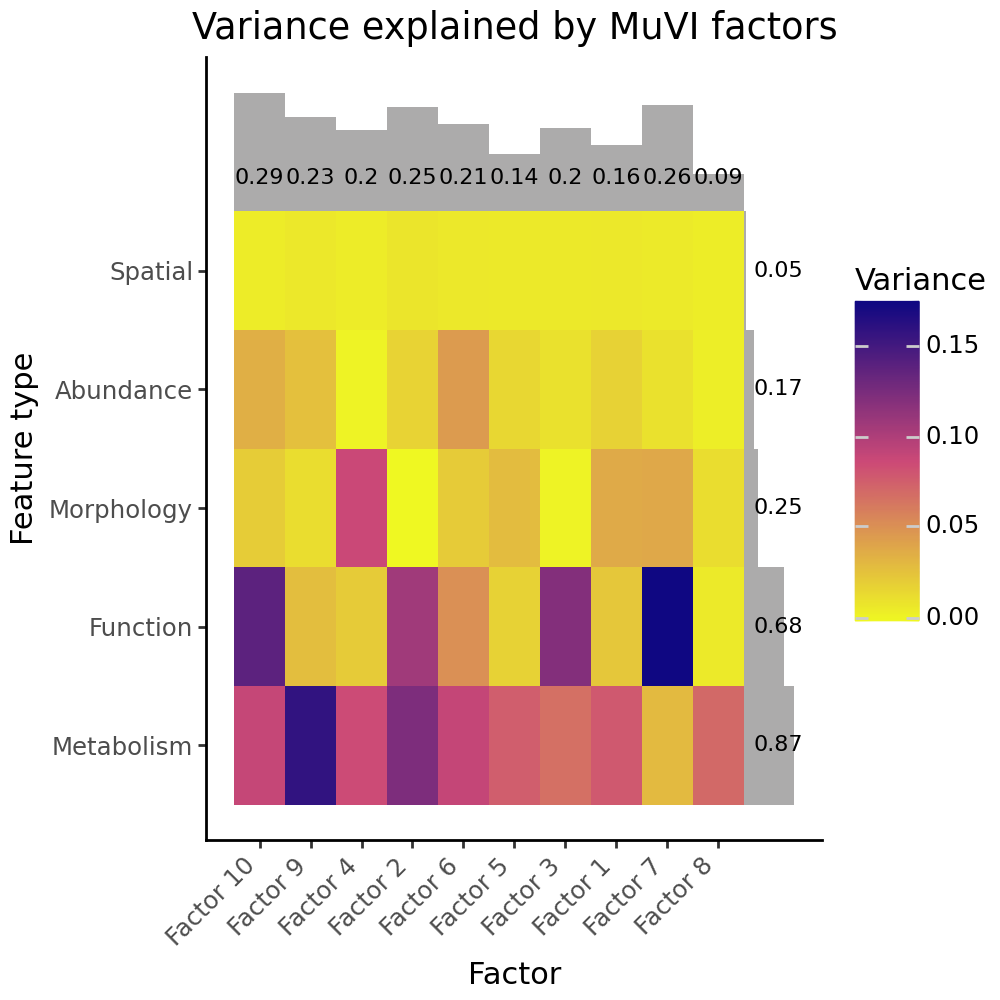

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/muvi_variance_explained_cell_type.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/muvi_variance_explained_cell_type.png


In [17]:
# --- Marginal bar heatmap for feature type vs factor ---

# Compute marginals
row_sums = ft_r2.groupby("Feature_type")["Variance"].sum().reset_index()
row_sums["Factor"] = "Sum"
col_sums = ft_r2.groupby("Factor")["Variance"].sum().reset_index()
col_sums["Feature_type"] = "Sum"

# Sort feature types by total variance explained (descending)
sorted_feature_types = row_sums.sort_values("Variance", ascending=False)["Feature_type"].tolist()

# Prepare for plotting
ft_r2_marg = pd.concat([ft_r2, row_sums, col_sums], ignore_index=True)

# Ensure Factor and Feature_type are categorical with "Sum" at the end
factor_levels = list(ft_r2["Factor"].cat.categories) + ["Sum"]
feature_type_levels = sorted_feature_types + ["Sum"]
ft_r2_marg["Factor"] = pd.Categorical(ft_r2_marg["Factor"], categories=factor_levels, ordered=True)
ft_r2_marg["Feature_type"] = pd.Categorical(ft_r2_marg["Feature_type"], categories=feature_type_levels, ordered=True)

# Split for plotting
main_matrix = ft_r2_marg[(ft_r2_marg["Factor"] != "Sum") & (ft_r2_marg["Feature_type"] != "Sum")].copy()
row_bars = ft_r2_marg[(ft_r2_marg["Factor"] == "Sum") & (ft_r2_marg["Feature_type"] != "Sum")].copy()
col_bars = ft_r2_marg[(ft_r2_marg["Feature_type"] == "Sum") & (ft_r2_marg["Factor"] != "Sum")].copy()

# Normalize bar lengths for visual scaling
row_bars['bar_length'] = row_bars['Variance'] / row_bars['Variance'].max()
col_bars['bar_length'] = col_bars['Variance'] / col_bars['Variance'].max()
row_bars['Variance_label'] = row_bars['Variance'].round(2).astype(str)
col_bars['Variance_label'] = col_bars['Variance'].round(2).astype(str)

# Map categories to integer positions for rect plotting
factor_levels_no_sum = factor_levels[:-1]
feature_type_levels_no_sum = feature_type_levels[:-1]
factor_pos = {k: i for i, k in enumerate(factor_levels_no_sum)}
feature_type_pos = {k: i for i, k in enumerate(feature_type_levels_no_sum)}

main_matrix['x'] = main_matrix['Factor'].map(factor_pos)
main_matrix['y'] = main_matrix['Feature_type'].map(feature_type_pos)
col_bars['x'] = col_bars['Factor'].map(factor_pos)
row_bars['y'] = row_bars['Feature_type'].map(feature_type_pos)

# Main heatmap tiles
main_matrix['xmin'] = main_matrix['x'] - 0.5
main_matrix['xmax'] = main_matrix['x'] + 0.5
main_matrix['ymin'] = main_matrix['y'] - 0.5
main_matrix['ymax'] = main_matrix['y'] + 0.5

# Top bars: above the heatmap, aligned with factors, grow upward from heatmap edge
col_bars['xmin'] = col_bars['x'] - 0.5
col_bars['xmax'] = col_bars['x'] + 0.5
col_bars['ymin'] = len(feature_type_levels_no_sum) - 0.5
col_bars['ymax'] = col_bars['ymin'] + col_bars['bar_length']

# Right bars: right of the heatmap, aligned with feature types, grow rightward from heatmap edge
row_bars['ymin'] = row_bars['y'] - 0.5
row_bars['ymax'] = row_bars['y'] + 0.5
row_bars['xmin'] = len(factor_levels_no_sum) - 0.5
row_bars['xmax'] = row_bars['xmin'] + row_bars['bar_length']

gp = (
    ggplot()
    + geom_rect(main_matrix, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='Variance'))
    + geom_rect(col_bars, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'), fill='#acabab')
    + geom_text(
        col_bars,
        aes(x='x', y=main_matrix.ymax.max() + 0.2, label='Variance_label'),
        va='bottom', size=8
    )
    + geom_rect(row_bars, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax'), fill='#acabab')
    + geom_text(
        row_bars,
        aes(x=main_matrix.xmax.max() + 0.2, y='y', label='Variance_label'),
        ha='left', size=8
    )
    + scale_fill_gradientn(colors=["#EFF822", "#CC4977", "#0F0782"])
    + scale_x_continuous(
        breaks=list(range(len(factor_levels_no_sum))),
        labels=factor_levels_no_sum,
    )
    + scale_y_continuous(
        breaks=list(range(len(feature_type_levels_no_sum))),
        labels=feature_type_levels_no_sum,
    )
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(5, 5)
    )
    + labs(
        title="Variance explained by MuVI factors",
        x="Factor",
        y="Feature type"
    )
)
gp.show()

ggsave(gp, filename="../../figures/fig5/muvi_variance_explained_cell_type.pdf", width=7, height=5, dpi=300)
ggsave(gp, filename="../../figures/fig5/muvi_variance_explained_cell_type.png", width=7, height=5, dpi=300)

```Python
# Bar plot of median R2 per feature type
medr2df = pd.DataFrame.from_dict(medr2, orient='index', columns=['R2'])
medr2df = medr2df.reset_index().rename(columns={"index": "Feature type"})
medr2df = medr2df.sort_values(by='R2', ascending=False)
medr2df['Feature type'] = pd.Categorical(medr2df['Feature type'], categories=medr2df['Feature type'].to_list(), ordered=True)
gp = ggplot(medr2df, aes(x='Feature type', y='R2')) + \
    geom_bar(stat='identity', fill='steelblue') + \
    theme_classic() + \
    theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(5, 5)) + \
    labs(title = "Median R2 per feature type")
ggsave(gp, filename="../../figures/fig5/muvi_variance_explained_per_feature_type.pdf", width=7, height=5, dpi=300)
gp.show()
```

In [18]:
# Get factor loading per modality and feature
all_loadings = model.get_factor_loadings(model.view_names, model.factor_names, as_df=True)

# We can get the mudata order by iterating over the modality names
assert np.all(np.hstack([features.mod[m].var_names.to_list() for m in features.mod]) == features.var_names.to_numpy())

# Format factor loadings for all features, ensure that the order is the same as in the mudata
all_loadings_sorted = [np.transpose(all_loadings[m]).loc[:,[f"factor_{i}" for i in range(all_loadings["CD4_lymphocyte"].shape[0])]]
                       for m in features.mod]
assert np.all(np.hstack([x.index for x in all_loadings_sorted]) == features.var_names.to_numpy())

# Store with mudata
features.varm["MuVI"] = np.vstack(all_loadings_sorted)
# Beware that the order of the factors is not the same as in the figures above

In [19]:
variable_loadings = li.ut.get_variable_loadings(features, varm_key='MuVI') # get loadings

# Add cell type (view) to the variable loadings
variable_loadings['view'] = ''
for view in features.mod.keys():
    variable_loadings.loc[np.arange(len(features.varm[view]))[features.varm[view]],"view"] = view
    
# order features by absolute value for Factor 1
variable_loadings = variable_loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False) # Default
variable_loadings.head()

index   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
245   LDH  0.783597  0.192525  0.394371  0.092437 -0.053539 -0.033654   
250  PKM2  0.706549  0.598012  0.066271 -0.447233 -0.429627 -0.286498   
252  ARG1  0.695591  0.177073  0.103358 -0.003477  0.405142  0.339720   
242  CytC  0.694611  0.221702  0.001145  0.144079  0.278088  0.861559   
83   CytC  0.640633  0.278959  0.070461  0.237966  0.284402  0.818371   

      Factor7   Factor8   Factor9  Factor10        view  
245  0.012762  0.249834  0.047725  0.417842    Monocyte  
250  0.093884  0.203106  0.706180  0.219965    Monocyte  
252  0.234120  0.470138  0.024242  0.184783    Monocyte  
242 -0.549105 -0.044043  0.026547 -0.023843    Monocyte  
83  -0.362872 -0.089859  0.219404 -0.187678  Macrophage

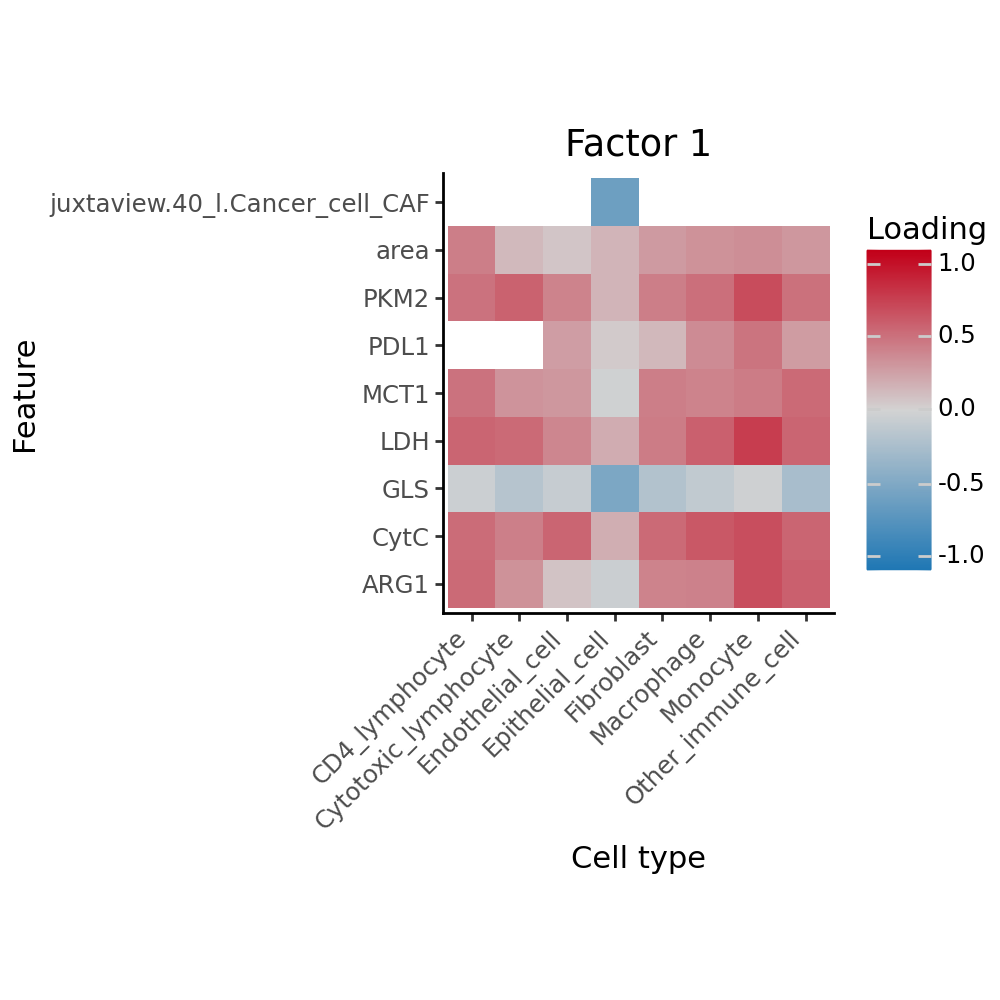

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_1.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_1.png


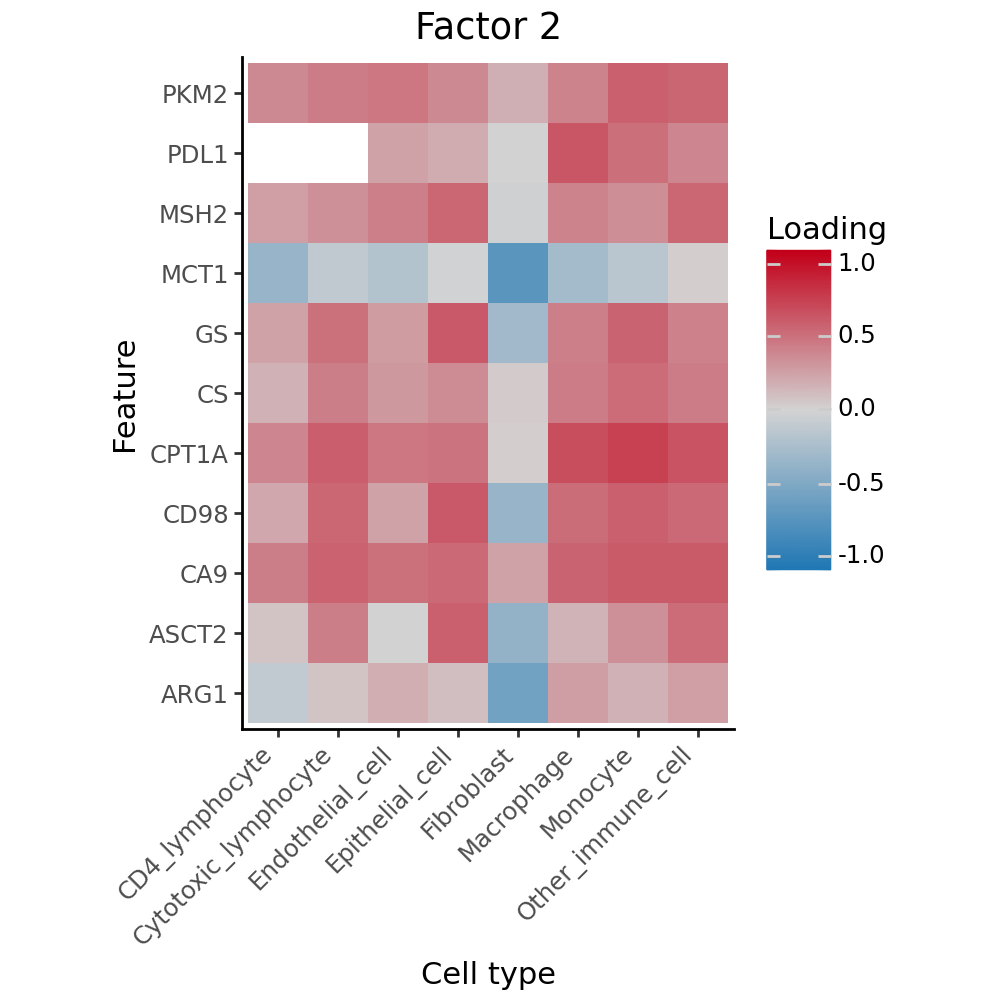

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_2.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_2.png


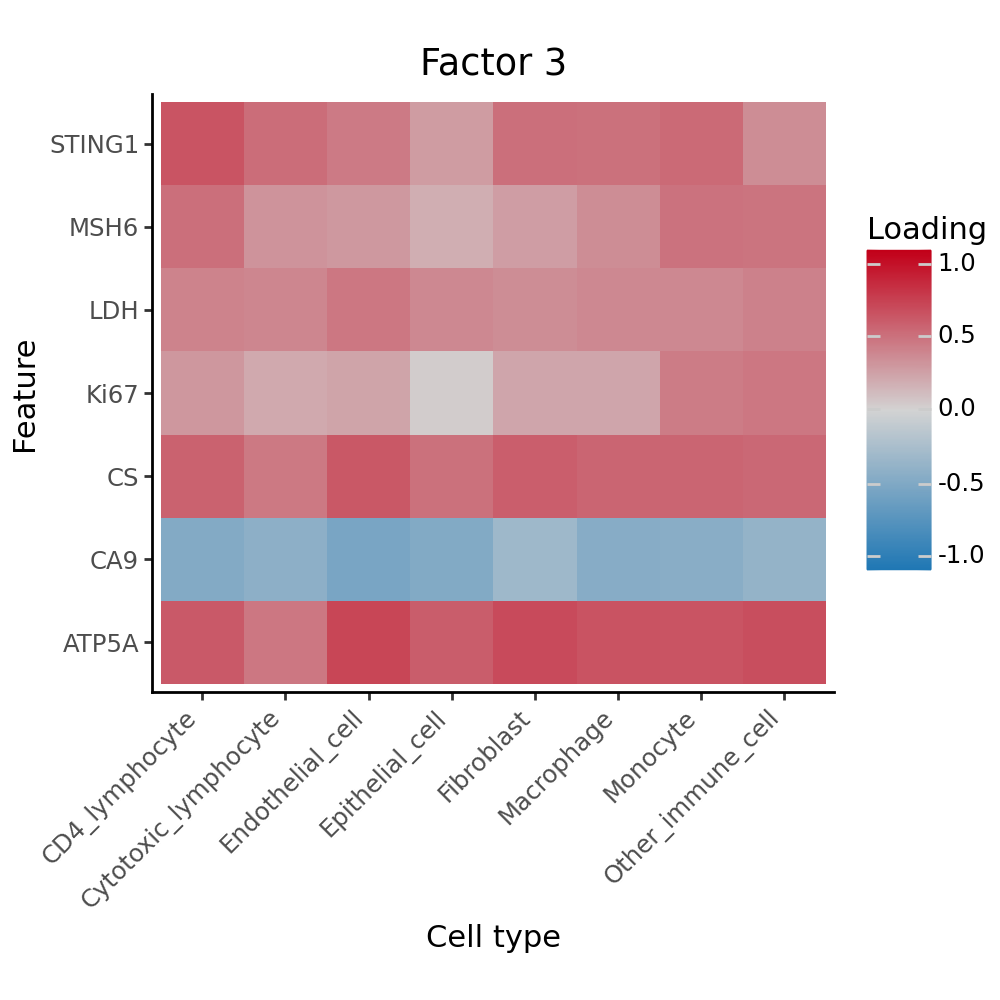

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_3.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_3.png


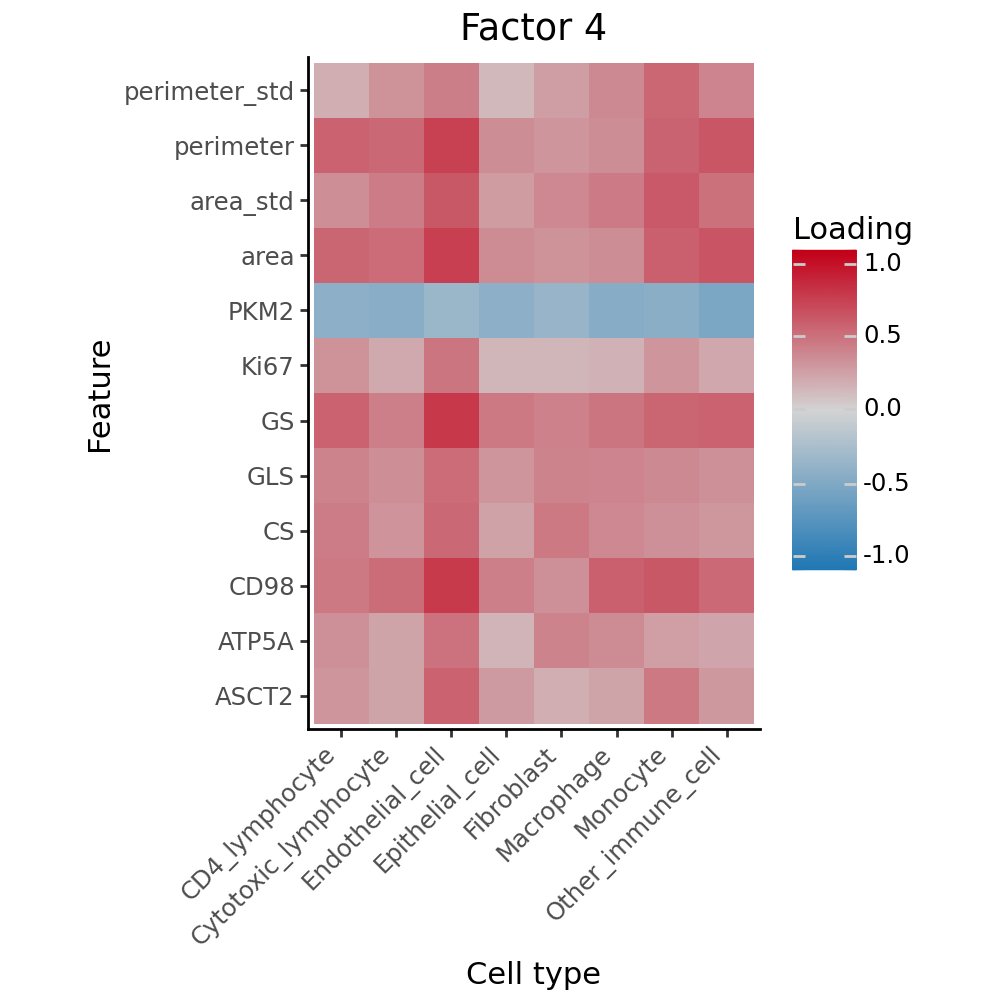

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_4.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_4.png


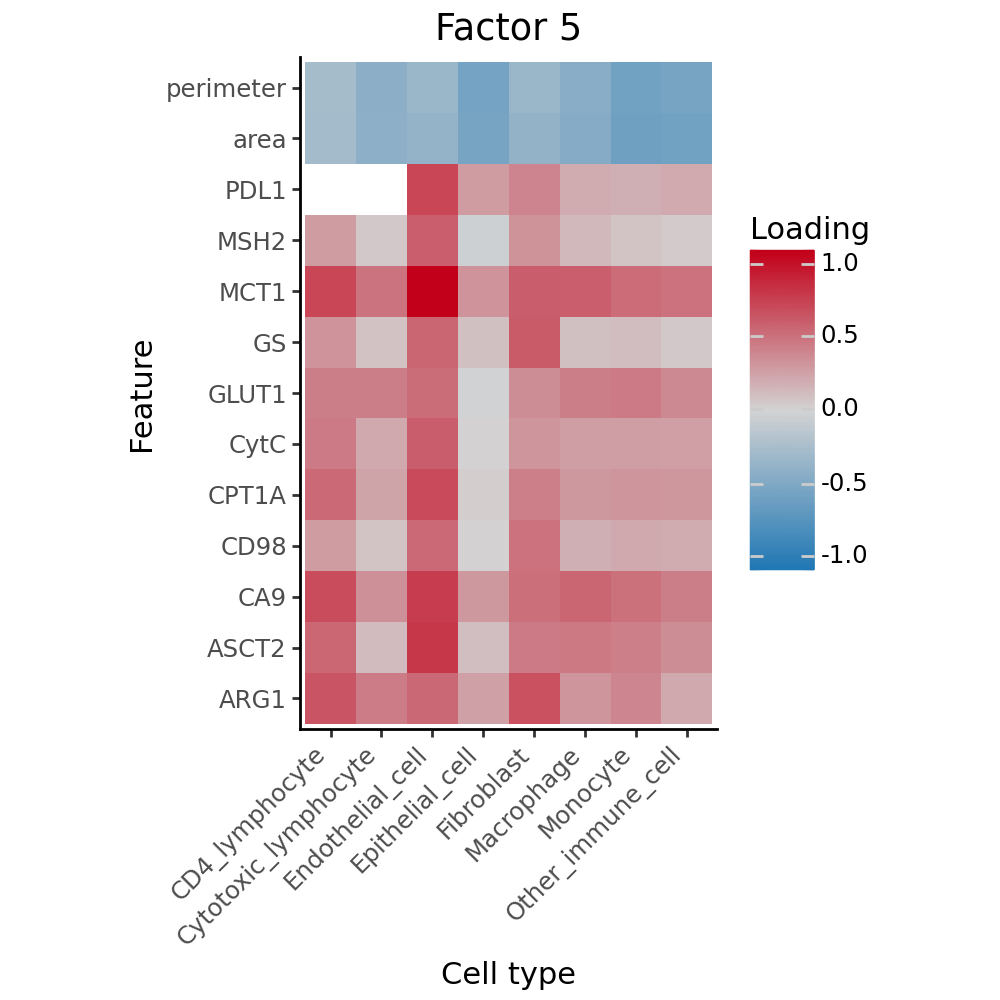

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_5.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_5.png


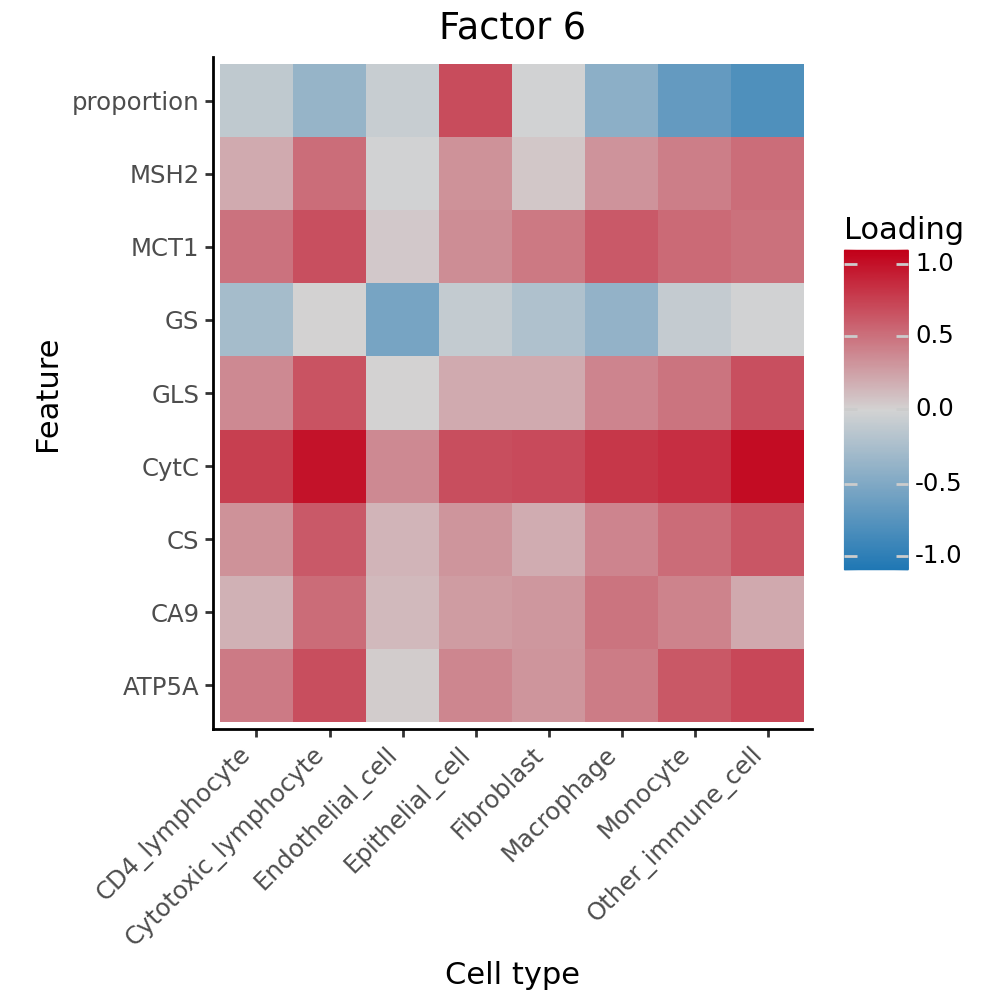

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_6.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_6.png


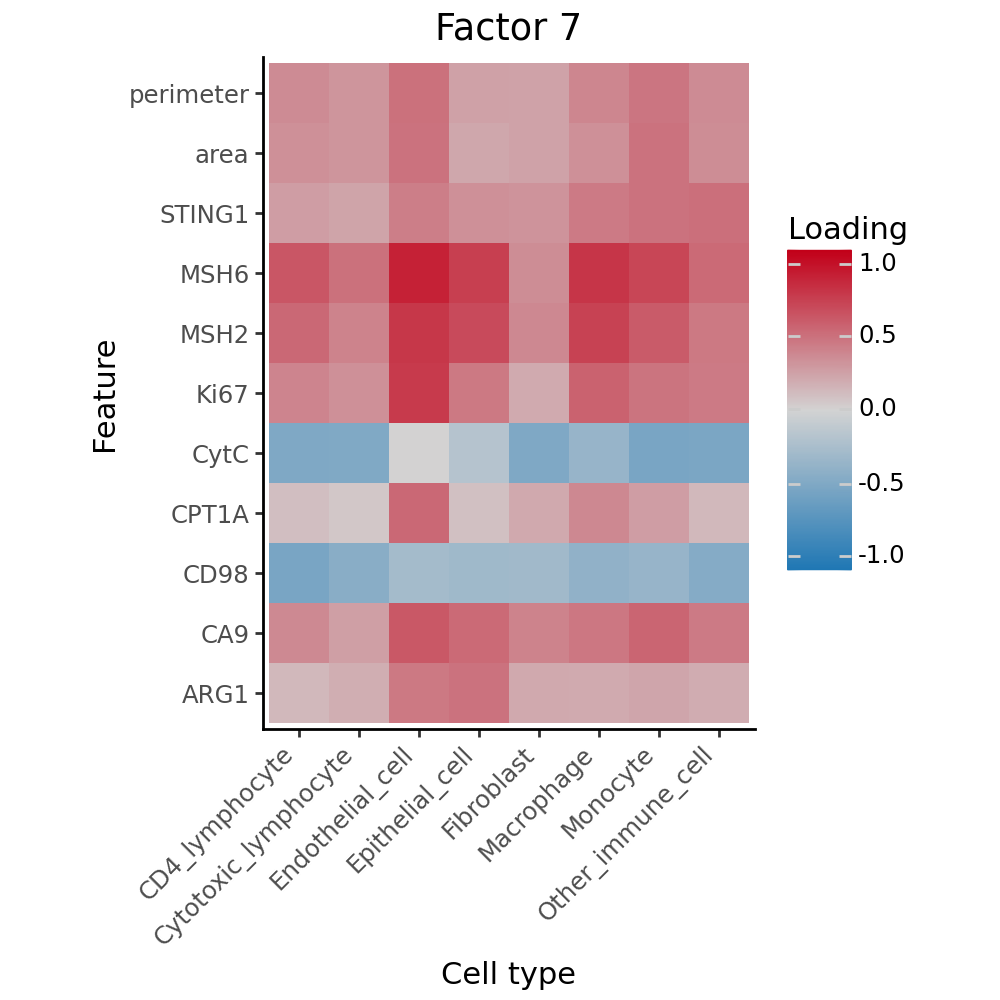

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_7.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_7.png


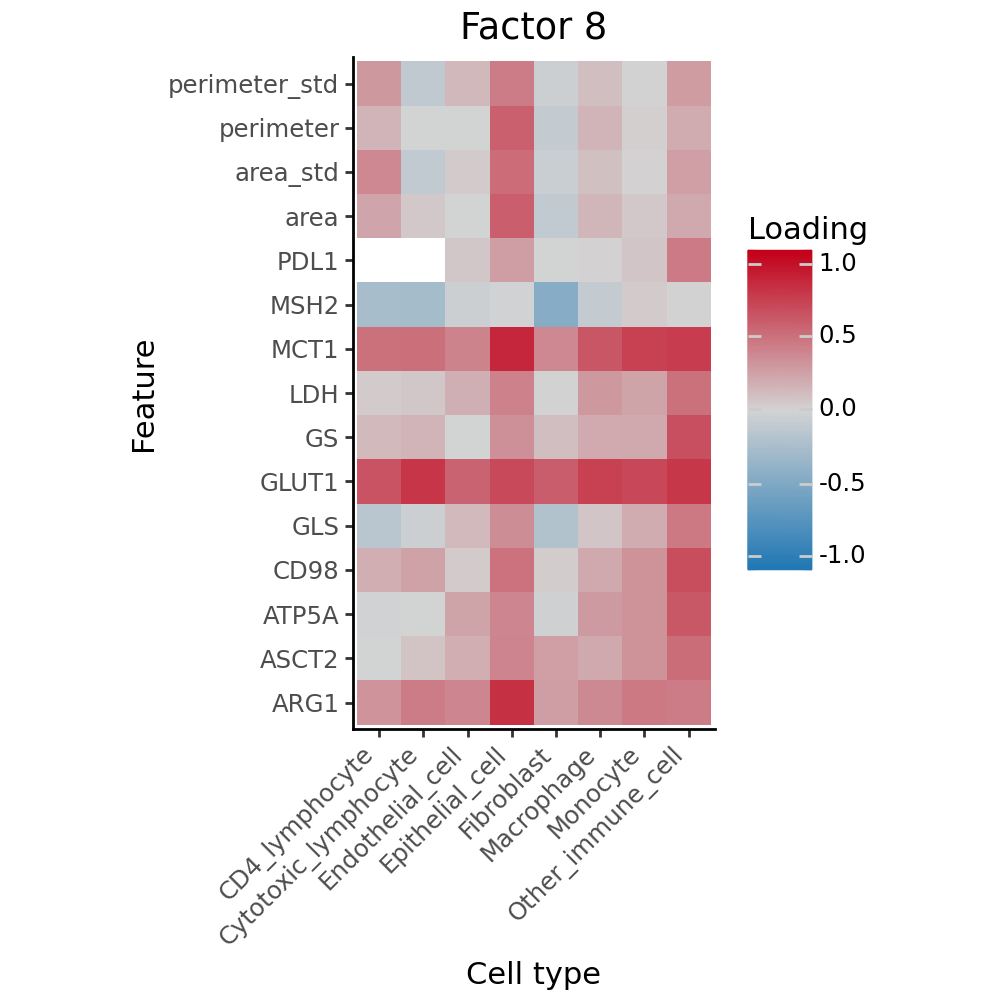

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_8.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_8.png


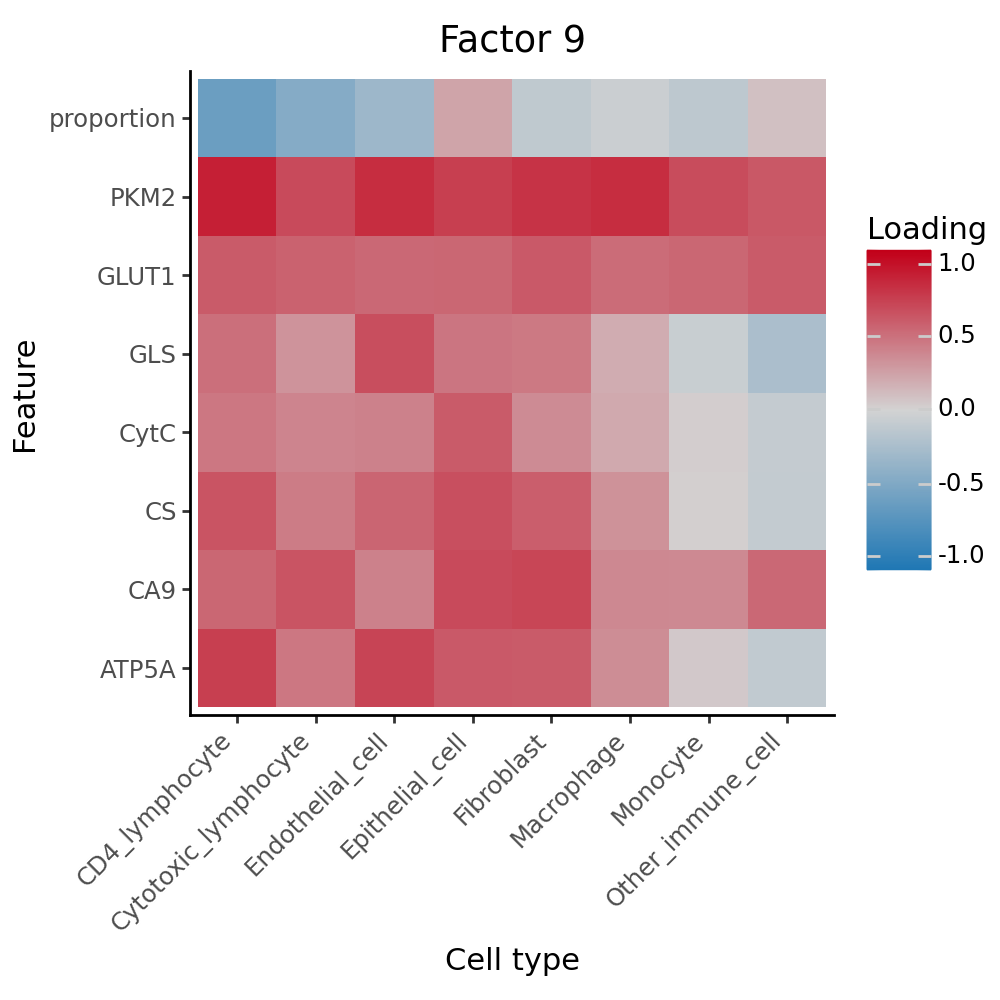

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_9.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_9.png


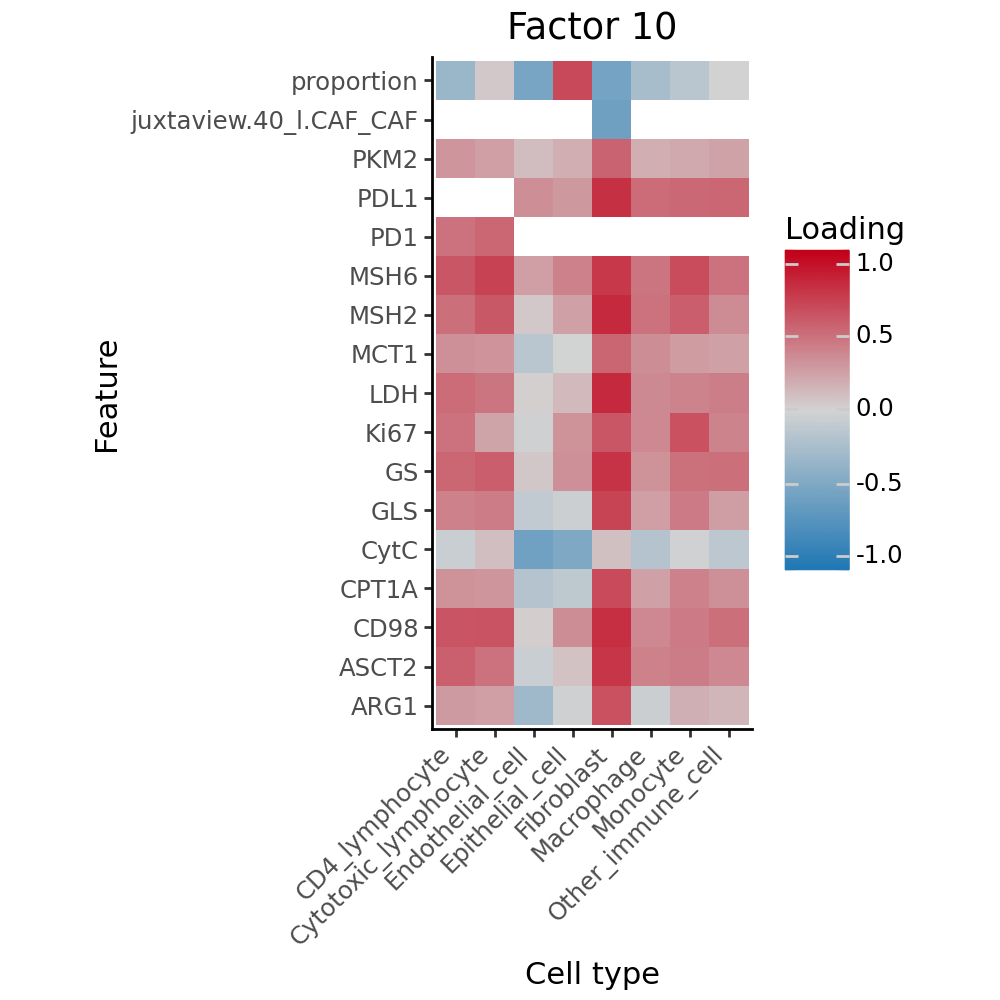

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_10.pdf
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig5/heatmap_factor_10.png


In [24]:
# get top genes with highest absolute loadings across all views
top_genes = variable_loadings['index'].head(30)
top_loadings = variable_loadings[variable_loadings['index'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

for fnum in range(1, top_loadings.shape[1] - 1):
    variable_loadings = variable_loadings.sort_values(by=f'Factor{fnum}', key=lambda x: abs(x), ascending=False) # Default
    top_genes = variable_loadings['index'].head(30)
    top_loadings = variable_loadings[variable_loadings['index'].isin(top_genes)]

    # plot them
    # dotplot of variable, view, loadings
    gp = (ggplot(top_loadings) +
        ggtitle(f"Factor {fnum}") +
        aes(x='view', y='index', fill=f'Factor{fnum}') +
        geom_tile() +
        scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', limits=[-1.1,1.1]) +
        theme_classic() +
        theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(5, 5)) +
        xlab("Cell type") +
        ylab("Feature") +
        labs(fill = "Loading") +
        coord_fixed()
    )
    gp.show()

    ggsave(gp, filename=f"../../figures/fig5/heatmap_factor_{fnum}.pdf", width=5, height=5, dpi=300)
    ggsave(gp, filename=f"../../figures/fig5/heatmap_factor_{fnum}.png", width=5, height=5, dpi=300)

### Reverse approach: influence of hand-picked features

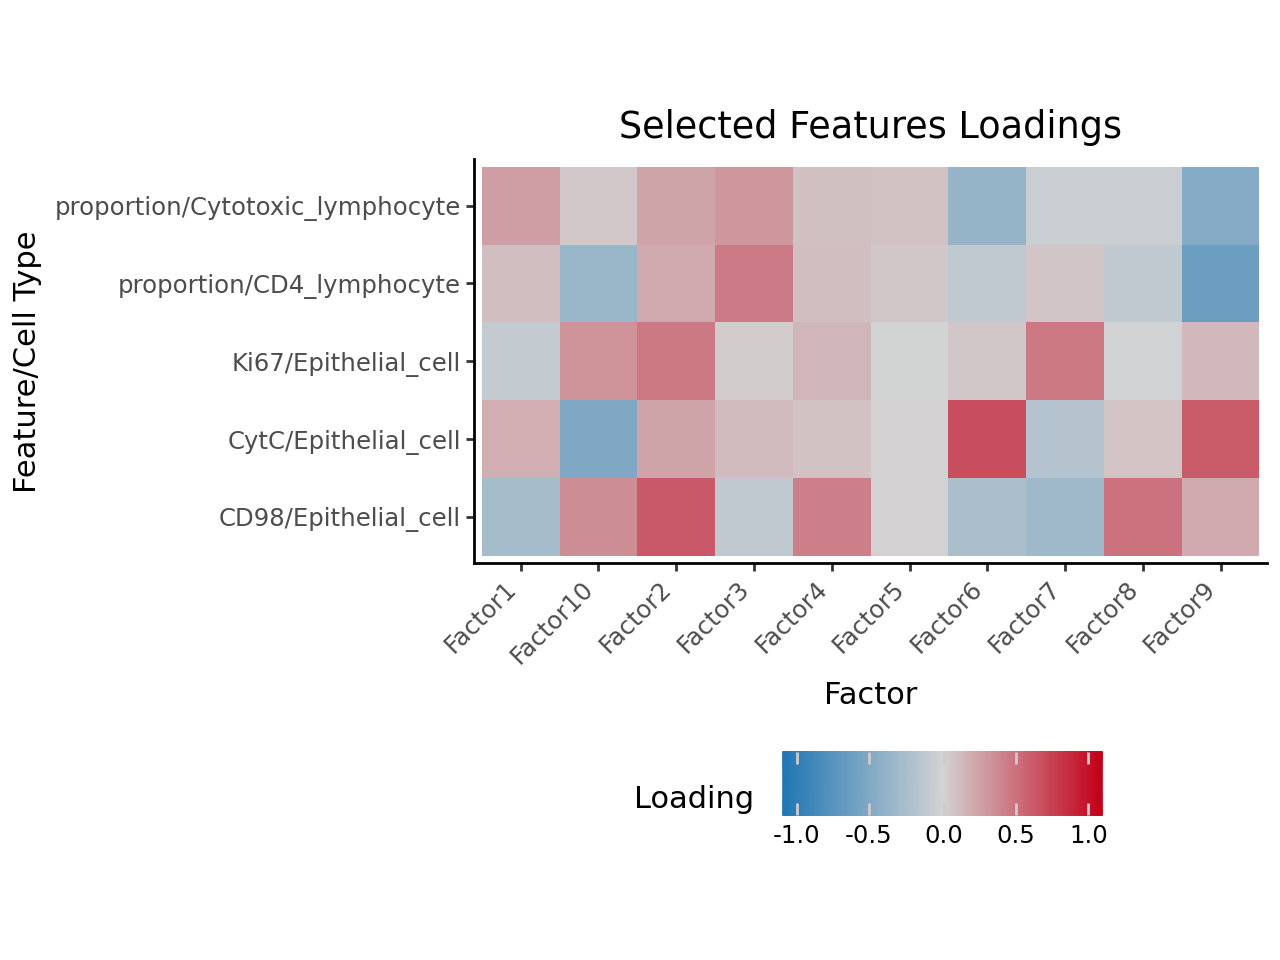

In [49]:
picked_ft = [("proportion", "Cytotoxic_lymphocyte"),
             ("proportion", "CD4_lymphocyte"),
             ("Ki67", "Epithelial_cell"),
             ("CytC", "Epithelial_cell"),
             ("CD98", "Epithelial_cell"),
             ("CD98", "Epithelial_cell"),
             ("Cancer_cell", 'juxtaview.40_l.Cancer_cell_CAF'),
             ]

picked_df = pd.concat([
    variable_loadings[(variable_loadings["index"] == ft) & (variable_loadings["view"] == view)]
    for ft, view in picked_ft], axis=0)

# Convert to long format for plotting
picked_df = picked_df.melt(id_vars=["index", "view"], var_name="Factor", value_name="loading")
# Rename features to include cell type
picked_df["Variable"] = picked_df["index"] + '/' + picked_df["view"]

# Plot the selected features
gp = (ggplot(picked_df, aes(x='Factor', y='Variable', fill='loading')) +
      geom_tile() +
      scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', limits=[-1.1, 1.1]) +
      theme_classic() +
      theme(axis_text_x=element_text(angle=45, hjust=1), legend_position="bottom") +
      labs(title="Selected Features Loadings", x="Factor", y="Feature/Cell Type", fill="Loading") +
      coord_fixed()
)
gp.show()

# ggsave(gp, filename="../../figures/fig5/muvi_selected_features.pdf", width=7, height=5, dpi=300)
# ggsave(gp, filename="../../figures/fig5/muvi_selected_features.png", width=7, height=5, dpi=300)

### Remarkable FOVs

In [120]:
features.obsm["X_muvi"] = model.get_factor_scores()
# obtain factor scores

# The following does not keep the order of the factors
# factor_scores = li.ut.get_factor_scores(features, obsm_key='X_muvi', obs_keys=['Stage'])

factor_scores = model.get_factor_scores(as_df=True)
# Add the 'Stage' column to factor_scores
factor_scores = factor_scores.join(features.obs['Stage'])
# Note: 0-based factor names

# Rename factors
factor_scores.rename(columns={f'factor_{i}': f'Factor {i+1}' for i in range(10)}, inplace=True)

factor_scores.head()

Factor 10  Factor 9  Factor 4  Factor 2  Factor 6  Factor 5  Factor 3  \
A1a   0.043200 -0.804270 -0.777069 -0.518456 -0.188191  0.237773 -1.182711   
A1c   0.451913 -0.038963 -1.326323 -0.118682 -0.435386 -0.248209 -0.465242   
A1d   0.496872 -0.286581 -0.498195 -0.143870 -0.528002 -0.304645 -1.155526   
A1e  -0.048562 -0.439213 -0.251855  0.207188 -0.190298  0.197477 -0.210322   
A1f   0.498868 -0.648575 -0.996008 -0.195288 -0.394502 -0.083718 -0.699430   

     Factor 1  Factor 7  Factor 8 Stage  
A1a -0.853493 -0.805808 -0.446559   pT3  
A1c  0.108097  0.086241 -0.441789   pT4  
A1d -0.346648 -0.421552 -0.152876   pT3  
A1e -0.197161 -0.734005 -0.377126   pT4  
A1f -0.113336 -0.154638 -0.373275   pT1

In [128]:
factor_scores.sort_values(by='Factor 6', ascending=False).head(12)

Factor 10  Factor 9  Factor 4  Factor 2  Factor 6  Factor 5  Factor 3  \
B8p   0.677732  1.373079  0.863441 -0.029735  2.754201  2.014332  1.789981   
B7p   1.411095  0.621163  0.937365 -1.373626  2.530278  0.027749 -0.116342   
D7d  -0.566531  0.256120  0.588797  0.539322  2.298238 -0.656559 -0.903139   
A9a   1.088838  1.513664  0.424611  1.665794  2.081998  0.348378  0.000653   
A7o   1.494376  0.095432  1.060093 -0.536717  2.020977  1.508179  1.035034   
B9n   2.378692  1.100070  0.976589 -1.321510  2.009357  0.848847  1.108571   
A9i  -1.073447  0.822067  1.654505  0.741782  1.998178  2.310005 -0.766239   
B8a  -0.669561  0.802010  0.032011  0.097027  1.656039  0.575408  0.562347   
D6l  -0.365605  0.533131  1.082106  0.648958  1.585462  0.645356  0.822733   
C3d  -0.049560 -0.329332 -0.627034 -0.077529  1.563111  0.210908 -0.013772   
A6d   0.570907  0.821822  0.314961 -0.028054  1.466583  1.385775  1.028385   
A9b   1.593017  1.455173  1.063914 -0.517891  1.460691 -0.103266  0.135096   

     Factor 1  Factor 7  Factor 8 Stage  
B8p  1.913728 -0.232034  0.583948   pT2  
B7p  0.662342  0.556467  1.377935   pT2  
D7d  1.863654 -1.153807 -0.171257   pT3  
A9a -0.711776 -1.004457 -0.043995   pT3  
A7o  2.256537 -1.763192  1.457934   pT3  
B9n  0.300271  1.974035  3.630591   pT3  
A9i  1.246258  0.233470 -1.414521   pT3  
B8a  0.002077 -0.382345 -1.086298   pT3  
D6l -0.248464  0.069827  0.046729   pT4  
C3d  0.861239 -1.140254  0.380900   pT2  
A6d -0.196151 -1.642218  0.417677   pT3  
A9b  1.243549 -0.882245  0.877278   pT2

In [129]:
factor_scores.sort_values(by='Factor 6', ascending=True).head(12)

Factor 10  Factor 9  Factor 4  Factor 2  Factor 6  Factor 5  Factor 3  \
A5d   0.440081  1.521480  0.288171 -0.926766 -2.462348  2.162813  0.179012   
B6n   0.094140  0.648012  0.384967  0.312985 -1.634719  1.413197  0.495227   
A7p   0.538478  0.829401 -0.212249 -0.785501 -1.576791  0.771817  0.446156   
A3n   0.520932  0.863378 -0.365226 -0.656592 -1.558534  0.924252  0.284351   
A7n  -0.165323  1.382948 -0.470031  0.354973 -1.501086  1.577709  0.771909   
A6l   0.767219 -0.368485  0.493434  1.858047 -1.479357 -0.168234  0.103765   
A2b   0.324444  1.026896 -1.022030 -0.182685 -1.270528 -0.214196  0.052848   
B6p  -0.157144  0.676061  0.537653  0.348828 -1.269614 -1.209383  0.221642   
D5d   0.702755  0.512456 -0.681504 -0.097885 -1.262840 -0.519728  0.191906   
A8q   0.976761  0.491966  0.858813  0.424854 -1.240235  0.640627 -0.871051   
B7d   0.458607  1.363972 -1.653233 -0.357001 -1.144564  0.596138 -0.035281   
C5b   0.491134  1.177162  0.361367  0.032631 -1.117750  0.162084 -0.541995   

     Factor 1  Factor 7  Factor 8 Stage  
A5d  0.079657 -0.405543  1.007412   pT3  
B6n -0.125706  0.202463  1.701595   pT4  
A7p  0.685043  0.124151 -0.043410   pT3  
A3n  0.077907 -0.479558  0.062965   pT4  
A7n  0.016877 -0.070325  1.257888   pT3  
A6l  0.572560 -1.239871  0.734843   pT4  
A2b  0.110554 -0.799407  0.602438   pT4  
B6p  1.069295 -0.637416  0.630682   pT4  
D5d  1.859660  0.636841  0.231340   pT2  
A8q -0.234633 -0.818520  0.371591   pT3  
B7d -0.268248 -0.623651  1.128136   pT4  
C5b  0.755917 -0.221254  1.269128   pT3

In [130]:
factor_scores.sort_values(by='Factor 2', ascending=False).head(12)

Factor 10  Factor 9  Factor 4  Factor 2  Factor 6  Factor 5  Factor 3  \
D9i   2.276033 -0.046588  0.607910  2.543567  0.974816  1.657246  1.872542   
B9a   0.438147  0.317483 -0.230160  2.313092  0.786176  0.052647  0.979286   
A9q   1.441783  0.066698  0.024599  2.068325  1.229285  0.196730  0.991956   
A6l   0.767219 -0.368485  0.493434  1.858047 -1.479357 -0.168234  0.103765   
A8e   0.079291 -0.000186  0.174917  1.704752  0.019001 -0.037936  0.884715   
A9a   1.088838  1.513664  0.424611  1.665794  2.081998  0.348378  0.000653   
B8n   0.687555  0.804993  1.243111  1.620116  0.271494  0.773410 -0.113543   
B6e   0.541782 -0.009871  0.063184  1.530901  0.398703  0.078598  0.654399   
B8l  -0.099630  0.573531  1.850948  1.475383 -0.437781  0.069415  0.281396   
D6c   0.710647 -0.240907  1.177731  1.466483 -0.642290 -0.507926  2.029501   
B9b  -1.278515 -0.062976  0.825327  1.401545  0.882146  0.941868  0.358735   
B9e  -1.681494  0.934116  0.278111  1.311180  0.434992  1.652326 -0.244137   

     Factor 1  Factor 7  Factor 8 Stage  
D9i  1.095071  2.726323  0.767652   pT2  
B9a  0.130972  1.283988 -0.464125   pT2  
A9q -0.480307  1.403070  0.346192   pT1  
A6l  0.572560 -1.239871  0.734843   pT4  
A8e -0.108418 -0.154496  0.216797   pT3  
A9a -0.711776 -1.004457 -0.043995   pT3  
B8n  1.492401 -0.075990  0.340803   pT3  
B6e  0.654576  0.073689  0.901338   pT1  
B8l -0.051696 -1.193424  0.454597   pT4  
D6c  1.592655  0.275384  0.251497   pT2  
B9b  1.152946  0.454153 -0.303554   pT2  
B9e  0.268016  2.361467  0.283680   pT4

In [131]:
factor_scores.sort_values(by='Factor 2', ascending=True).head(12)

Factor 10  Factor 9  Factor 4  Factor 2  Factor 6  Factor 5  Factor 3  \
B4g   0.412035  1.667916  1.151076 -2.419734 -0.128449  1.881942  0.647539   
B7p   1.411095  0.621163  0.937365 -1.373626  2.530278  0.027749 -0.116342   
C2a   0.078628  0.368039  0.214459 -1.355254  1.182457 -0.018672  0.391472   
B9n   2.378692  1.100070  0.976589 -1.321510  2.009357  0.848847  1.108571   
C1l  -0.116649 -0.982249  0.352623 -1.296192 -0.369708 -0.598826 -1.180602   
D2e  -0.336289 -0.510768  0.308727 -1.277057 -0.241432 -0.444775 -0.552532   
D3i  -0.303671 -0.789838  0.173327 -1.263660 -0.148483 -0.537864 -0.685451   
B8e  -0.588955 -0.363904  0.087622 -1.158306  0.099088  0.022872 -0.141537   
D1k  -0.254637 -0.893579 -0.189376 -1.070279 -0.277692 -0.285243 -0.624121   
C1f  -0.027508 -0.501181 -0.113174 -1.060338 -0.203188 -0.366341 -0.775766   
D9e  -0.796037  0.934648 -0.361348 -1.054513 -0.751696  0.060137 -0.750434   
D1i   1.492908  0.004673  1.254168 -1.045462  0.225112 -0.020644  0.072456   

     Factor 1  Factor 7  Factor 8 Stage  
B4g -0.295796  0.090320 -0.385151   pT2  
B7p  0.662342  0.556467  1.377935   pT2  
C2a  1.725259 -0.039650  0.424336   pT3  
B9n  0.300271  1.974035  3.630591   pT3  
C1l  0.064843  0.070754 -0.321527   pT4  
D2e -0.211602  0.313731 -0.487654   pT2  
D3i  0.031293  0.260888 -0.510593   pT3  
B8e -0.625242 -0.020825 -0.775139   pT3  
D1k -0.285756 -0.127087 -0.329880   pT3  
C1f -0.298940 -0.178680 -0.232719   pT3  
D9e -0.460422 -0.130280  1.156989   pT4  
D1i  0.118408 -0.315304  0.252469   pT2

### Association with clinical variables

In [59]:
# Kruksal Wallis test for factor 1 and stage
from scipy.stats import kruskal
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['Stage']
    print(fnum, kruskal(factor1[stage == 'pT1'], factor1[stage == 'pT2'], factor1[stage == 'pT3'], factor1[stage == 'pT4'], factor1[stage == 'Colon-no.']))
    # Note: multiply by 10 for Bonferroni correction

1 KruskalResult(statistic=3.064029836027885, pvalue=0.5471679299391048)
2 KruskalResult(statistic=16.87269140660169, pvalue=0.002046187638389213)
3 KruskalResult(statistic=10.305143679443063, pvalue=0.035589605645851424)
4 KruskalResult(statistic=11.545438207341931, pvalue=0.021071866756418398)
5 KruskalResult(statistic=8.08440992307078, pvalue=0.08853463188711747)
6 KruskalResult(statistic=29.475727356657444, pvalue=6.2570973018044315e-06)
7 KruskalResult(statistic=7.582360609256966, pvalue=0.10813189862993788)
8 KruskalResult(statistic=12.396915307659583, pvalue=0.01463131966282673)
9 KruskalResult(statistic=14.167662756400205, pvalue=0.006778730492305248)
10 KruskalResult(statistic=4.009545722267603, pvalue=0.40471551816277296)


In [61]:
# Similar results with Kendall's tau test
from scipy.stats import kendalltau
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['Stage']
    score = kendalltau(factor1, pd.Categorical(stage).codes)
    print(fnum, 
          score.pvalue * 10)

1 7.218625499395904
2 0.04418331763796506
3 0.1628252100807821
4 0.2377583138877043
5 0.05179928301918579
6 1.1833576622879486e-06
7 0.13396934698519056
8 0.020599303652237375
9 0.21251069236786835
10 1.0782268244764843


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


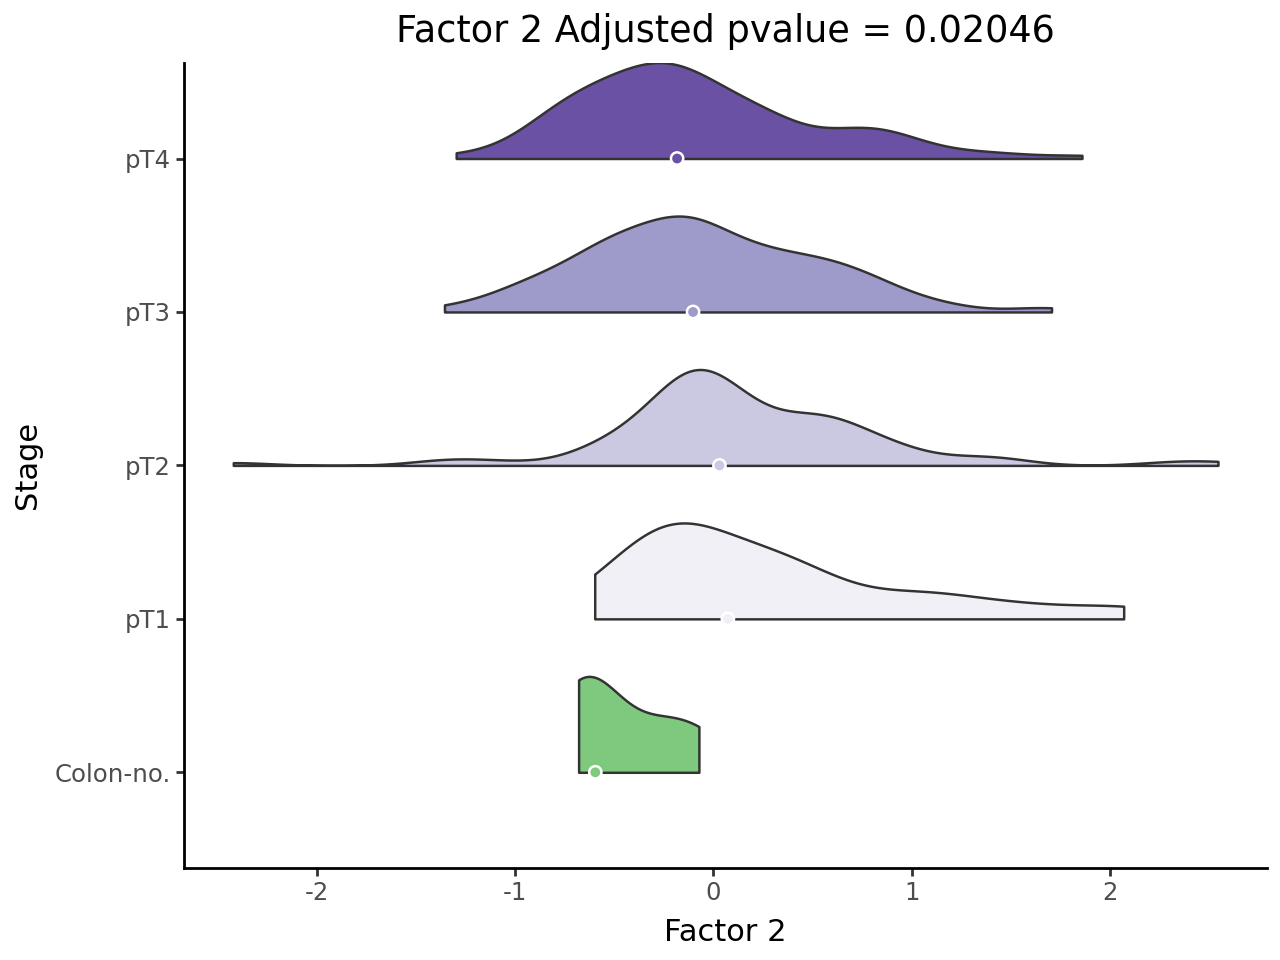

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


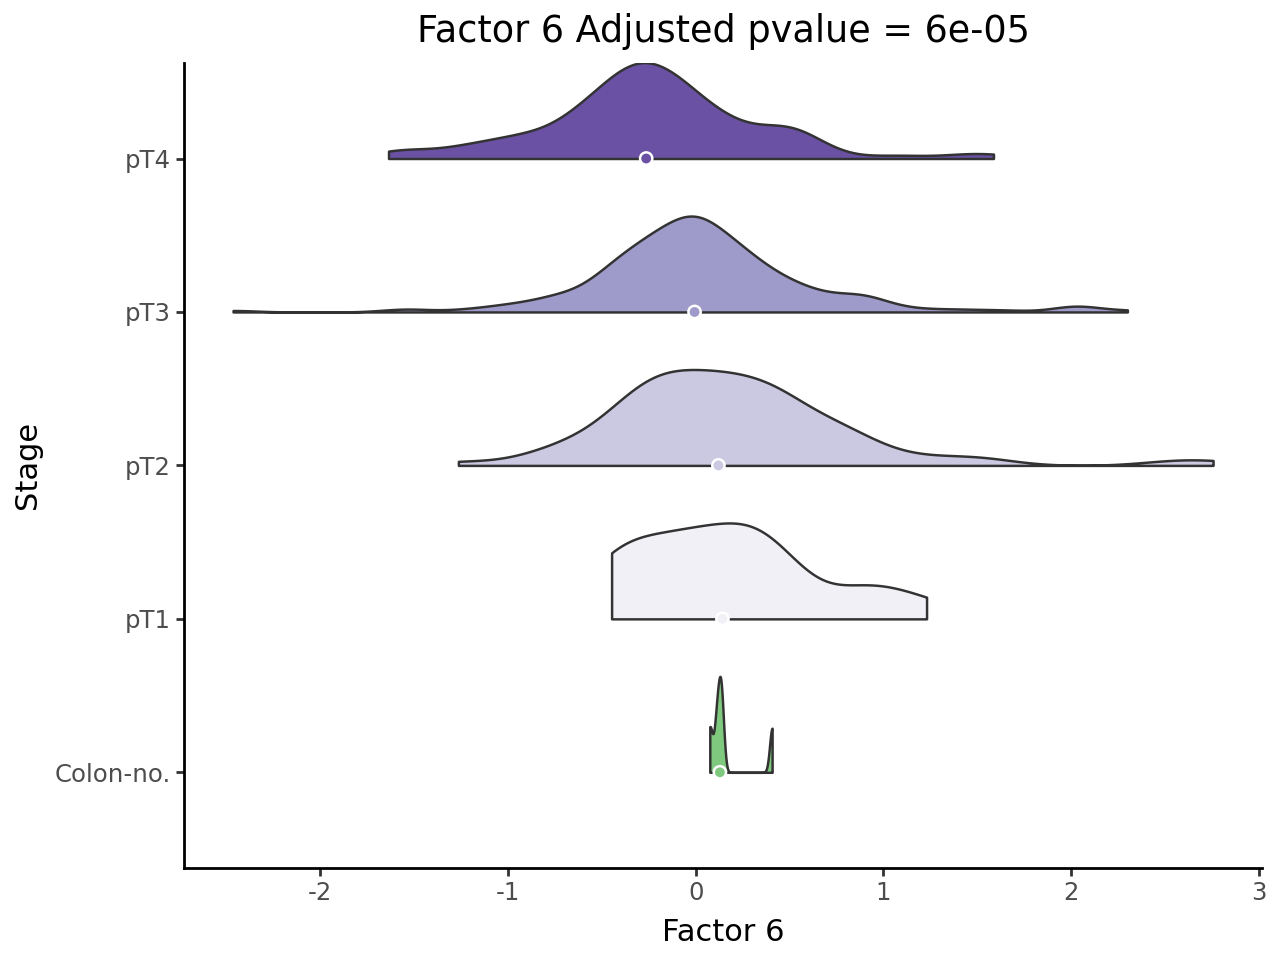

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


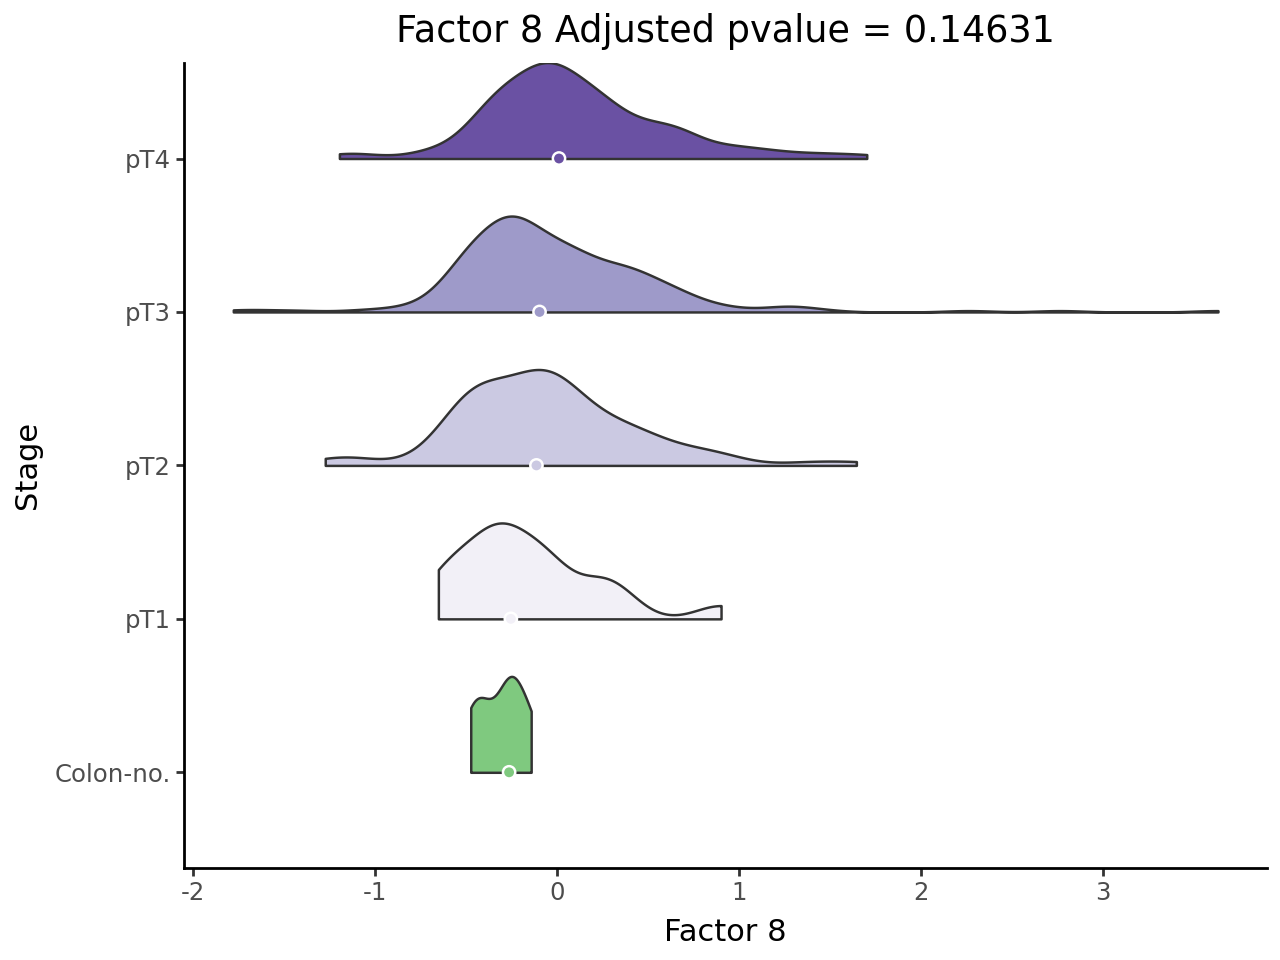

In [62]:
# Several factors are associated with disease stage
pal_stages = [(127,201,127), (242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

for f in ["Factor 2", "Factor 6", "Factor 8"]:
    gp = ggplot(factor_scores, aes(y=f, x='Stage', fill='Stage')) + \
            geom_violin(style="right", scale="width", width = 1.25) + \
            stat_summary(fun_y=np.median, geom='point', color='white', size=2) + \
            theme_classic() + \
            coord_flip() + \
            scale_fill_manual(values = pal_stages) + \
            guides(fill=False) + \
            ggtitle(f + " Adjusted pvalue = " + str(round(10*kruskal(factor_scores[f][factor_scores['Stage'] == 'pT1'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT2'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT3'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'pT4'], 
                                                 factor_scores[f][factor_scores['Stage'] == 'Colon-no.'])[1],5)))
    gp.show()
    # ggsave(gp, filename=f"../../figures/fig5/{f}_pT_violin.pdf", width=4.5, height=4.5, dpi=300)

In [63]:
import numpy as np
from scipy import stats

def get_cov_ellipse(cov, center, nstd=2, **kwargs):
    """
    Return an ellipse representing the covariance matrix *cov* centered at *center*.
    *nstd* is the number of standard deviations to determine the ellipse's radiuses.
    """
    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by
    theta = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    # Width and height of ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)
    
    # Generate ellipse points via transformation of unit circle
    transform = eigvecs @ np.diag(nstd * np.sqrt(eigvals))

    t = np.linspace(0, 2*np.pi, 100)
    circle = np.column_stack([np.cos(t), np.sin(t)])
    ellipse = circle @ transform.T

    # Add center
    ellipse += center
    
    return pd.DataFrame({'x': ellipse[:, 0], 'y': ellipse[:, 1]})

In [65]:
# Create confidence ellipses for each stage
ellipses = pd.DataFrame()
for stage in factor_scores['Stage'].unique():
    stage_data = factor_scores[factor_scores['Stage'] == stage]
    x = stage_data['Factor 2']
    y = stage_data['Factor 6']
    
    # Calculate mean and covariance
    mean = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    
    # Get ellipse points
    ell_df = get_cov_ellipse(cov, mean, nstd=2)
    ell_df['Stage'] = stage
    ellipses = pd.concat([ellipses, ell_df])

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/scales/scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


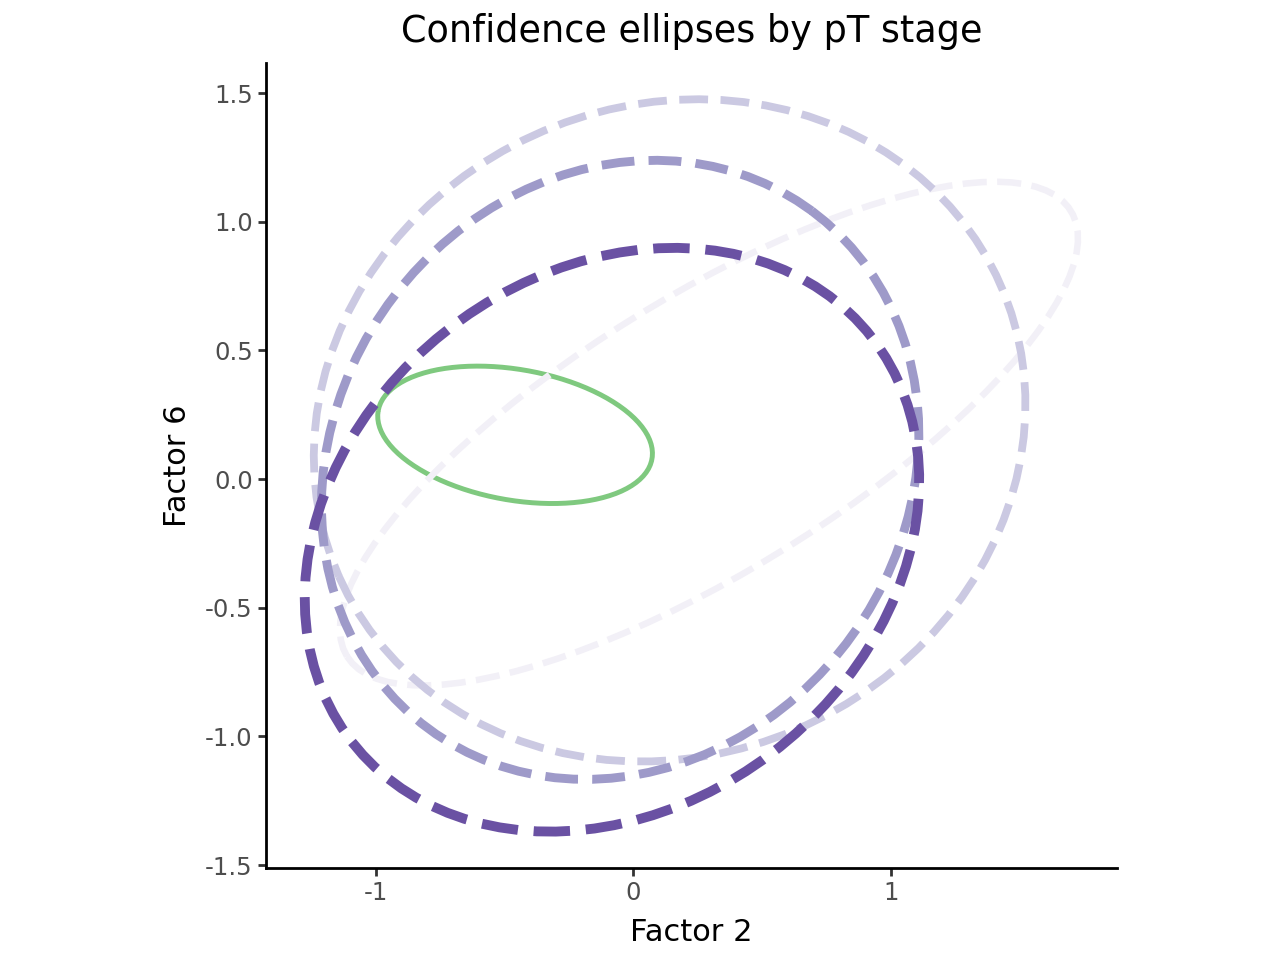

In [66]:
# Plot confidence ellipses
gp = (ggplot(data=factor_scores, mapping=aes(x='Factor 2', y='Factor 6', color='Stage')) +
    geom_path(data=ellipses, mapping=aes(x='x', y='y', group='Stage', color='Stage', size='Stage', linetype='Stage')) +
    theme_classic() +
    scale_color_manual(values=pal_stages) +
    ggtitle('Confidence ellipses by pT stage') +
    theme(legend_position='none') +
    scale_size_discrete(range=[1, 2])+
    scale_linetype_manual(values=["solid", "dashed", "dashed", "dashed", "dashed"]) +
    coord_equal()
)
  
# ggsave(gp, filename="../../figures/fig5/pT_f4_f5_ellipses.pdf", width=4.5, height=4.5, dpi=300)
gp

In [67]:
# Export the data for complex plot in R
factor_scores.to_csv("../../data/factor_scores.csv", index=False)

### Export top features for stage-relevant factors

In [68]:
top_ft_per_type = pd.DataFrame(columns=["Variable", "Cell type", "Weight"])

In [71]:
# Number of features per cell type
ft_per_type = 5
for fnum in [2,6]:
    variable_loadings = variable_loadings.sort_values(by=f'Factor{fnum}', key=lambda x: abs(x), ascending=False) # Interested in both up- and down-regulation
    v = variable_loadings.groupby("view").head(ft_per_type)
    top_ft_per_type = pd.concat([top_ft_per_type,
                                pd.DataFrame({
                                    "Variable": v["index"],
                                    "Cell type": v.view,
                                    "Weight": v[f'Factor{fnum}'],
                                })])
top_ft_per_type = top_ft_per_type.sort_values(by='Weight', key=lambda x: abs(x), ascending=False)
# Remove duplicates if any
top_ft_per_type = top_ft_per_type.drop_duplicates(subset=["Variable", "Cell type"], keep="first")
# Keep the final number of features per cell type
top_ft_per_type = top_ft_per_type.groupby("Cell type").head(ft_per_type)
top_ft_per_type.head()

/tmp/ipykernel_593914/655007877.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Variable             Cell type    Weight
3          CytC     Other_immune_cell  1.036964
280        CytC  Cytotoxic_lymphocyte  1.004569
242        CytC              Monocyte  0.861559
83         CytC            Macrophage  0.818371
0    proportion     Other_immune_cell -0.810461

In [72]:
def get_ft(ft, view):
    return features[view].X[:,features[view].var_names == ft]
top_ft = mu.AnnData(np.hstack([get_ft(x.Variable, x["Cell type"]) for _, x in top_ft_per_type.iterrows()]))
# Keep track of FOVs
top_ft.obs = features["Fibroblast"].obs
# Keep track of features
top_ft.var = top_ft_per_type

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [3, 280, 242, 83, 0]

    Inferred to be: integer



In [78]:
# Export to h5ad
top_ft.write("../../data/top_features_multi_pT.h5ad")

... storing 'Variable' as categorical
... storing 'Cell type' as categorical


In [79]:
top_ft_per_type.to_csv("../../data/top_features_multi_pT.csv", index=False)

In [80]:
top_ft_per_class = pd.DataFrame(columns=["Variable", "Cell type", "Feature type", "Weight"])
# Map features to feature class
types_ft = {f: k for (k,v) in ft_types.items() for f in v}

In [83]:
# Number of features per cell type
ft_per_type = 5
for fnum in [2,6]:
    v = variable_loadings.sort_values(by=f'Factor{fnum}', key=lambda x: abs(x), ascending=False)
    v["class"] = [types_ft[ft] for ft in v['index']]
    v = v.groupby("class").head(ft_per_type)
    top_ft_per_class = pd.concat([top_ft_per_class,
                                    pd.DataFrame({
                                        "Variable": v["index"],
                                        "Cell type": v.view,
                                        "Feature type": v["class"],
                                        "Weight": v[f'Factor{fnum}'],
                                    })])
top_ft_per_class = top_ft_per_class.sort_values(by='Weight', key=lambda x: abs(x), ascending=False)
# Remove duplicates if any
top_ft_per_class = top_ft_per_class.drop_duplicates(subset=["Variable", "Cell type"], keep="first")
# Keep the final number of features per cell type
top_ft_per_class = top_ft_per_class.groupby("Feature type").head(ft_per_type)
top_ft_per_class.head()

Variable             Cell type Feature type    Weight
205     MCT1      Endothelial_cell   Metabolism  1.096047
3       CytC     Other_immune_cell   Metabolism  1.036964
280     CytC  Cytotoxic_lymphocyte   Metabolism  1.004569
242     CytC              Monocyte   Metabolism  0.861559
83      CytC            Macrophage   Metabolism  0.818371

In [84]:
top_ft = mu.AnnData(np.hstack([get_ft(x.Variable, x["Cell type"]) for _, x in top_ft_per_class.iterrows()]))
# Keep track of FOVs
top_ft.obs = features["Fibroblast"].obs
# Keep track of features
top_ft.var = top_ft_per_class

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [205, 3, 280, 242, 83]

    Inferred to be: integer



In [85]:
# Export to h5ad
top_ft.write("../../data/top_features_class_pT.h5ad")

... storing 'Variable' as categorical
... storing 'Cell type' as categorical
... storing 'Feature type' as categorical


In [86]:
top_ft_per_class.to_csv("../../data/top_features_class_pT.csv", index=False)

### Other info

In [87]:
import pandas as pd
clin = pd.read_csv("../../data/summary_clinical_data_modified.csv")

In [88]:
features.obs["Node"] = pd.NA
features.obs.loc[[x[0] == "E" for x in features.obs.index], "Node"] = "Healthy"
# Which FOVs are in each node stage?
n0fovs = clin.loc[clin['pN raw'].str.contains('pN0', na=False), "TMA Localisation"]
n1fovs = clin.loc[clin['pN raw'].str.contains('pN1', na=False), "TMA Localisation"]
n2fovs = clin.loc[clin['pN raw'].str.contains('pN2', na=False), "TMA Localisation"]
features.obs.loc[features.obs.index.isin(n0fovs), "Node"] = "pN0"
features.obs.loc[features.obs.index.isin(n1fovs), "Node"] = "pN1"
features.obs.loc[features.obs.index.isin(n2fovs), "Node"] = "pN2"
features.obs["Node"].value_counts(dropna=False)

Node
pN0        222
pN1        106
pN2         88
Healthy      5
<NA>         2
Name: count, dtype: int64

In [89]:
clin.set_index("TMA Localisation", inplace=True)

In [90]:
features.obs["MS"] = [pd.NA if x[0] == "E"
                      else "MSS" if clin.loc[x, 'MSI gesamt RED'] == 'stabil'
                      else "MSI" if clin.loc[x, 'MSI gesamt RED'] == 'instabil'
                      else pd.NA
                      for x in features.obs.index]
features.obs["MS"].value_counts(dropna=False)

MS
MSS     314
<NA>     92
MSI      17
Name: count, dtype: int64

In [91]:
features.obs["Sex"] = [pd.NA if x[0] == "E"
                      else "Man" if clin.loc[x, 'Sex'] == 'm'
                      else "Woman" if clin.loc[x, 'Sex'] == 'w'
                      else pd.NA
                      for x in features.obs.index]
features.obs["Sex"].value_counts(dropna=False)

Sex
Man      222
Woman    196
<NA>       5
Name: count, dtype: int64

```
# obtain factor scores
factor_scores = li.ut.get_factor_scores(features, obsm_key='X_muvi', obs_keys=['Stage', 'Node', 'MS', 'Sex'])
factor_scores = factor_scores.loc[~factor_scores.Node.isna(),:]
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor{fnum}']
    stage = factor_scores['Node']
    print(fnum, kruskal(factor1[stage == 'pN0'], factor1[stage == 'pN1'], factor1[stage == 'pN2']))
    # Note: multiply by 10 for Bonferroni correction
```

In [ ]:
# obtain factor scores
factor_scores_all_annot = factor_scores.drop(columns=["Stage"]).join(features.obs)
factor_scores = factor_scores_all_annot.loc[~factor_scores_all_annot.Node.isna(),:]
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['Node']
    print(fnum, kruskal(factor1[stage == 'pN0'], factor1[stage == 'pN1'], factor1[stage == 'pN2'], factor1[stage == 'Healthy']))
    # Note: multiply by 10 for Bonferroni correction

1 KruskalResult(statistic=1.913342302268802, pvalue=0.5905861553772085)
2 KruskalResult(statistic=6.0894304679145534, pvalue=0.10733938338097444)
3 KruskalResult(statistic=8.425639054357134, pvalue=0.03798727584426566)
4 KruskalResult(statistic=10.763715599049874, pvalue=0.013074637316528187)
5 KruskalResult(statistic=14.646008424369484, pvalue=0.002145564470215301)
6 KruskalResult(statistic=12.835106894007822, pvalue=0.005007111078359309)
7 KruskalResult(statistic=3.041787203903141, pvalue=0.3852271770067794)
8 KruskalResult(statistic=14.783262613336774, pvalue=0.0020115532479378384)
9 KruskalResult(statistic=9.64776765720967, pvalue=0.021810224111691378)
10 KruskalResult(statistic=1.9739991240751351, pvalue=0.5778207843996224)


In [102]:
# Similar results with Kendall's tau test
from scipy.stats import kendalltau
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['Node']
    score = kendalltau(factor1, pd.Categorical(stage).codes)
    print(fnum, 
          score.pvalue * 10)

1 9.817572551447252
2 3.22128806412724
3 4.2441712343397375
4 0.15392022366724809
5 0.007630600760657832
6 0.00595417388456177
7 3.125385033079433
8 0.0025821845029215767
9 0.2226443717825671
10 3.092630601290376


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


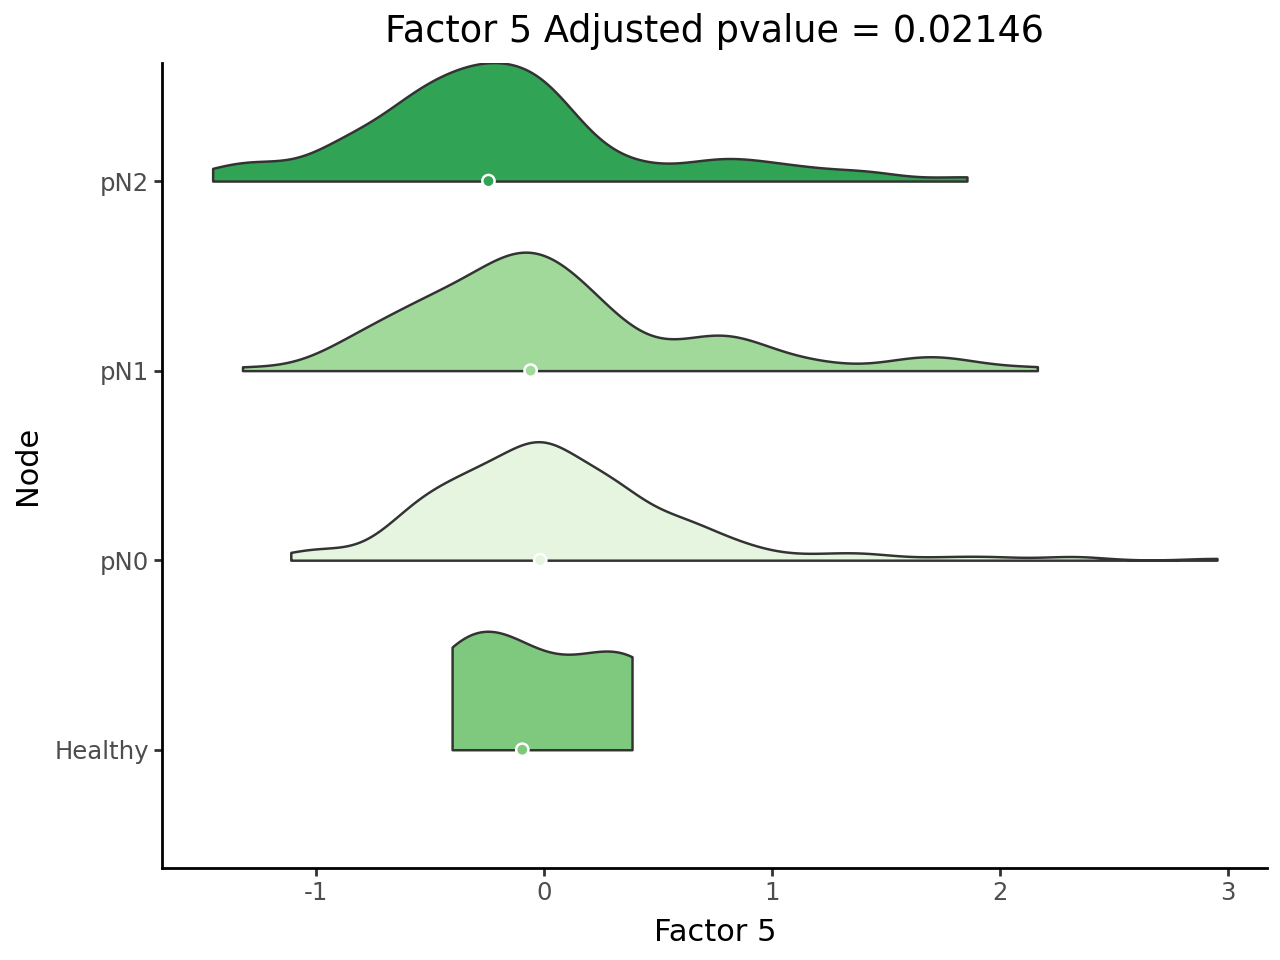

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


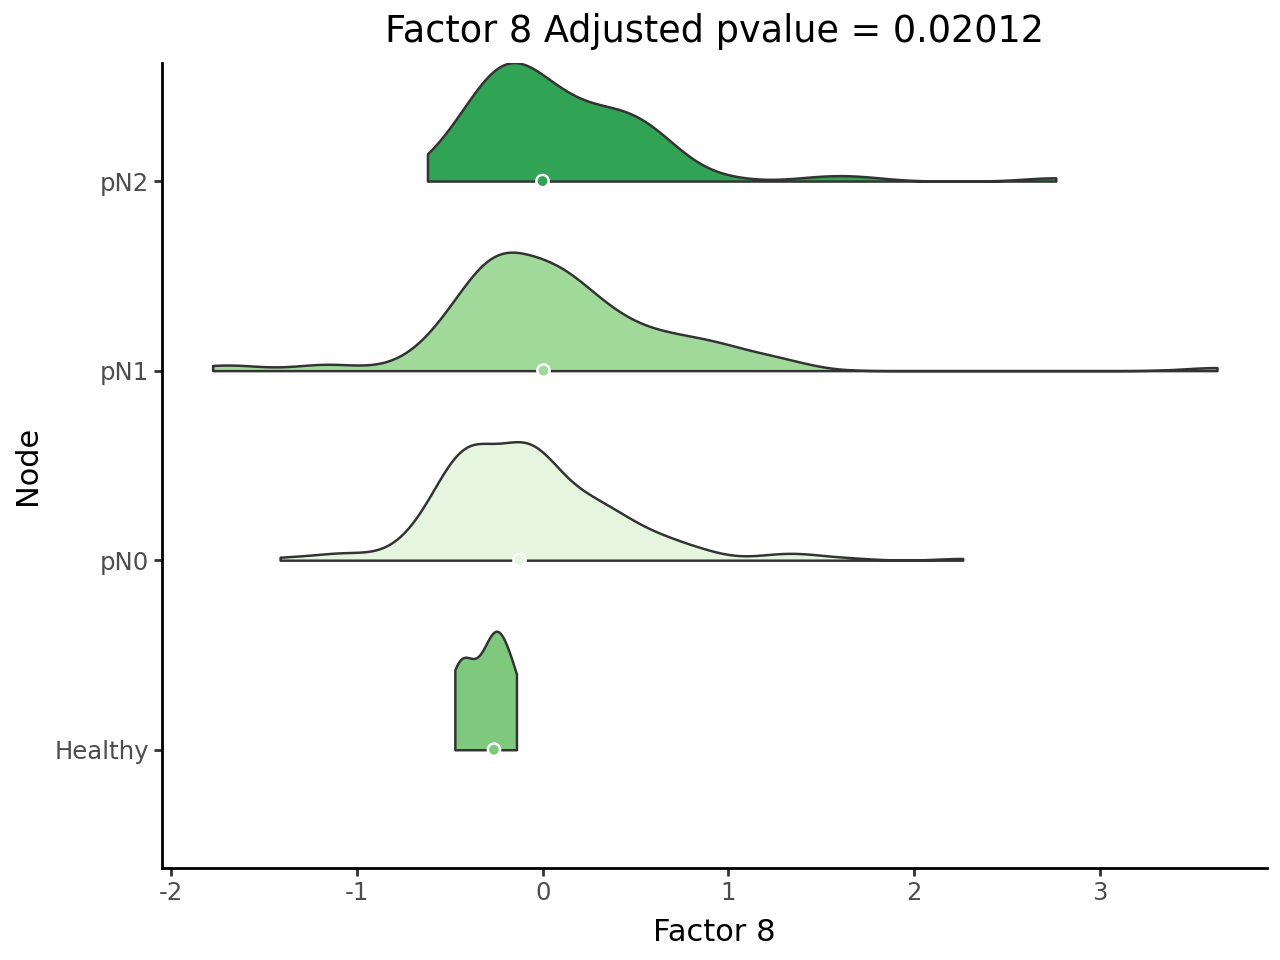

In [103]:
# Several factors are associated with disease stage
pal_stages = [(127,201,127), (229,245,224), (161,217,155), (49,163,84)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

for f in ["Factor 5", "Factor 8"]:
    gp = ggplot(factor_scores, aes(y=f, x='Node', fill='Node')) + \
        geom_violin(style="right", scale="width", width = 1.25) + \
        stat_summary(fun_y=np.median, geom='point', color='white', size=2) + \
        theme_classic() + \
        coord_flip() + \
        scale_fill_manual(values = pal_stages) + \
        guides(fill=False) + \
        ggtitle(f + " Adjusted pvalue = " + str(round(10*kruskal(factor_scores[f][stage == 'pN0'], 
                                                                 factor_scores[f][stage == 'pN1'], 
                                                                 factor_scores[f][stage == 'pN2'], 
                                                                 factor_scores[f][stage == 'Healthy'])[1],5)))
    gp.show()
    # ggsave(gp, filename=f"../../figures/fig5/{f}_pN_violin.pdf", width=4.5, height=4.5, dpi=300)

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/scales/scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


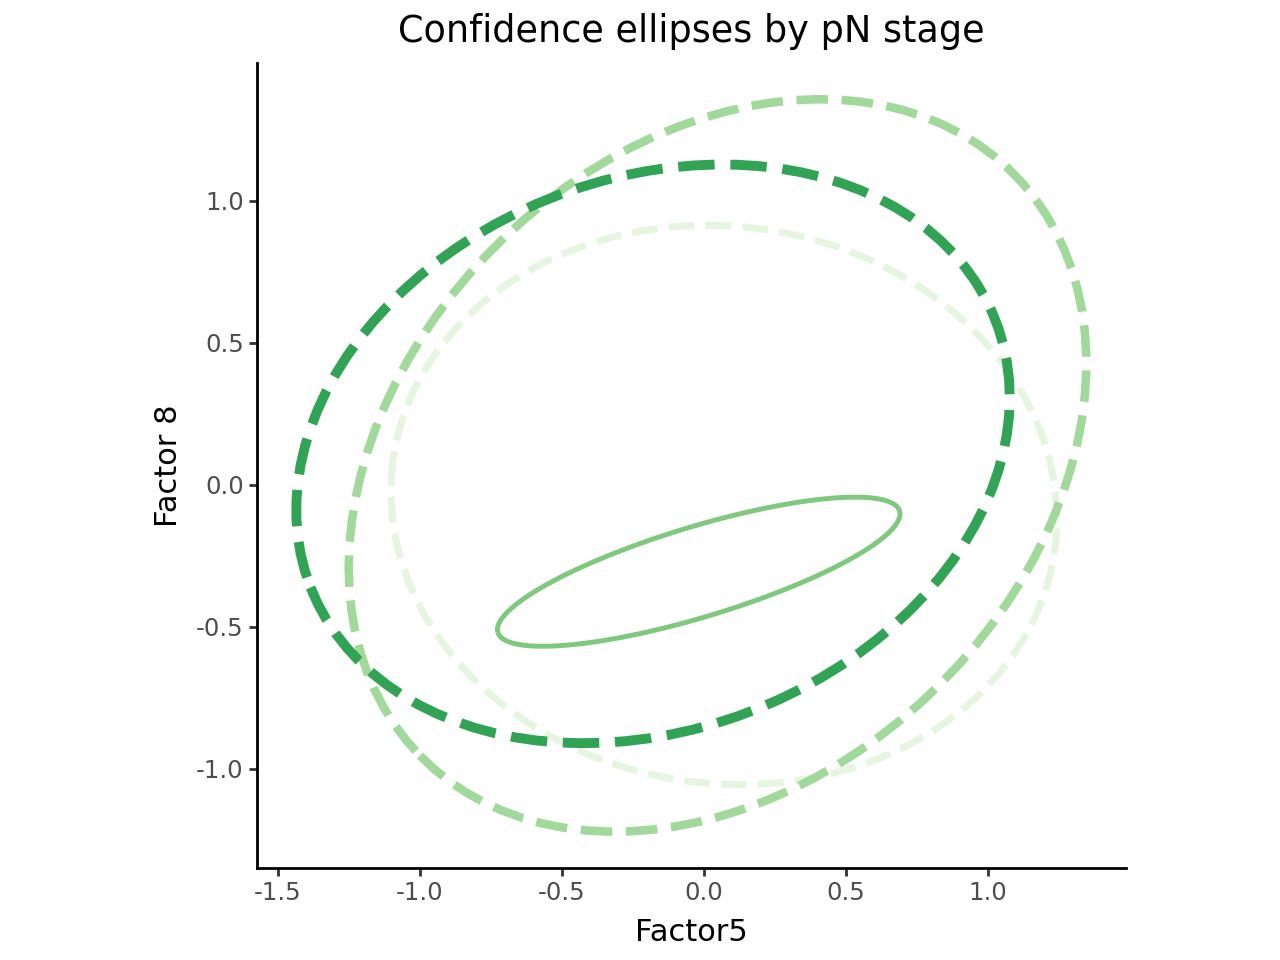

In [104]:
# Create confidence ellipses for each stage
ellipses = pd.DataFrame()
for stage in factor_scores['Node'].unique():
    stage_data = factor_scores[factor_scores['Node'] == stage]
    x = stage_data['Factor 5']
    y = stage_data['Factor 8']
    
    # Calculate mean and covariance
    mean = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    
    # Get ellipse points
    ell_df = get_cov_ellipse(cov, mean, nstd=2)
    ell_df['Stage'] = stage
    ellipses = pd.concat([ellipses, ell_df])

# Plot confidence ellipses
gp = (ggplot(data=factor_scores, mapping=aes(x='Factor5', y='Factor 8', color='Stage')) +
    geom_path(data=ellipses, mapping=aes(x='x', y='y', group='Stage', color='Stage', size='Stage', linetype='Stage')) +
    theme_classic() +
    scale_color_manual(values=pal_stages) +
    ggtitle('Confidence ellipses by pN stage') +
    theme(legend_position='none') +
    scale_size_discrete(range=[1, 2]) +
    scale_linetype_manual(values=["solid", "dashed", "dashed", "dashed"]) +
    coord_equal()
)
  
# ggsave(gp, filename="../../figures/fig5/pN_f6_f10_ellipses.pdf", width=4.5, height=4.5, dpi=300)
gp

In [105]:
# Export the data for complex plot in R
factor_scores.to_csv("../../data/pN_factor_scores.csv", index=False)

In [107]:
# obtain factor scores
factor_scores = factor_scores_all_annot.loc[~factor_scores_all_annot.MS.isna(),:]
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['MS']
    print(fnum, kruskal(factor1[stage == 'MSS'], factor1[stage == 'MSI']))
    # Note: multiply by 10 for Bonferroni correction

1 KruskalResult(statistic=6.69017320687783, pvalue=0.009694578560585214)
2 KruskalResult(statistic=0.034133536769900275, pvalue=0.8534230586490481)
3 KruskalResult(statistic=12.468789357504875, pvalue=0.00041380819992510766)
4 KruskalResult(statistic=1.26366537713227, pvalue=0.2609584233774303)
5 KruskalResult(statistic=1.088813101788901, pvalue=0.29673433680302475)
6 KruskalResult(statistic=0.08193132214125853, pvalue=0.7746970055131905)
7 KruskalResult(statistic=1.2695224509880063, pvalue=0.2598562868800257)
8 KruskalResult(statistic=0.2957720729301627, pvalue=0.5865451726933182)
9 KruskalResult(statistic=10.177603632965543, pvalue=0.0014215681725584588)
10 KruskalResult(statistic=4.721038519006697, pvalue=0.0297957427511059)


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


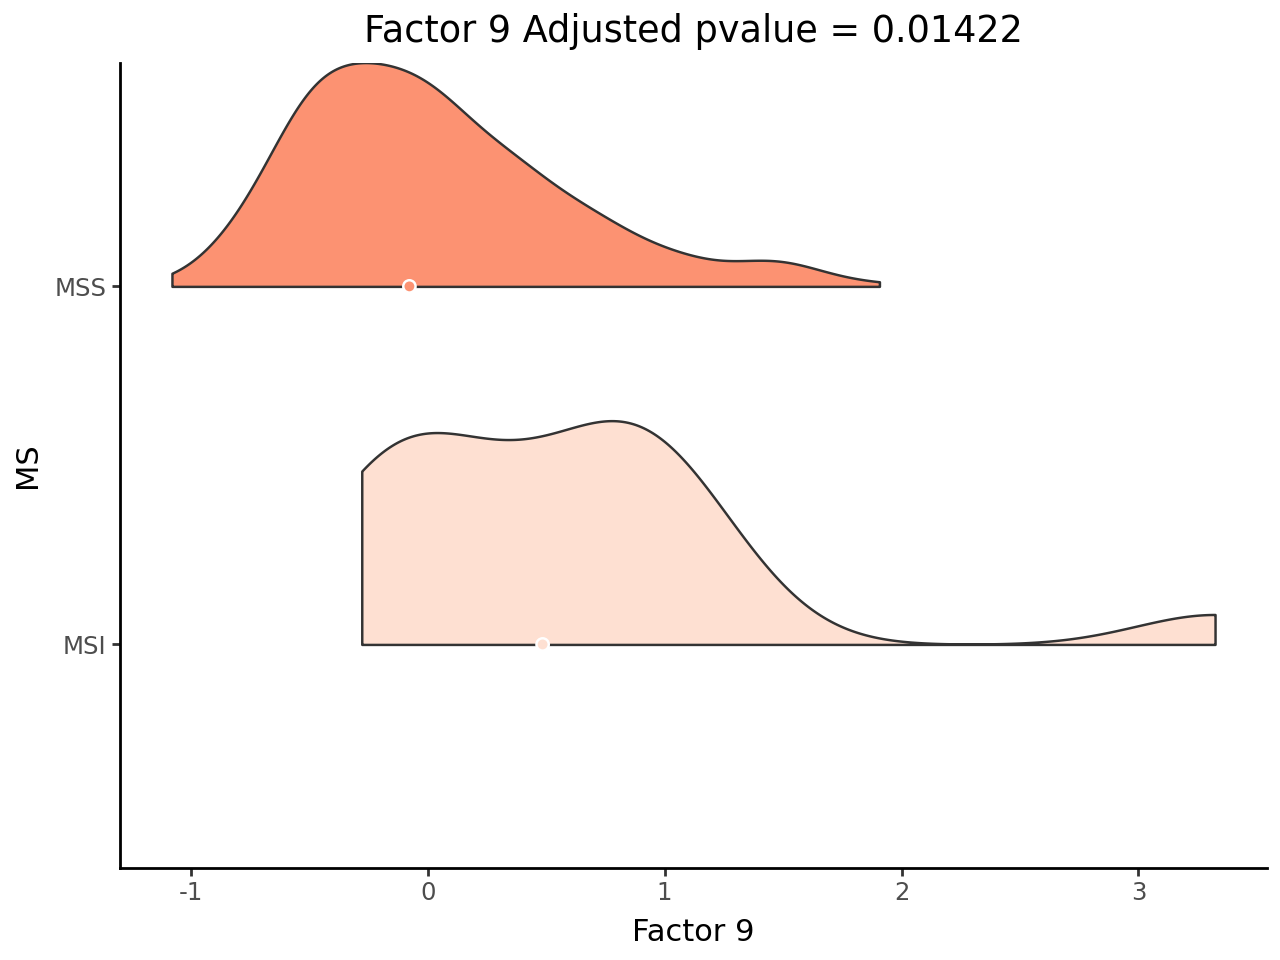

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


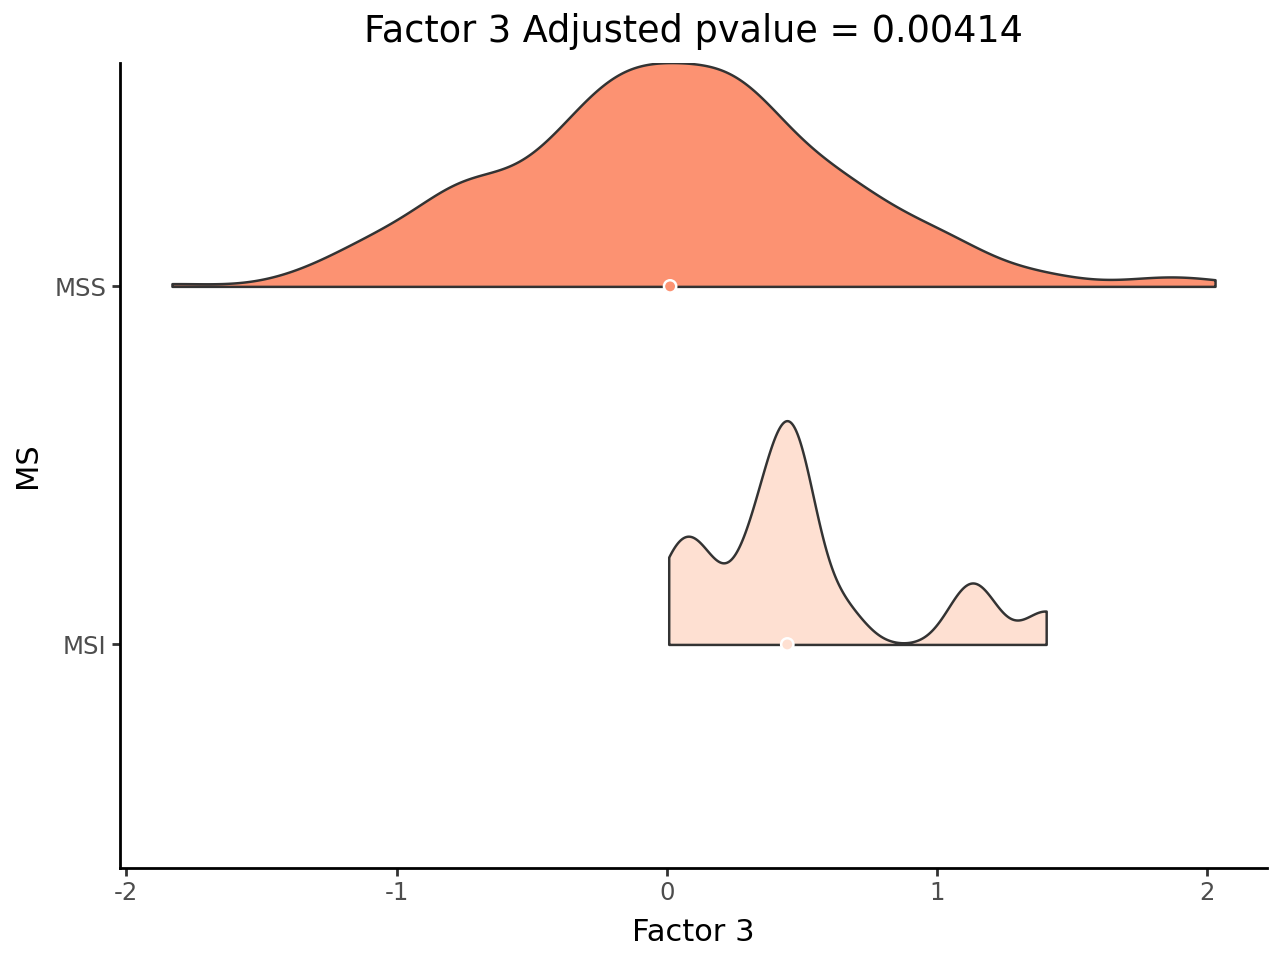

In [109]:
for f in ["Factor 9", "Factor 3"]:
    gp = ggplot(factor_scores, aes(y=f, x='MS', fill='MS')) + \
        geom_violin(style="right", scale="width", width = 1.25) + \
        stat_summary(fun_y=np.median, geom='point', color='white', size=2) + \
        theme_classic() + \
        coord_flip() + \
        scale_fill_brewer(palette="Reds") + \
        guides(fill=False) + \
        ggtitle(f + " Adjusted pvalue = " + str(round(10*kruskal(factor_scores[f][stage == 'MSS'], 
                                                                 factor_scores[f][stage == 'MSI'])[1],5)))
    gp.show()
    # ggsave(gp, filename=f"../../figures/fig5/{f}_MSI_violin.pdf", width=4.5, height=4.5, dpi=300)

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/scales/scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


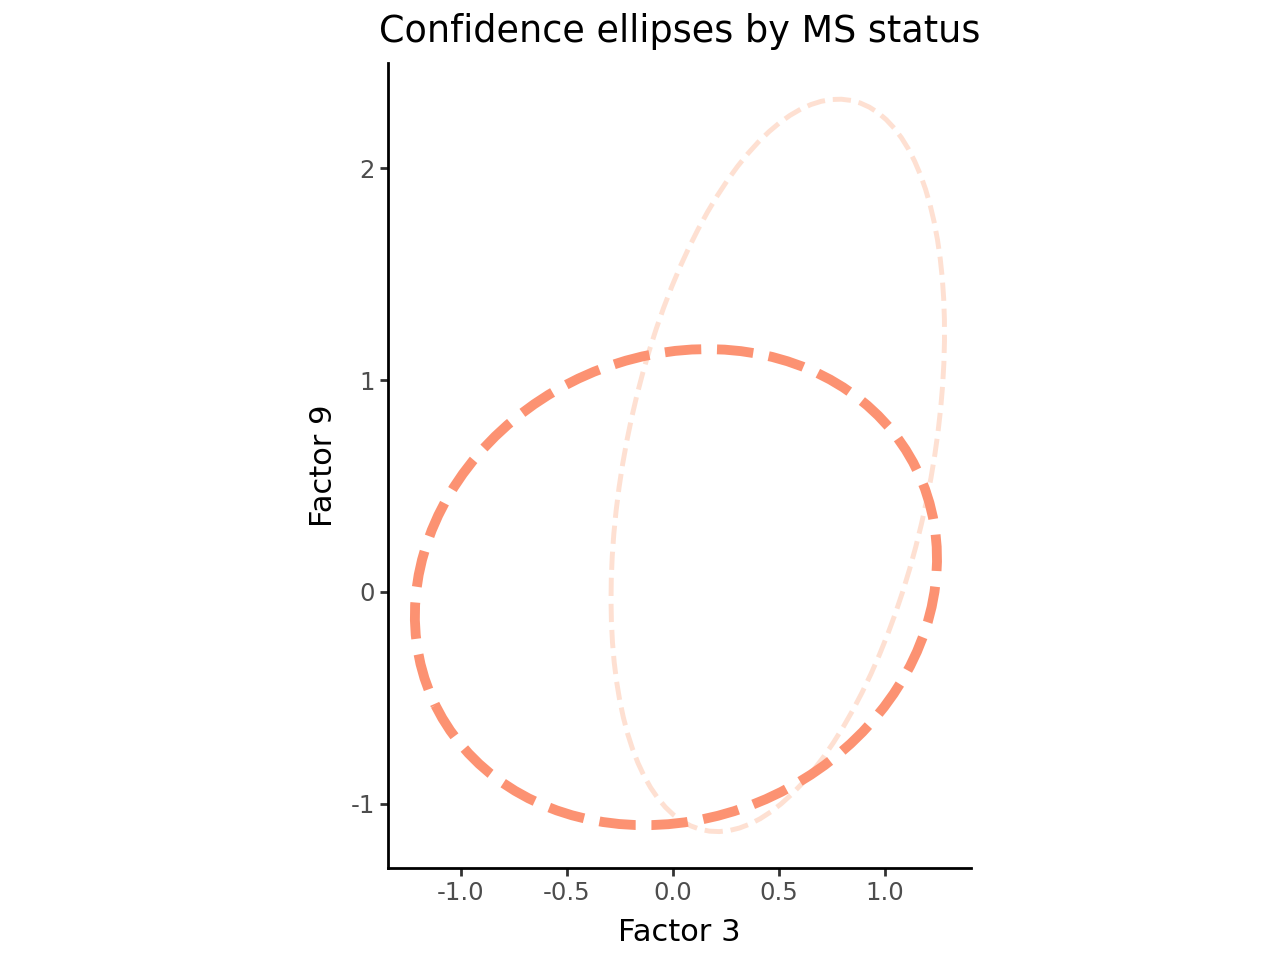

In [111]:
# Create confidence ellipses for each stage
ellipses = pd.DataFrame()
for stage in factor_scores['MS'].unique():
    stage_data = factor_scores[factor_scores['MS'] == stage]
    x = stage_data['Factor 3']  
    y = stage_data['Factor 9']  
    
    # Calculate mean and covariance
    mean = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    
    # Get ellipse points
    ell_df = get_cov_ellipse(cov, mean, nstd=2)
    ell_df['Stage'] = stage
    ellipses = pd.concat([ellipses, ell_df])

# Plot confidence ellipses with swapped axes
gp = (ggplot(data=factor_scores.loc[~factor_scores.MS.isna()], 
         mapping=aes(x='Factor 3', y='Factor 9', color='Stage')) +  # Swapped x and y
    geom_path(data=ellipses.loc[~ellipses.Stage.isna()], 
              mapping=aes(x='x', y='y', group='Stage', color='Stage', size='Stage'), 
              linetype='dashed') +
    theme_classic() +
    scale_color_brewer(palette="Reds") +
    ggtitle('Confidence ellipses by MS status') +
    theme(legend_position='none') +
    scale_size_discrete(range=[1, 2]) +
    coord_fixed()
)
  
# ggsave(gp, filename="../../figures/fig5/MSI_f7_f2_ellipses.pdf", width=4.5, height=4.5, dpi=300)
gp

In [112]:
# Export the data for complex plot in R
factor_scores.to_csv("../../data/MSI_factor_scores.csv", index=False)

In [113]:
# obtain factor scores
factor_scores = factor_scores_all_annot.loc[~factor_scores_all_annot.Sex.isna(),:]
for fnum in range(1, top_loadings.shape[1] - 1):
    factor1 = factor_scores[f'Factor {fnum}']
    stage = factor_scores['Sex']
    print(fnum, kruskal(factor1[stage == 'Man'], factor1[stage == 'Woman']))
    # Note: multiply by 10 for Bonferroni correction

1 KruskalResult(statistic=0.004868050554932779, pvalue=0.9443755980777161)
2 KruskalResult(statistic=0.01012049017526806, pvalue=0.9198674830880038)
3 KruskalResult(statistic=0.9415004600823522, pvalue=0.3318922602399413)
4 KruskalResult(statistic=4.333826106073047, pvalue=0.03736217129985883)
5 KruskalResult(statistic=1.9021993109959112, pvalue=0.16783235263318602)
6 KruskalResult(statistic=1.5427961934954055, pvalue=0.21420207679290504)
7 KruskalResult(statistic=0.1718699606528844, pvalue=0.6784552337328551)
8 KruskalResult(statistic=0.2789460104495447, pvalue=0.5973928723022142)
9 KruskalResult(statistic=0.7563934301063, pvalue=0.38445955145405497)
10 KruskalResult(statistic=0.6503257434044372, pvalue=0.4199962418700185)


Block A?
A-Q
1-9
Block B?
A-L
1-9
Block C?
A-Q
1-9
Block D?
1-9
Block E
A-E
1-4

Currently naming so that 
A B
C D E
<-a-q->
^
|
1
|
9
|
v

No sparsity in factor-feature? 0.1 cut-off? Meaning of factors 1/2? Effect size of batch effect / different confounding scales from the different features?